In [23]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import bz2
import base64
import pickle as pk
import warnings
import math

from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression

## Exploratory analysis

In [2]:
# The "environment" is our interface.
env = kagglegym.make()

# We get our initial observation by calling "reset".
o = env.reset()

excl = ["id", "timestamp", "y"]
col = [c for c in o.train.columns if c not in excl]
train = o.train.loc[:, col]

# Total number of NA values per observation.
train.loc[:, "is_null"] = train.isnull().sum(axis=1)
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0

train = train.fillna(d_mean)

In [13]:
#######
# Train pickle model
#######
full_train = pd.read_hdf("train.h5")

In [5]:
#######

excl = ["id", "timestamp", "y"]
col = [c for c in full_train.columns if c not in excl]
train = full_train.loc[:, col]

# Total number of NA values per observation.
train.loc[:, "is_null"] = train.isnull().sum(axis=1)
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0

train = train.fillna(d_mean)
#######

In [5]:
# Plot the correlation of the variables with the target value.
correlation = []
columns = []

for c in col:
    columns.append(c)
    correlation.append(np.corrcoef(train[c], o.train["y"])[0, 1])

In [3]:
#fig, ax = plt.subplots(figsize=(15, 30))
#grid = np.arange(len(correlation))
#ax.barh(grid, correlation)
#ax.set_yticks(grid + 0.5)
#ax.set_title("Correlation of the variables")
#ax.set_xlabel("Correlation")
#ax.set_yticklabels(columns, rotation="horizontal")
#plt.show()

The most correlated variables are: technical_20, technical_30, fundamental_11.

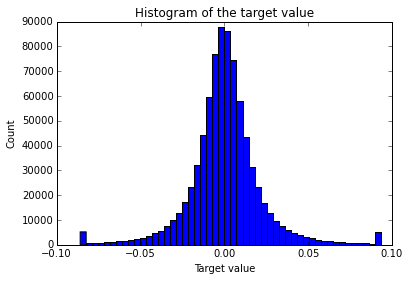

In [7]:
# Plot histogram of the target value.
plt.hist(o.train["y"], bins=50)
plt.title("Histogram of the target value")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

Notice the two spikes at the extremes of the histogram: the target might have been clipped and should be dealt with accordingly in our following linear model.

## Time series

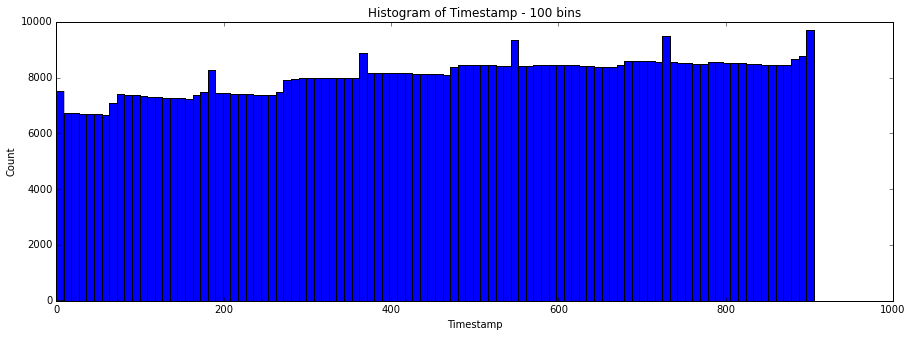

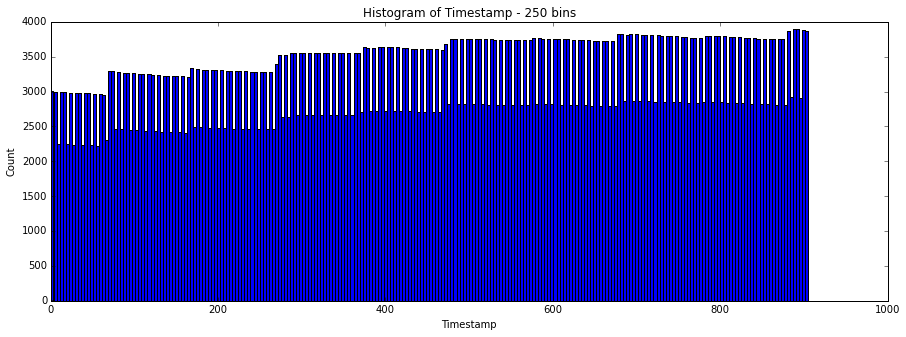

In [19]:
# Timestamp repartition
timestamp = o.train.timestamp.values
for bins in [100, 250]:
    plt.figure(figsize=(15, 5))
    plt.hist(timestamp, bins=bins)
    plt.xlabel("Timestamp")
    plt.ylabel("Count")
    plt.title("Histogram of Timestamp - {} bins".format(bins))

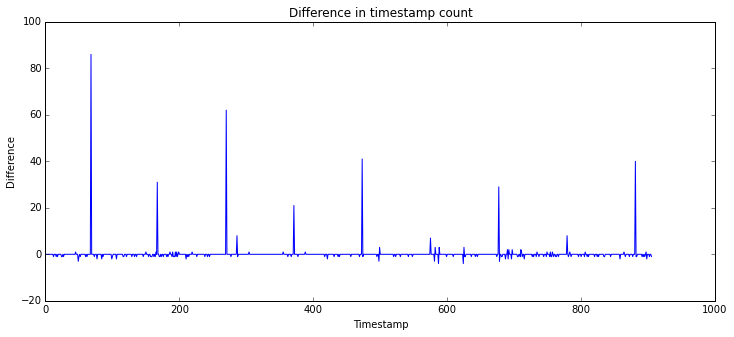

0      NaN
1     99.0
2    103.0
3    101.0
4    102.0
5    204.0
6    204.0
Name: timestamp, dtype: float64

In [3]:
time_diff = o.train.groupby(["timestamp"])["timestamp"].count().diff()

plt.figure(figsize=(12, 5))
plt.plot(time_diff)
plt.title("Difference in timestamp count")
plt.xlabel("Timestamp")
plt.ylabel("Difference")
plt.show()

pd.Series(time_diff[time_diff > 10].index).diff()

In [4]:
# Peaks can be approximated by 100*x + 70
time_diff[time_diff > 5]

timestamp
68     86.0
167    31.0
270    62.0
286     8.0
371    21.0
473    41.0
575     7.0
677    29.0
779     8.0
881    40.0
Name: timestamp, dtype: float64

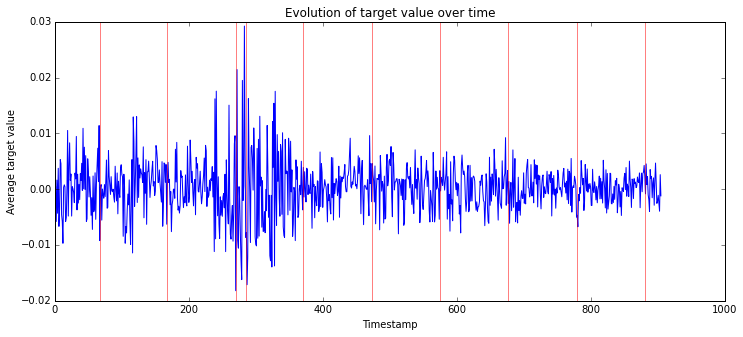

In [44]:
# Target value distribution over timestamp
y_distribution = o.train.groupby(["timestamp"])["y"].mean()
plt.figure(figsize=(12, 5))
plt.plot(y_distribution)
plt.xlabel("Timestamp")
plt.ylabel("Average target value")
plt.title("Evolution of target value over time")
for i in time_diff[time_diff > 5].index:
    plt.axvline(x=i, linewidth=0.5, color="red")
plt.show()

In [5]:
peak_dict = dict(((time_diff > 5).map(lambda x: 1 if x else 0)
                  + (time_diff > 10).map(lambda x: 1 if x else 0)))

## Prevent overfitting

In [3]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

## Models

In [4]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o.train.y > high_y_cut)
y_is_below_cut = (o.train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o.train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [6]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, 
                          random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o.train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

Running time: 642.669552088s.


In [9]:
# Using pickle to save model.
#saved_model_2 = base64.standard_b64encode(bz2.compress(pk.dumps(model_2)))
#print(saved_model_2)

In [10]:
model_2_str = """
QlpoOTFBWSZTWe3p+xYDc+DfgGAQf///////////////YW34APnoYAHwgDcDAAOHYLgAAAA8AvtXQGgU4Bwfe8SAoFUAAPg8PXyaPo0kdJnXczbds9t7Y7cvGlvWgBQSRoUqqoDUqTVs222AtgNDRjYA0bZRbA9zgpDgKc0OB3uvHTb3ddK2zQ02zbPc4bRx2B0VoDXAmWg1d6e6XXKNsohLw3vbgD1kABoAW9aVQHWmad73Cnoy0UFAJiqFK1toHPYA9eqaCgACalClbMw96YDnsDVAAeJuqACNo1uTXMNCTQpoAMylUpBMHi6AAB7YAva6u2taqraohwXvWcAAqgOBADVqu2qqqr233Pg7YKAFTBm4oAAFAAAAAAAAAAAAAAAAAVSEIQFARBVSKp313I+wAMgVQCp3AvXvRQAKABQAN2HSi6wVQSoAAAWzIBgAYo0NHr6FPPAHo5VIHLAGpDZNB9B6bWHQTm0UB7A1ttXgdHdASp5ADe9IAgAHdlQoyatjTWitV0ddFTYAAGTILYDRZtjKWxoaaFaZAFVatLRQUAAJClAAJAqqoAAAApKgpQBVAKCgCgAVRo0AAaA0FFaBoaAAAaAAAiAAAANkAADAAaFKCigookaNAAFKqgBSgABRoDIoAANGlCqUAAAAACigBVKAAFVuAAGcQABPu8DvLwO2D6dAAvo91GAM+uo96fcBI9DTeA2RgC3zGj56Xd9mDbUUpwWRgG+veAApmynhu4uAbesUd9YH3rABXAcbuyPVFd3iyqXGAAKV0dATmh6WeXvB8PQBQoAAUzaQPH0UKUABRRQAUZySF6aKmItpvADcUA7ZbANAACJoBNAAAQAEAAAAAAAJiaEpoNAQBAQmQCaA0AIDRoBoGkwAAKSBqYNMpJEmQmmTQTTQmjajEw0mAAKeFJ+FTemjFANNpICRBEppoT0Keo09Ceo9J6mQNoj0T1AA9R6nqZqNNASeqUiI1CFPUaD1NANAAADQAAAAAACJIIETQIAmBCMmjTUwZGowaJtQ2p6GphNMqD6fpj839Y59YHODgFfg+3733l9/Z/B+Bttlt0223jbdttu223jbdNttlty2229bhzDbblttt6222226mnVvAhTq7IQrbvQ63UgqyzqnHSmrV7ObSu3jJUskvDuttpagkkkt0Et28zEtRSlNtvbu28bZkSlaCSJL3d1ttLVCSSSOwS3bzMSvUlabbe3e42bbOAcA5QHAOQAOc2boADgF3AiAytN6nr12dlllllmWWXrksq4ZZeMhlllgssssss44ZZb2CyyyyzTLp+uve7RZZZ6YZZePdevcLLLLBZZu7u2WXZcsshlll2XLLLLLLsuWWWds7Z2ztAQbKIhm9Z1RB02z9P9OBQdgEbyb2sb0obClKA0AJQqFtxQcXKWXSfCkOqGqQ1HUabYPQkOqTl2CxJa1moNiVLZzvAQYiDdASoMiSAZugGlqRNBQYHCINwQaLzakKIsikCAIVRhBBvSpIBpra974l4WRB0uCDVgQdbCg63vLa502lkm7cwm9hrW1FJvYcpvYae6Iab2Gm9cwm9hpvY1w3uS02oKlvYxptw7euoabnZabMNN7ktNqCm9iWm9gMt7DScbDTew0G9hps7LpvYab2A03sNN7Cbl6Zad7DVN7DTOw6Tew8bjZab2Gm9MtO9hpvYtptCG9ew1jcw03sNuHsNNpS3b2Gm9ENN7DTewwm9qWm8hoN7DTew8TahsutlptQ23tS03kNN7GNNpSZb2Grb2HbewxEOmnDbew03sNN7Gy5b2GmthpvYppu4ab1S3T2Gm9iGm9hprYahvYabTmE3sNN7DTew03sNN6Iab2Gm9hpvYab2Gm9hp49h1nAOD1iAEACAEACAEACAEACAEACAEACAEgAAEAAAAAiI5znOAO1oSLLEVAlB5Hn+39u+oju7315HnpttvW5bbbZbdNtt423bbbttt423TbbZbczLbbbbThttttttyJu6q2226bbbLblttt63DbbbaYbbbbbYbbbbacNuZltttttttttttvd3d3dcNtttphttttthttttpw2223rctttstum3My222222222222smp8t3zgA4qxLCu7XW23jbdttu223jbdNttlty2229bhttttMNxDbbbbbbbbbe2222AQYiDEQbog6Ig7KA2vigAEAAADGAIAAAAQAAAMYAgAAABAAAAxgCAAAAEAAADGAIAAAAQAAAMYAgAAABAAAAxgCAAAAEAADYAAAAAAAAAAAAIAAAAAAAAAAAAQG7L5j0pGmi1rZ1QWi7Ra1s6i0Q0Wi0ca12XCLRaLZaNtS0WjLRa15sNFotFow0WsaLCLRcotW0Wi0dcFotFN7SLQLRaLRaONa7LRLWt6StdFotFoy0WtGkkktFotFotFotFotFotEta3pRaLRaLRaLRaLRaMtGqbXvuuettvpbdNtt423bbbttt423TbbZbctttvW4cw222222222223VOaeBCbnMCVurycdJU9xBtklnd1ttHVKSSWLZJbt5mKlqSxNtvbu28bZaYqq1ZFWciticrYvJpuxIo0Hd5MsSbjKd4FMZuXMjcx0WLmNNFOrbBrLqW0zrC0qFKm5CChzlaRMTB3VtXMTCnJak63lErKndxaE9ePIQV05NXUmma2rbU3O+f0/6D7eA37ljVG5bmqNiqKNrFRsWKiiKLfpbVcqNYtG0msW0aiiqDRYo1fp7vHw1enpUUbRjFtijbScdJxyOjVucomKtiueQQd7gg3BBwCHNA4Byd+b5ld6REYbgZXzaoM1pNij1zt7eHizcdPcW6r17ArJpRUaNVZdUXEc05uTu6UnW0AOAcoDgHJ0DgHKURmk6NBRyt0pRFImMUKYrTSq3uLJGqlqZMh1lOKt5d2XEKHl0Tmvd2XUxO40uDgHMA4Bx1wcB2QQZiyaRJrQ1BqCVG0LQkm1rRpN1ScuJRNyShqomScOXxXnjimtyXbkKAuKR6hI5Dckxu7uOKG5IzjJHIUBrl3e7Ls45DZHGw1yR2tkUjkOSTbigNhfLu9btXcZGMZnhdkchySc4XZQbKI8QkcnMSXrF3ccUNyRnGSOQoDXLuyBDjkNEcbA3I4uEUjkOSTTigNnOKS94tXcZGMZrhdkchySa2XZQG4pHyEjkLkmtXdxxQ3JGcZI5CgNcu7uy71y7s2RxsDEji4RSOQ5JNOKA2D3Ca5au4yMYzXC7I5DkkxsuygMxSPkJHIbkm+XdxxQ1JGcZI5CgNcu7zZd45d2ZI42BuRxcIpHIckmnFAbOZcl65au4yMYzfC7I5Dck2nIUG5FB8hI5Dkk1m7uOKG5IzjJHIYchrl3ajkOOQ2RxsNIHFwikcmuSXvNq7GwMuTXLV3GR4Y5vhdkchuSPJIUByKRyEjkNyTPLu44obkjOMkchxyG7u75ZdluQ0RxsDcji4RSOQ5JNOKA2HOXd7xau4yMYzXC7I5Dkkmy7KA3FI+QkchySazd3HFDckZxkjkKA1y7vVl3OXdmzdmrkwYckcm5ITd3cchuSaI42BuSLkkjkOSTUUg2G5Jrl3ccmGNzXJdxyLHJLtyCQAgfISNSXuS88u7jik3JZxxSOQ05Cbu7jkOSTRHGxBuRRckkcguSTUUiGzO5Lvl3ccgxmuXdxyHJJtyFACB83cu3IXJM8LsjkNyQ445GTcUhvHMYxmy7lkd6HCNiMbkdrhFI5Dck3i1djZk05d8lu45Ixxb5/8LvZeviH8/n8jffud4K7N/NUcAnECEc8X3xP7oUk6E2zJENWfbp30L8gGUhne+yqjOKnW8ig0AgFYyBI1xJjNAoCahykBQknGIQB+QoIG5bjMvwLtb18w+xXBiAQtoM75Rpd9JZPCJIbWm8b/wuylB3/x2oewzWHPsFk3yUFNFw/hXOj1MmspFlB53bSkj2aWQxSBIG00YgY4CvCFsQJkF//oYDhklOnq1THhfka+2qZMEx8gREhdordlk/fofHHJZyw/c6hkih/Z5YhB32jNuM2CTTSfinBICCkBdThzlL54TkBpfULrh2rttzHOLWkMp3RqYNB5qbTis85+Z76+1RBTzZI4Baffga8I7qqBiLS21qCE1Z6SAt95UHDJT69MaoFvAv2+mJQWrs39/jv0fufP5/t+stY/iqU9CHTpNibAGCaBiRlYJwnRvk6tLSm0m/flgLCCx4ov88Z7UIABxBdpvsygTbi6U+kLGksNCLjxkmaArsa/ZfN+5TA8IV2z36JS4lYON6I47Gtdyc33Wwny8B+1gNpEBbu8GGDRWAIh6mU9f77aLLgIGkv1glZqcaV0ySw7kt9O20ux0jV/F7g9J2l75pvu4gwxD8uFdTXyeoru+ryB1xjJAgQkZH0eH4Pua7fl/fY47N97zq+S9YhoWTHPCVoRkiyvBEZDX7jghRPwPAXJ0UmaAVxOg6BeUYOpMiwkoaV0qQrBuTnjmDAafqd+8zBC0P3vFnnyjrFrWeV+/GhWyWORWky2FWpSc/bceuVtLQQpG5lPg+0haIcwtAtfoH9iFAhPPleRHGCKDqh0JFtOySVJfS1kWUH2EI7Me6ZoxJOZ9Pa9EOd/7SYqNL2JAGfKQCB/xShYvD2ysUkzq/7NiM/8SS3BsTP4RtnGGQwRxFj4HJqtIt3rNdY/yuBoiQECBCWXwNsYZPoWQ4pyMlbROMaT1NBEcwwdfW2Qga3zW+420VRNwUHLWIYBJNFmJjGQaWlsOfYGz7fOHzggrKKgNf/VQ3yTrOcnh3H/o8YIe2wOWb8p7Qui5CyGNHoZozdx0tjT6fNF5XxMVmZBRDMEJfh6nMpaa35IvMXYVoUWWLL7NGfvlzCZnslqp0r7/hO79f/G2mlM5CccJHhCF+vUFmbE1cZEQBAO72AwSiQIB0W4LGgAyQLKrGq2l+Gtpd97NSe1zGYcHhBys1zfuptCFK0mrFGzLGe2+V3cMn82LMb/5v0zOamizQd4Irxo74Jf4z8Vy1PHnNHb2mq5kZMul4VYZpmrZuSODoVAkViQAlEhAK2J66ZXZCpOrDzI1TLTPa7lr6MPBHxN44JIh6e6ZP/bv6VN2ebjblBHmxpzt5lyANvDH9KyENkkT0zYfq89A3g9s83t+F+rjr/9DixwBg3C7DaHsK6/BdAt1lHDLfOBfGPUfWmsQg5OB3auty9sTTG4OeaY5Tsf27rGWYBbaGqx9j3a2vK5yHpaelgMCOWQsgs+H7x+7i/8GSo02p+LillAJtADbTBSMoBDTBDpwQCAGNRoklEF/NJEAgKHhkENt4F/0WKWUwQ1oFbptARyA3YiCY9SpBAIBYCoCbRguDsVtOSUMYCApGJFAQ22C/ZJFiSUAm/43IIdN/y6/+uTX8mNq0dU3bfD+V7n9ycfO8iyCGmH6OQQ/0ZD++0NfLXxjmL+HbT/WK3f/Ifry8Tbl3+/em7uI+Pfq17yJtZBdkiMI3LXoqfSvilRnufmskIeruq8f8Q/+gPbBP7R9MPJyoQJAPFEKh0i/dgHqhiSBtEPnzXi0oDWanVRIHbExH9UfbHvgOJIrPwWBQbDEUPfryQOCEgXFQlokj8MOqHd9vSzvA6olSEO+qDzzzXo/v/zS/6wPJF3lT5IB2QEYpMJPzdzY1FST32v5vnQjMZJ0KRgzMjNAYkiDxfblzxpPd72xT5pQ9/cmjdH2j3pkAAdpz06xgxaaQAgAQe/k6b3gsAc5ygDwh+OOmAHP1ar1+CulZP/bm2YA3BAEUFJvmtGDhHkHYzMzSYEzMlvi470DjUrNC2rPSBCVxYxDJa/WJ3/xCAQCEIRavD/B2IAJcN/6mt1ojreCS9EFw5Fi5/KIxKA/ZAgP8eZIpXsGjZHEYXNH/7s89LTL/TA/Y77bKQWyMaGw7KWZBAiAoh+lo/37nzdcoGR/enJ7eK7z9eNryPakUAb9kieQQDMpnruPAmHHf/td3pubTR8wAAgAQgZ/7ixnozcslTYScn+dO+ot6nxpmNEn7yH6x1NQpP1iexuajjqczLOe+5dntMl0WGtNumNO1vzLrC52aO2+9pPA+L7eZoUQyN0OTBxHsvVFK22P1B/bG2QlG8hhP+ddcCVHPI97LR60aYAQAIlRoVd3jQh9+li+6NZ/98Psk70hSKKbDJAClQNsZ78ec5IklrAH7amDThKZoXy+U1rsQv/Py3IZxfFD87UBTSGgYuBH9jeaypuck0CfydPi8AEBEID4nsMb2VNcR7MoDYZW1q262NBAJZCj5vo5Ubq/6088slyls1B/J+i3aIOS5N0cybfuTMxEbTJKthnK8ej7OTX7IaRSl75vq9wHlRLaaNvnLJ6w50zbu7C0j/sEdU3my21ZKdsApLY2v3jlb1hvUImXLs/tEKJUshIJHX54j/2dKhaWlh3P3R8UokGB9owajeu5igOkt+Q8LjgERKPeC1AIQW+9yeLO5qYLTYfIkwf10xFRoy23DAkMzhg+ZWWWpIqqJLiwsnAHZ9GJ/c/PRttEVTprdOma1GoDLvbh8MKbczxX/yr9scaOAgsLAKemjqODbjRa40tpVkLyu1JXuPraKLd39HUjvn4G2gcpS9vsYaobCmf+trRPd9oI9FHX+R1/y4/fhkYCIhkjdPDkFY+9vTC+1YoaD6O7FiKj37k6MQgLnDH/RmetspNd205WHAm0Z+cX1FC0YveMU1RkQcxs/YcAhADSPEgsYloe7BJJw7n75e9HPwJV0ahJhu64tA7L2EE/uch00kdWReeh1DN1eREj4MyuwOCDW46/QcDNsV+2nbvzF1I8wbYZ42EWg1HqT/xZZ2FC6oyAIQAIlwgMS080dxDSZj+fdpyP7fF68Pn9+XnVJcsqywZydT+J9Dy15zhyZgYAse++PcVmXc2a7y9z8ORhCYmkra7W/+S149k18YReHKJQ6ciDezFYPgv4q/og1pWPs5QgVPgt1HbviFuu2bhsnz2krZtGbP5t6DuEwjdFP8KFW+l6BCn3jnePMPcYpCBOi4yXasOEKFuBHmdbDp8xvfce9khDjUimeJPJkfjSgCEACYEWmzwY26mrdgYZ6huQ5WnhM8JkaqiuIDMS4RP/Fht8TIYn3DsNFAQACQYJ/PFE4KS8oMeE51tfXqgk9T1VcjQFBWZpTPP0FpOdQAA2mAmVH1F+LewQqHyObScB/NtXAIrUYqDG3EDZ7T7+sqzKXaABCmB7O38MmZ2+mdp/85myl2oAOKhCY1Zu4ZvNqw+cWYQjPOl8AtEEROp1Vpw7AwOFGzQM55uOboF0m2aSthozB5EgWg78VCXAmekhI1N2IiUpt6ZPb/jRwA1q6h14bFwlzRfu6Wv3ROQf579tdc9anaHze8EX+aL0Svh52uzw5IMFxrD3/fjZlyFiLStAREBywoSwF58xSIryTLEryrD80Ct5Fzsa+RZ+mnNElT3LpST9yO1lNwCFEHM0hAEwJERevpyw3F9N+hulwEt10SXVajOO/A7oopf1MANvsmAP8hBnMrTOT199fOpVCX6a8DPxS1GWDEhb0GRrWpS5ECpalKMpu4pWm3XP7fa6t96oPT0qwrXnQOAcgVwcA5/hzzu3PBwDkeXNJqp80+VVI66laE6lHXUrDpeVhq1U5jVSjtAc4OAXeNpEtPMzMRbZM5hLbkDgHK2bttt0VmrUUpLRa1s7i3FplJEnW51JatZuUtKbnVV6tW3snEARxtxvrrvvxxfM02taxnTIIM4OI4gFRHM0im1qA1gZiHE1ilQC0R3nEUqAaRHabRSoBpEdZvMQS0A0iOs3ilQDWAYgOk2ilQDERzNoJUXaOvpj6W+da+B935y/P3GWP2iuVF+4iZloQr3rDaL1RW8tNE0obS8GfDVnzUiS7ENt1WQwFVkFh45f8zUtD1u7vYsUqWzrw7B0qTa1LvzCpadRNBhkpCdPQRtCMoNaxFS16quLN5eBxFqAIMImGURA02pLBDWLhI9IhaN8VxKm16gnnXvzkv+DvHGNa/G994So3w/R504zRYktOI2MzfauUtixFUsQqDeJ82KTGlJUkSEZKmNrWZFvJNoFnFFzNGfvig/8VYQvineAVJzoZNoSGYXhmLUhE3RAZwxju27szkzPtAIgQD03PHNaJORRMgQBUQxWfxIoGsEBkUBXTNAjVUqWq1gEqqFJVIgFVQPOJa1IMqhAlUJeKNrUog8oIl4isghIK9IDU1qIrVY1qqiq2q22LQigHfFVATrCIooiWggCBIIgiqhaKoCVEQRkVVSQ1tVfCuVW1GjW0a0VraNo1UlqjWoxbWoqtGoDWKi1AVSIRAQFkQRDSAqjUURZFSS0RUSoCNQRGQRSoKsioyIqyCDLa9Ol+nPnMdXBfRvN43zeMbx2kmbaG9sTtMEFwjabK8ZtHiHOFMIDFFGQRUJAJFOcECSof6QGoBIExQPZEC0TSSKpXTq+fj2lSVFnz85PmLWdl+uVyTfar6aSWMDBMEwC2ZBNu2biaa83I1TapppJ0qXp6s7ttrUM25blrc3I1uaNc/O9rxFF+hrc3w3J8dtzVXrzjEAZkWGEa2sb4NBq3Z0hZZymA0JUIgGVCNERAdnDu453v6889W+NJaGqkr8GhVqVEOUC0EtFaloNoBaI1F2iodVTarznnfXkfl576vTesZ85zfHd9VttJ+MXmk2234zoU6euk80Qpdaqvl+Nf4Pn3GmnNe229q2vAmttpjLJXbSNtysb9CubK1ZeU+/nYq8at1GqoHpA643gF4jVUJVUIVGoJ05c9fhzmvrJ9fVrO+PWeWPm+pVvJQMBtP9oImNzu7rtfl+P5PGptasWsaDXK0EBgjMgSGRGYK8LRgDZr1te8XSLrOUlaTnQEs8TK8JsLDfbUsSAYnGe7St+qpqqbKJK1Y0VG2xak2xt9piubYqN6Va35m+7ePar2totTAmOD2fb7K757KJ9tGkrH/EOwBwDjF33wc2OKeJgbZGce4im3bPUqtNppNJOlQ/h+TYMY2q0oyg36GrhrWvBlUu0KIlQQqPOCtTfqvjlynLF8X5c8nThvHOGJntVp1vLb8BNvtkAAT0zdpL8ln27a0axWD7d3K5shoqxaNbaLRUSUbRVjVY1y3IMRqNpANY1uWpgcEQBzkRwDPPXfVnz1Geer07WFtolg/ES4ds5i7tQGxjabT19TxV7dVSdcB1hNN/7Wtnt6+mmZqZpHSqKjcYFQokopLsNIMvKS9oE7NJc/kaYzdCQagoVVBI1RUdPx3wxiq23IYdq2tg3Sw0k2qQ1hjozUyicFjmkvrZTeUOCxUUME4iAjMs2PJ14tYBW9+y52r6NPLWsJTAhKeAKOm7AKZGDAA/nTiDVIgLA7uhAlJUBa4fEoe+SF8040bI69pKPPGLj8++hQhDHArZALTECSQDxQbQ5a9Wdjl++XmudWTpNPBzVKVHeNUg24GPxlQQOQE4IfZyh5IuInXCKTNpbCIiSRllZCwmgEjHqgPLVq6Kqnhfj7NbymuBsYKxgBXKsVUn9oXiSAmOmltImGmgtVc4nGQNIryVY/pqbI1jRhZtyZbFb3WEUtvFm8jv169ep8Hz2nweN9e/O93oGxr5XJVCDikWGlGm6/W6VuN61ecJCXcrmi6klTCXIQgsYxIkCE211zLyVm2LXvUtjGS8dvFtWxre8MLu1EREBjvUu8MecRXLovG8pUrdLLVca5q1NvTqOo0iOkU262KOmmqcKVaENJpEKi2DS1tfszrFCbyOlSS4DUYNC4tldsHQ1piapIVCHo5i4tpoaV9iUVg08go6bRwpVzJSSVptpayKoo9Xba3vcpZTw9u4WtvExuTjrlY1NtumtipZYm09XmIdVSvYi2J2zjNMataJVKsMdVf+9cq6yUJpulgQk2l0KaVtnzvMdmHSVU35JG7BB1rFpCdJdBJvDXGtzOLabjH/OR+vR10EhmGCiiprxTpinBVMYraqFxCgI6SjBQnSSBti642mutTeIngbXM/UWMLb27ptKqHILu8qK6JjswngdLTFVtDZmK881pYGJqqWmkOY7pXhrFkc2VG61Y1FVUqkWXRFpqPANt8xFG6VVtjWqbEd78KZxxpxbape5dT/8cT2/T9PbjxYPTpR1AkUKgYnKJeTx66Zvg1jRztQZg3zVSFoB1bFBeUSpbFGb0JIwnOK8S0+9xbQHaECj21LBvqYrW+avuY4k090zO9dd4rImi3Sg0LIU2v9AVkKbae3S3EUqckSSohUlqQUqTajSzW0UZekQLMSWoVKgghIIqukUFCoowigq/8wQRqIIISKgAqyAKNFatotW1jbVa2ala1bCICSAohCIILvBUBvEVUqKrCCkAYMgCCCWgiKVEQkBPwxVf3wUtBBkADvgpUURJDWJUTSIoLSwVDuIX3xyejhEFPmbbX9z+j2tvFtVFSbZgm2pRRSERekXuhZkiSKgh+7+Xs/2PX/b8Wgj44Kex7udlOyDIdkF92IoHdFQTEE2qq/dbbZS2lTabIqkstCIB2AQSBAFVkBQCBEAitsm22ots0tU0am1kraEkFijFFWoIAoMiAjIqmtjWqtFVrWLa1SltapRRSQUAUJEREQkREFECLVW1YtVW1jWrFbWo22lJBBEAkEUCQRFU8FqVWeG2diYyEC1tr3vVMgDM2LO+tSEi0EMe7KJGEVtVPOtY2d43rDe5oSpUDEUveoSTeVCS+1vo0vgVzwUqBktWtnXfTfO0yRUWqokkI6TGK1xiWgukHaAFpOVGYW1qtmhV1gAwsUKm6SiIy1JRAkzehvbXQxnbRXexRuGxULaWCt5QgURFSJ2JRt1krLjbyLW9wwKknwGusghyExrVlAKqlVIyiFSogOtqkFUgQuJJDQmixDXQpYMxUkNvOSNNrHCWJdaqomqbghO95yY/o5ry0lW9WTjq0CERZK2oBS0Qj71a2dd6tdAdoIVt2mgXMaxnCLEJtJankqqSlg0NJNkV3yWsrBBNKM+/dtisQBLRkEG0RTMLBACEGSRZAMwaKxva6Q2210xiCqltQqtaJS6ikkrdKlTiGFGNYvdiVVHSpUtZo0mht1bzScQxQ35c1yaevd0l6+13neO8itX2a1dQ3zLkpp5EWaaUTUEcL0XeCYNNRqsOkKm3ti1+w1t0ttJtor5bblo1pAJDMRCoJLaWC0GRUNo3iG1ZsXZg2VNZu8cuRp7eHBIS81crjWoU20+Y1enha0sStWZzWHNu1NZLWGqsZm2DTd679Xxd7RE3e/v6vn663xPzuYQ+lzl0JxDutrtti6pN6JVQZiBUhC1UBIMi60U0o7mYJb1pcx6eWlhrs1u1G33r3LdrHO0JDxdvfv39e97Xx3vy6c+POIA3gtLiqMypCE3hUx+XODTObzcti1RqIbcwRbEwnJGtINCNCQ6pNpOCjSSgYWhPRxZMMyfzTDzoHiqpNNKNalDpp8fjqV25EC6mo9tCpZVxKNttbVoib07mmosQjc2RYi5jOVnTSGmtZJhrL09BnBSysDdtLjSSt6aVN5bixoGw28UNDWHzVXu6SkK/wsygTTxyQfZSMalKTE661gSobYsmdawrWGYMX/BvK1h5pRt2gGtmsTjFyxCHG9ry6jneswArNOIBq3NXjpo9K5rS+OuMk9++fbvPfvJwTwbi2+O2nzMUdNOlsSNWadpttNN006Ue4J0FtatcppPiLbgkJw1Ck28NCadN0vkuG/qKL+FiTejyZUFxYROj9altfuOhr36G6cFlieeEptZZS57l5xGltN7KgynEFNYY6bqm1TW8zx3y5ObPNLEzIq/Us4jt8cadWeONNtOxtFO3yDSa2x50Zvrlht0NZaKTcKQ0m15WHSyCxgSFWkJIo4q1lzm1rkM1TCGUxN4UFd0ZEcNp81mK/NKVbSzClTbdPHIunSJtUtNYyik1u9XVqsJlJ62blzjt/+t0b1pWNKle0U2tiJWOTHMSbi/bs8G0u9vrt1wkRntSVbpYa6x6xQ2ms6KvOKt4irxenjfTnyq5enyvGyyN9LcFbbWH++0rtvYuqxNOmk3p9ib7gxxby055yPGKwtSYKTKodJWKko22npG/6smBOk+rN73x600qOFHYsxXnIlh3u407jbWMmCpc2mLae9nIgusRO6CGsABZEkFRC8VW8FkBE4Iig0wFAxBH64KloH+8AGohpAFkUoEgauzVWLFrXK1uardNto2w6VVz0vMcfcGR6Y4npr2oiIGmlGUMbbTAULhh0me/6zKxW4Km6XBFPQhpNJuaiWLW4PVi0rRnAoNipdVUk4jO7StY1My42pg213GFCFCyk/+Em7FjslUnWJKja3+kqU0307Dm5hq201SbbbcYksA/DcKdJpynpxJLXUUpC3Uxeb018Or1quWcc3ZDLGll20NJtRNNPfMS01l71dTxjbptU3UH/qESkOn6ypSSjNDxa8l0qUdJvDQ2AmxjbWzkJglYw4pUSRXfXXW5iZlBAxTeNtaNYa4rExKUmPNSq3zKUdPhhvgtYWMXWrKqkslxDVbdDTcTVKo5WmfxXJhjSjmixrcVCdtUJYFxqTpUw0caNtbajVLD01HWGif45zzHkT58623j5cVw3tbw8XYXt8zyDajFioG0AqLkjEklRbwAdKre1GMIVMOONLLpCbTq9FGrQs2cLerkq3Q09sqq/uuuTkI/zOvzqxUQddJKNxGINsCRkJrra04qp5YVpnFm8YzlXSzurAtHQhOmk2soQ1xlJX0XjjVZwU3UBdBuoxpguuNN3u5adU2nTVZeHd5tWNEG8g4+QdPCuKfwkhSrTH/UVt4vxOVJyGMKoVtrVppWZL0mkcESEmaQqGJvVnx66K6/Y634qvt769r6+3jy4Mno7kXQTVaaoba6DAjF15bceN3dtiapYTqJt5BzhGnlidLTpDpR1Xy6m3QhAm28IRSdNcdZdYtFWFbBp8KYNP/rSXmbTatN6E3prFidNNrGDdobTQ6Et61i1h4fnRbY0sNJpt0Mbjy1MseGf3uajatVSSXGtpjmjEThy+z9PCrqstHdqL9kAxlbtLvvt+o6IgR6sDYXqQYPPUfOryOAXAV9bl61sWkAJAailQJAQze5V25tCs1eWKgXtxD86mk1g1jXXOM2zrRdQxAkE221grbSyyhiL5bXpvBtEG5cCty6nNRY1BXLc3LmLV7a8axivbz57r38+Vubb4bUVtaiqSKNjWxY2iotqNjai1p9nn3d43tvF9uUVOK0TEVk2ztYvKorSKqkg+2JUdoXy1fZUVvQ/BX3ait567G+l5tKjY142KvuovGIvr49+PR7evW0Zg8QUHaAi4iXgVBkJAxA0g2lVTpG8tFZFLwtAPfxjTjTSXrEqoI4uUnhhRIQzvxZuRBkDQg0a0MJrajiqdMctaC44IyQzGv4a2saVpCxtDEVHXWsFmjDUd2J97vV8eUk1pj20DMZLselgsErfA00v6GvxoWG0sJvXGorW3lqANvioo08XeulWCwvHSQmk3WzMoe3Rhl6KzY3hj70qnve1zWW20qW3VIc6KaY6eWqQ3U01FqWnnsrCQNiZuQig6SjTbpp7uCiHsqRckcayW1FXNSPduVGm64yxXwvJgEljWJmPOLWHpjp6BOvxgbS2G++s3tjEkdYUSRIRlAtrNpWaDNi48sVWs9uwzKS0xxaBtPN4VlrbqaEhpdY20nlW9XStjrTUyJHCruYvnxvdpIVNcNdobZFnji4OREiREZPSF56z5/m79356LIgkpvMyrxP/uBzg4BU0zb73e7XS8doUOcB7TSGmgCHCIPAIO2duK44141vW+mubVrnXd0jrqSdYqUddS2twup06FUq3eXTxFJ2LWZjbe7u7m63/M+5pN4294OAc7s5qnUUtelot7aLWlNG9LauUsSTabRep7G6UdTXg9eSBwDkPvhb8886BwDl53e9QHz721TenDGKd25r7LhGKPh9m3innblH0uGij5fZ4xinnbc+y4Rig+nMYpNj5XDRR9n0N4xXi+HjXy1zY+z6eMYrxuUEEYo+76eMYp51X3bxj2uY2+F9PG143MfC6bGNPbjptJunCq21Gks/d+Sff2Y/OPx+M63pbNYEkYJB0i2k5HKbxNENlxNPQ7M5AgP3UUWe04Xu49BC6hegI8yYoKE2lb10LKl6oaND4v4/P83hIEATQeG3aD25CjxRsZNFDZpbwBoYfdhMwQY0vXOIdUggNr2Elbc7hUNIN8UaxJG972UvVWilVQklTWIWtQkmE7ogBIgKdce2Kj3RQ7Yi90UNTfn29nOa918X6+7rxmaOb4uvPPEqVX3GxUvuy2qTY6WXSk8ixFqGmMWUkqJIliVahLFrWcQC5e9lL3ta8TSJcdeO7sugqdgdtKAHZBC0EEWBhzIijjXPJMBdoY0aOoBZGACIKs4S0rU4vTF+qS8xeoqV0FtV+GlcuVSgR1bqnd3dIsct6V6evXXp9NyvfrvbXpEc8bWje1Xgm93nDtnTu7bCqndFFOkBC0RjlhepraV84pnmwnKiRhSUjWdQQV6qYCmUzLNkfGLBiBIYxiyklQS0tahJKgl7l73U8uS2kPbS01LFSbMCVutNDiVD+XVVQOJ2QBO6J2xBqAPXy6cuNjFuvPTHTrzmtOlt9u7fWZ2zOQOOOSHZOUxjFgvF2tV45kg5lr0qUklJbakKw0lhQt1SASt0m7ULaolUBxGrqc4oA6xAqAD3QVN9OrbWJKVo0ut5wOUZvSklWdQQzMClpmBgYJVQiENINeGq8aWndlVHWIW20eFYaVu2qWAjSuDVtbA1ahMWtZSylRXWKIHVF7omkHgh2wcQTsiHdAe+Cu8F7c91+zq7wQX0wzlFddjiiVSLyBsj7BcgUbzMgZkFNVCACxlS0xCcUvLTObmIhdtV4pVUJJUd46SRvei0WQxe9lLVVoJZekQO+AKmIIjIodsQ4guldOOV9OrqmOXV0xpr1gg0oDtes234uiDxAQevO+ZzQOWdqNIBe97BHVAae3SUdppLLqauKlpKgtqlCSsNBe1XjeDiXvQ3jrDN6xAMQuvVAcRagIkiAHfFOuKMgloh2RUtilDWsLZqitfAHhnE4Qk+WOYBAFWjvWxFuOV6oRTMmJS2ltr8NLFmGqUCQVIhVKMgq9tfDV3SklQTEta9jSJUcXrEHWqC6CHSIAWggnbBDripUANYCSd8EHbjTfq4tks3guWGbmRAAsFjVaTpKcFlYEsbEQVEUxkZGaqQVJsdR1V3cpN1h1IVSsI6WmvGlL0cTaO0CYxZecLQ2avZxMRqBhLw2knb2UB2QLwBAqKDUCRUqNRTiDy8un6zX0vIj6vi9jxVRVKIqJqkc26+mBhmREQ4+MdwzlarThH4vt/THc8znWh0VsuKLvCGbJIoKHn5qSORUScpwo0YOuNYPPT8WcVwWrQ1n/dIdUrjktZZhQ4xleCZWjCbuZX1/zmW7ZWsTrmqy2nvTdudrLQZxd10VR0k2kk1tq5TazFb3eWpvG47i1NqYWGNCakw0NPVl41Kyb1jGFe44t4esLJLaadsbg0970niY4YUhvl4rfDmPp4WbHXX8pvgccs1N7l3l+GPL8IVL8xd4R8towUOSKs1IKyC5wNcn8cZPJeqB1nCksZLgqERFSbxVAODX2YnLzJA4ByAmBTCv97zKxGeARmKQxc6e9zJFmJ3dytiyhPsx1XR7Xat9nIirmdULMvb4djOi3Bl4Ff0dd7ExP33NcA4BzoVRIWAtEeNKW5CRJEN3bg1NMq5VQ6iLUSEE7K8rim4MgeaCakLRIxYEGEQgcsT9vV5MJWMonLRqoMIiJgWokqSjbpjgJtxibaYlATUL3841jONRfyJ3Do2pyME++/N2SaFC3mnI/Eq6BwDnf7qfyvz1M82Li6IiejLPPBk0ufJAwvO1dWg6p3vVHOAJQAYG1EDBya/wwwhk14ve8Lr/Dvgj1sxscVdkj5sPrI6PWkxnq47Nx5vYJF5vNPS+5UbNeWEuSKhnWu9yq6OmXdme07iaxC9zRO5bWyjTQBdZNf6o1M9yKIWfql3fQojPwrTi2b3mjaFoUN4NXv0hOUk3JTKN7e3IZmRETvgILVMAp7XlYTUGDQlc9v6ujIZN2rye97uDe4xGpxUSosURX5/L3vXdWGNqZm7ibHf9/NbXna+G98UwhDgZ50REZPe462Im5x/gzLnciB4fMIRWJGUAqujOOeNhH7JSvQVYNBXasPBPkO4gdJHKU0tW8fuemEO/VGfZA6e+pVRc+oPrNd/XBXrZuYiJrZa7yRlz9N7q7zE2LxYLLuXqRus3lZu2shmam6s3MC8y9rMqbqbPk11+stxzTcH/lfRvnwo+KZMVrv15i+ufEd2njmJmLl19MrYcfwV/yjfbvnnfW+BFUlsjwGQxMRNNGpn/rA7DF84PbwX5ndGDsHsBrikJXGiMEpVcryJl3tG4ozVupwgCcjf6qPZUMRWiNVxojNrubpupE8HFExz85K3Ob5iq+82pgbXYa1KqwJLmci9Y7tRggWGFyY7nzVve6hFcf2f3z32O+owI4x7Hkskg8bIyhneTs0fyPdLCdDea50F7IXwpRmneU3dEqeypvzFUZSOvH9y9edM1sJgyL2oFb3F6DrFYNdts2sYza2s0mfx21+0o4nBypFAvBCoiOsAJAB/9gBygIpiAGhBQ3inE1gOpAHfWgUxAQCiCOYiyCoawRNI3loKcopxVINooLpFANoobRSogbwXMA+oUGAZAhaO21CKmsSREDG1CLrFDEENIJtETYHO+TwcE9fcHY2pePlg/pQYCxp/Vl46yDTW97OXrCF+otV8Xv2YSJ9DohjaFk/IfdVX4q8ad/7WEsEN4yOTsZuhoAALSVA3OaCEcENaSl8zsPE85tXvnEK6JZVM61M8p4VA6aS8OS1uslme5ac4i3w1H6N9/v5mWqoltt5jJ2QOAcbmreMtos41zrgoEGhQdkQflEQ+WKNW0zatuNeBU14d8qVqdS92HUo66lGtxKdvW7mzrqXm5S1tp1V3bSRJL3dbiq2rbba4OAcQHAOOFRTSeyi0C0Ua3FrqU9K1sxu7r1NVmplN7GLE9T38++9OtPvegcA5BedQkng4Byago9gpxuJRtdg64OvQ4wuCVAhs0yVKZGBng0NkDcSlDFo0eNBBDl3pSAEaGVQYHmj33LyS1U0q3pGCV4Lf8MzQZuYoueD72772kc0FZzZ2S1BSMzcZypQFnKzAVWMdMttr6m8rXf9pKkq4PeNd86dx2YfluqQCpYCNUmFUm5b7q887frKueNru7bxueLRzXjUWnnzzvnrbSpKpjffNnry13XheOPkNrwgqTm5VDpOCpAVSbE1S9OQpDpDGPrSKtcEG0QQYGsG0vFKqkLy2/dv19ddewrbG9sgCAKUY5Qk2WLOkMVrKZweQedXMEERCmbaGkaL05nXMwbzEGRJVCVVJiBpC96LxdYWl4pVUBmFSrUJz6dZyxOvuxJN/tb9Mr556AEAWT3wjnSyNQzi8NLThO1IJBqSqRAzQwV68882KObXd1od1vFd520c3tsioRAzSqAgmMdJszWzfCE3pTEgQBK+FMZJjVoH3x6zvBia+db9VSbHVICsuqHHXXQ0oC8dJDjqkAksPjjtrrSUgqWHILDpLizjaE6VICVyBAE8a3Eb3vWCRdbTnYEHMCbohlj1p1SYKliSVSAqhpDHVI7JSjpDHXjSbonZVDrTHbVIClbS619LWPWTWse6VJVu71698Z79rWc9x5zcnH3jVJsxIlGquHiondtHL8np8revfbcrnLXd3NTMgpqZEERCUyKY11S0UgsZToRVS7vCz0u+BAkq36v0d156qhpYcyLHmWqQFemkhx1dlV48YEl6aH2xU2ly5KpAUk2mx1SYJAzCIhC74ZjCNaVaNbm+F2iZwZ5zvOOJAgCpI4p5bGCBA2DGmJgg/vfPxPv5Xz8+/nvulSVfdUrzz4+eE+bXc+F/XB9SrcuUuOlrGPTZacmb5d4GNnUSIBnfJL7Ne/v8/XvMWH8T/t/rr88e0SnKYOcQuJAgDhKRtHDB4UikhJskAwfG9/7WtEkUlqssA0zV3sDBskP+v/Tzj53pjatkk32Ok00dIGnnRfnitzHLJYVgfu72Vx+k8TIhuNqIMFdJcytaHxZ2gbfxB/9bxVidGRFrJvq92PTHmmO34oFf50tCI1QHfazscCqz7uno2abwsCQ8NTN5znGVh/ngPJmPDWdjavInwoy7rl8LvGNYtTTzl5BxS1LyXic4SAAWUgpdtu9Kh1rRVqi9uDiAs4rb6zSjBICh7MWM56j1i0b2YUjNOU6xU8kKpGza/QmVO6Nafp7s4kNz7FxbaHOCoq+4uzd/5QkM3NFbntHB2c6oaEzQ6HbmJ3PTFBxv/Oc3d+4x0eXq8UfA0L3CoMSD6vBtYTUeHeyaQGa3ttMs3f+HxY5+756W+w8fXZPOXUa9QlNGrSSVRouwZJEJuFr5dtMomignSqH3qpCRRmBM00Wa+vi+/2vv8areNZ8VVS5GpH0I4K2SNN3VtgR0JWW209ny7vEq/VXYMvFMVax26M9AgK5Ifz33cnvZrA/6/B5tiaoTuzy/GLOR72O55kSfvzSLgRHfJyRXMvOi6dDuS9qLZd17XMBb262Kq8U5jAXb21zkHLA4GO5RvfVz4PGNfXxd2s8zLGdmgki61XtTsaO7uXFd1mBD3ay8mVM1Vf9AM8Mjyuzddz0p8756q+ru8za7067rJkA7zCICPe8BcLH8crSJ5EEoXWUH/gdQ7sVqWy6lYDEyDyr8a5wO60i7Y4UbmdDqrmMq92oEmS7qcubTc5k2aGxwcD2tnPIW9jB2rVCcWgRErPoYUVqHNL4SV4WZKVbsotYVaAOTugf2vs6I/KVnnZ2pqYT6NRqBnT/xk2m1RiaWcGuPRf1Kg+ePW9kOPfVEbQx/v4l6+eY1yZ9FOTHcC8LLl6WGWlrJnV4xO4XItU9Mzzppv8q3V/ParakD1FwPq0Gu5+KKvK6Q4c4PV5CqIuKoT7w6tCJGxkh0pFF+/0341vfBNdo0NiMgeQZ5Pfw1g9W28ccnznbLxrhHh2LlGGoP3gOALvSQRWxLfTuI2syB/n2qR3szFZkx27kHard7fRjLO5uat/T1Xc5TrsYqmtqOG+9sU5VaXmbOQ6gZVKyia5zjeaWblXmZGnVLyMdO1GKucAmTFS9pwLmYq9KoFLbcWMFx+52bI22MiwzZyh3pEiqvM3PuMUfGO1aukBf7s8Pg8jUM7YmIXY6Z05tiC6g1J00cmg4sHRBv8mVnGd+52bH9qCsdgfPYe5Gewjysk12aO3cAzHtWRsVvzrVjiTzPDBldW9nMtTRu3Y5rTzDAkM/fc9jRUqtA7MkYMozFTMCSDfTwR66vLzh4BTOWtgXP7drzak/+Z9USb/QZTCn03Fo4fzCjHWJhWnisMmU3FnhU4SikkyFowmoLaBs5KkZl15YryZ7JySY53oiEui6NPVDn4+s+99Pt9v3fgSiTO3et7VUt2zWKm1RZRbx48fODg4BsgcA5sQBwDkDJePXtTimUrlGtdyr11Kg6xco66lZX52O5J6qnp3tftjwDgHDKy2muvt3azG29kk7ut0ru2m3nBwDhRpFEai0WjjW4ttvU6hvNKTu6SWpNvDpTTGW0Um3MI4lre1SypN3BmMM4YLcYnB1iDrMxrijii82E2vm+Hx+F+vin8cti4Jwbr/ZIQfROg1vv0CkopTZ6LDy9FReAESys2DPmSwpqgZzaqwvm6Opro53sh0FI5ZSyw06yBAFZY4wk1NGdIYLWUw0JLU1CIhn5kjTOBGzhHGxhzE238V9fPn9OMfe/j39fX0kIc7zpjTr45427EQarbTXs5cuRFQOIC8QMOqrDpKu+tIPoJ6hGmZJECDUkED+fz19AtjwjjDE1lG8EvdhCUzjC9HyIEATJXKuGItSiM4EYbcmt3L9yQx8S7QDPe1+d5vOk7+ca38evN/NKkq3OZnne3y3jHOtjY2ff7SpXdtn5IoRAiGaaQ7x7GmhrPZowAMZVVZJlnjnI0ziIwhJ+fXcr8UqSruc+fZ654EYIEHQiBsGNnavphnPGMLYkAQBVxW8YRa+MBglUk8zDI9IuERDGz9CTOOTGNREAbGxfXe/H1ePj8C+desfSVJV6efPfw9fPzfM6mM985fLa14BsIwRub2YxAgyBGD6/0T85rm7xeN+J+dXMaL82otXe53SDYQ2EANuONkJI5FyE/Hnz7x2++cffLzfr37xma7O87bzyctggGAZCQI2ANn3z7T5316NenzGu+s7b3efXeq93fzfjygQNi3CNjCGpcQABj1vw95q48H39PFP6/0zezb+LVqhmj2OFboWdgPY/d7tetWbE9/z+N2HD9Bfp+7qsfp6vXHlJ/aeruNNCPiZ1iYyP6B+Waev8qOIBBPibZjaEKpIUk25lN7ZxTWiFBGSYaWMJsFPOdGbSj1tDak9YzhW6p5rKigtNu221zWeWhupgdmGomlcihgg82rtidLW7p3POCzFVzgInVtTRh5imHkxcZ/Jthqf+tdYfl987rurN6M1dy9qdb0f/7JHbLGZnYd30xS6kYmk4xGw38tKwxgUrZVWwjNhdbCrRNDiog3LWIgIvyAkFl3gi6I7ztpRG+j1RIbQqKu6gORd9iaiTj/PkeZD01aPeRvcSA2ByOBCOCRDBkhEkWBGMVgq8oNnJwbGTApYDJRTGE0Nl56+fXn27bSrDdVSpDpCdNonCbb5+eLXMLilrcix5JyRaI88eq3gF3NiKi2LzyUFsXOXmKKy7NWen++86LjvErsqqrvZi6ey9T05Un7pNRtdq+XRA3rkrqy7nG7NxWbpm6gRax4HhWA8idjPUBwe5Ot92u0q3hXHu3IuuRAmaAvMmDcxFzd8/fO8qhB397y8bx3WJ3ynV5qTKsaiFSwRX79uI31L7sl9OYouFkd5jVWxsh5X4cuOuG3ku+7iKgcrvz/LTGLuzgmfMDnsSZTtKLjI5wNmiyxspIbADcEiHa8yIqrJIMosyUPrBpzNi8txSyaoSvlDnzblF6pF9rRsTncHqr4Ut78Nr4buxWzI76U7t9jipyZ9VZXYK1LUSoyeGZxbW85wfll4XqHOQc/zYP+njG8tvc5Xz4U/eeLPCYrifpOMmt6bWauylWHSypY+rDiE8ZBJCkIOWXhXlF43jK3nW9vn+a+3PZnXk7g+U9FZGkRv1yAPUSjun7HZ9s6FdANZ2q4Qzg8kT+kINFsUoz2Vpin8dpmoLSQzST0qq7cX7I3JO4KE/zlpDFs4PTBqDqqciiss0j/ZHg3sjfqQQZVQfBEB+LqiKX1h6xr24+zPD4vz1Vh+vUqsiifL3qw7Ius9mRozwrv/I9iFd6xBqHZ03I8Twq1YlYUeTUdIvAPy0yMQjetaJ53I3RHlWrJOB4twZ5hu+ne19q8OClCSrwWq2YEwD31a7f+kb4GIOvyK87F5ZA3LcZcOqj+mKHYkuo64eVVfe7W/OAOrpyz6Hdu/JnyAOmrltVPNrpqY7F5t7s/M686u11GxdyH0Rqh+jP15vnckMX475dsZXarwI0HZnL7O6gJ+bZPFJDBZyMnM6UNJK5swRpOdaKweGoBECAvaXwt/D4etm+0RJLbtzmY3EyqKbuGWXf0vHKHOAc2Nx09falHVFQjrqUdbunqypS1O5a28dSXrdy9GzmtFanKzHZL1vd3bO63OVTbbdFYNWopFovVrat7aJnWjm622tZbbU3u49WZJb3U4/S7AHAONY96+97CzJooIbznAOdA4Byy8MPewdfZrVcHXGpwdwqMKgw/h738Km/aPhb3fmHwD+OKoypE3dRsVSvTMH5qYiyBHKrag9iELcTAHAORmYcOEXlKTSTHCAgLVqKbTSDizUrFJc1IkanM30Wdsc9YI18dYpnZhKNEjCZwEZLrSzRsZohpO1WZzRHNYMbAY2E1+fz4sHvuuYVnccxv35rU38Tve3y3vvQGwAbAGxhHJ34Ls9fP39ko+n9fP1z+KqSVd8d/fx88+z73h6zvHnNqTm/NDOBEDHBVzojMZopqtERUNKS0zxyWLUxvR7ZEQIEA9rXlmfP1hcPDWN3vly9a84wtyCY2dJKAYAZpdTxwwIEQIoGCIihheeDUrY3vg0YJF1nObSY/v1vbTAOfclsECOwcQxs1+nqbz69hNY98c9829a5jzs3d873d2XdA2IGycVy2xhbkW/y/uY0eb8h6vE89X0zyb3x5+lXGqSpLTpKksOqVte3Sqq/GN22aJPHJ6hPJJgJYKYNECJbOYLDXV8pWtbLI7vLDGEjOTQnSkHk75pV8IkoMuTnbuwY2MMOSg1F6S/j+fnPz3z4+XPj38ZPn4tb1wvHOSb/R+Wg6EuEbGCAZBFgaKks9KnGdr3m5vNoNetngsarSdFg8w1KOgNAGzIRsA0ZctgjsWl9/Or+MWvx6+/j6d3vFXv9Gg8bltkeUzA5wpauzm8rF/cV2TLFxFTePfhj+zpqz0f0vHcYLfyvBes41wxrb0ng8NmpGMtjQhEypwhGOvoktxuPI2vaCGqDDD27suUkstBSyfNoX8f0o4ou+oQhPx07cxtD4T8Iq0NCVQMnI3mlebYrZSdPYpx5xHuxPCrebiqaq5TtSpCtZenNmDQJDzAOMCpu7L+yK0Z2f28mHLjJqXFIioN1YGKPMlZV0aixUfij1dqr6ge7Zzdvpi46pcKtezm/Uw8513UX+7Q7fD23kdsFn4JV3XEtejlnDdqb2LzVQjvNNxbMXrhRrZT2Nlqr1zM2qgUOcAvc2LfNgZABx7PJvYLWBOnBQy6ehDNvC1+/Y0ZAuOQ0RSbV/rbmRiabbX33q9+fS9k0mmhrNNv1/x+rzWteloaNIqcolG0pqgqRSRgRdIVaXvXfWmhj2KUeHT5Qcp/nCecEHYo0D1bYuhvb1Y5sAxH8C6Fng19OZeRNYRjiMMdmJOTHzfR93e4Wqrzy7qdN7l2P9/WmImZRrj9qnAZ6NNXj2zxUEvhE6vDnZwwBCvGsnLmdU13RoWTReC3gm6g1v2ub3tud+Hm/w76AoRD2G1XrxA5kxrFiJyKEXtw5lC/+lW3vKDjNY3f0OvE149zIvJGuK2smF2LLiolbN0lDxjYih+nz8S73dFRXe9MjfIGlYvBmiNpmjrv+m5drRMLMmI7V25Riz2ajmxOyCfqrAOAc0q/xR04CYDZ+iBqGEBofM87iSEIzuayVouqjhFxR5nVpzshvUR+T0awppr96br1KWDkQOiryuZcT2Zqru4eEhQFnWHqXsWBu3su5k/895zh1VLwvd9bXcX2aPaqUNmANsYKt0lMO8vn4tzO1xi0rIp13otJvKDmXuoal2YeHxWrvCqsYWg2sE2Ppuc3ouQ47OU9qJiqMa8riUwFFkUtMTfaN45Oic3aCuK/N0xhyPofXq88t9Edo8xmMIOU1iGeaRkkJTOAZIMfG4Zvwq2pus4Wexrz3sp3ER24jg4NtycPJu5siENvXW0biOjTurLOqwC6y+cmlt3ii8rYxVzYvkhZOPbm73W3OwDNbK2d86tc92sWESr70Y+Rw3g3E95zkx923BF8Iv/1fRcFgbmZm5naqPNiD5zREZApg4IRz+HUTQ70aMl3NbR3oqKyb+v3/u/6sen31RltAYMytZSaEoy++IjhCH1sFdkiJqzTOoqIPHU7D34NZkT2jWOO+jt0Bh7Zf3KV4b2qne27V5szXngr+y1RjyIYq/yX5sGcEXJaqq9VuCwCaJjLnaCz1Tqfn6uvWN7WSMn5bvlhzO1l75REP4aluXRFCcmYCWi5VEFLbm78+D7Gg4qi5nx/RE9upmdQmmvI6ORkQpWr/1q+7pLcU+wXIwVru/P1u/hzxofTXnZF1JPT583jEAcYI32hLbjDMdK+R9L5fRv0e33olbZBRbp7bxlPJu8Ze69el48l85zg4RwcA5Zxui4WVKOupVHXcrS6lHZcSjrLc7uOp06qlPM/X6+2b3S+9qsu223u7u7ut1t3bbbsDgHG9ektPcW65LRb20WthPcRbiju60mZuk001VUzqTxXWrdbw0RmyoZXAIMRVLIMuxB1xuFyJ2XBzW8uC5mCVFH4e+Yfbz32Rpit+GmPiLBwyKDc3Ecz+/qUjvw+V6x55N7HnrzClM/dZ1hNeoLMx3VUMCUKpw61LRuXC8vBrYZ6dwbNdjTwbWdUaJnF4Z1m8mac40M0Q0M0RDRjVQiGaq5s3soi30BEAMTBEVijrrjLGFao2OOUUy+rWedes7dmsZ7oJj3LtAMvyS2HHJqEBDTVIT1bAPeaRwZZ2qb4XvOKTdaUm0mNqQM0M0QLCMGwQNgzJ+Pr18P8K6VJeua5zX5qqSrE+PfxzKVJUT4+VvWuY87uTj84wjk05GxAwaS0RjZ6KrGiYYEsKLOUbVpZLu8GrRoVWiShM2MX3GHHGwQ+RSDJqW7sI2YCTP39+/j4fv0556+Lx8ePHv38Y23q887zQTG0J8gTiJLcnXI0zMI2fPZdokx+T69+vpN+fh38877J34+dE+bW88L9c1Jv5/nxiNiBpiGNnSSgkI2QGmd8pJha1Te7O1q2eCRwWk6QZA6yzo7BEQ0RE0EbPoRLkmQiYe94+fwfhfHff19eo/V+9eu423vGvrvecu/XfNIOZkuQmgjLik8cjYgtcs88BSV3vRGtS0UvdhONEjCZzN0lhKscVRYoimidendjOBPWJd0Azvxm/uv/CxOe8n0oWru9X9Py+fnw90xnk9kLzK3GqhQD4Tewef6z6q1802wWPff3LUMgL3xUAL2phBQbpQXiQVjgsMoTtGcBGSEoVu9dXEzjlRFcN+dFDC8AzCpxlZZHFJSR3QRkeFly8Zw7p5wpccjY5te8K+ZmtDmFYGcXbWKmHe5hpxOizSySTm8fjuKT0v00r7jzuOmYjyfLiCQV0YmnxYxKsXPuRkXGI1tu6oVpyt5+DzM57QRbhGRTMxWV0ernbi7keDatfGdOu0lWf9vrvHMaKmHXjPqMF+aMg+MOv8tbc9W/6DRPR44vfIqn2Y2B8KR/89a9ZV7fQrGREURTu7KIqNogFBoYcU1CKRF7jlpjXbJpGEzK+iswtCQhBAfPx9+757z171LFilK5t1Si7q8bxG1PTooEoBE4BHOQDN13IdVYNhA4bu0Y8mo1uef576vx+edgbUAvL01AybW5CE9XiruZemrvZuYjcDESIvNRyNnbpw9zhBihSp6QY6FneXK7lW/dTmd/075j8r12LlDlTuxY2mjXMF0aHBuevoAN9W9yb7Ugz30kUl5NfPKTUSUyTtsDruiIti6lov12u8E9hbCtiKgZFcJ/JBF/V6u1Dp9yhHlPIXr0oiYjryzcfm0b3OpuvXaPo38bvpjGDz3ubXS/IY6mtXHl3lb1/V53fh545DGpcxeIS0yda7fmFvO0YNi/JfHyHrnnccF/t+llARhG1EqsETe0gMpoJSUzfmnetwpJeFLpNnrJYNZQUT8Yevd9UyC1hUzk6qE1FCOzT/mXQpeP+en2JsUpve1WZMX/wb998HiI4aY23cfMfO9PvF51G/LQIFUlYmiu5N5C5CgkxwQALGTN0I2cSkUm1boSSyZrFHapPgyP3mK7jsrPL8I3fyPdDdjzNkr/se+ZGCopiRV1yRkoOec0fZ4JuIMtTsxIr5/z0c9iwyJyhWC/jvRXuTbL97212aqT/iwNdoY2vMhb80nvCd974Rl/s1b6pqdXcye6Z/3leDppKopwDFdmhG5wyyzVgo2+zWf3Z3G0J9O83S19atKkqm8b7lRFTdmhvVnd4MgbqdqwskZvl7dxbKkYgDFKmrYy3mxDH7s9K26eh5BuHurJHRfIw7tmMNGPhHEnKM70GgSe7B0yLjR3LsYrS16tytCqAFfN/RvOVh7XQThzozKzIM72h2CJcKsh7cJqJvc2LjI8jtzDPun3sZsRngjovM7cT2axxOxmFsXyphj5ZjSup2EPniw+7OrsXcXL7IvJrKqu4n4QvJrglC+2e3Wwi4GHkxihH5vN/O917/D3YcbZc7uvXmbloXS3ThZZbx4839TvBwDmWOcA5g5wDnbg0sqe5s9iUd7Uo6G7p6sqUddTaN4sklqpZ1lRLZa1u7WZjbZJO6W6d3ettlHVZU6i0ZaLW2jaKWVKlaS26mdSSTs0mi26zMLSbjCXjTcYsSuIA4DDgDkxzmxwc2m0BqLmI6zaAbQLRdYjtLwGoukR1gsgSOYjpNoDUXMR0gmsULxaiYmsUqLiKVNprC0QtOfS/S+9W6dM6a6Xz80rqbjdNKTCqRdBR7UGp6nk9uR2Muu9o5sG3FvdODEpMucyYOMaJoEu4iy/Pb3foWfOM/X19fWtG8TvOXu3e+NnAjYA0xggQGaJh1YJg9UYN8c8J4Y08oBFcyIgA1pYZUNMpiMIUx5x45vmcW786EZqKQbGzrl2OIZ/LqS1pWxZmi0pVqXOrM7UvDAgQIXMESWaqUjU2R9k5ZbD1CealS2HrbLsZzy7sAbF+if7D1N+/Xu++/bx79XrOp7zrne323182xjZgkQIMhNQnAjD5wvz8YXuC3Oewu+eeM9+1zOi/XCaL25w005GmzbI0wY2ZRJ3TLv8Qnx+O/O/p69G/j14/n5vV+fN4M9nd81g1udtggGZknc/N3hdCNnkkbJ8ekjPe+prx3nvrGm9eY13vb5d5vCBAASEwEBjYIGyb9/3d/tfH41+PZ+Pv7+/rP0Xr6+tH382ua6azxTU3x46AfiEbNkijkkJgIDPHJ59evxesc3av3Mc7n17zo35O95e7c3zoDZ57kv1clgNjBB5wu/vlfR858PnvzzPf0qklWJ58fPPo+eYe87x5zcnN+aGXclsKBCGaBEM0mqLJ8Wz07SjDJM4ynLReOU89ryleyEEErLBETE0ETvI0qIrdlhHWUFDx/OTHUzSb2cpO6eP1XeTiKxRp5LRLwaJmPHLstF6pOW/fEaHhUJfSpudk+GzsjycwxmUJM7EZZkGBQqLvbSNDNUUJ3i3u5bwySN0x4IiOLCu7RZ6m5ne8Xm6GwsEmMumLDrZdbdwtJLOi8ozVl5xikdggV85oL/TzyIwTOjtvLjnclgeKcURUme/bl6j2BGXeRDuuy/5B4H8O//CUKJff06qMF1z0smIZfWywiZlhAHFV8BvgGwyWVq0lESeYNoxqqxYHktZJYmNF/hY3Jkdm7NJaoEONq5+mp0+Vo/kn+7nHbzpeNxtqm1VtDWWNtuqXt5Dt3ZeQheUR8MXoWFDU212NTc10kSQJCJNJWaKkCeOWltOjtrgMawraqiwJIqhyKGoCqK4o0gpiE2nCkLjFUdKgaIIpuqppuozirTbtcl+Jqa4pm5zqStPf0c8fg86MHRzgE32iO/tL2fsrOqcNRfflwVR3q7I1/92vnnwBk3q8S3EKXe/WdqYr167bmXGdTcO5kRIi0ZkikP12pakFC8pybVZ2dJSrgrQANwiiKXfczrOcmqjkQ8M6Qk6nAfCcvgi7UiRAVM7fu7z3jSLmx6iLILy4gsYbj9HPOqKiv/+57H+9d7vG/GDfqO1u7VYLEqpqvrynExN7O9JcjnB2q7MRRw2QL+UdsHOcSY73MtvG6zYEJClGfSiYcxEeovxutZNxzwWcjzlWF/RWUQ3YiM/GfV+bFeuxVi3k3m9WwxYru8O8Z8iec052zsUEAhJ5sbO3g68ICqpkw+cWLUBuyn/RHt3aGByhUMd7FmotDPBFRE7tO5JoTUnZIdPIqxoyJw/dJrYNXQ6KEYozAowM6PshRhNCdYyX+PvpX3ouFkRZUudPYdip0Ru8xe8PTX/ZnSd5cWNYjUkWKqqx2cg6TTTSaTSaabppqnn+DZ4YxTOSY5m7xs8u5SFUVA5yjIX3DT2dijI44FmXn7cVA6clL+P7Pcn9eD7AMh+RIs+0zlDZqYvMrXwcA5Z+V5W0dvkRW9FB/zKddlaMiMtKbZUVOb04TrCeCpWdJMHDHFYtqhTyK30ZiZ9tMDkdzLitmQoyzUPBs9Mor+1JFG2/BzgMdkMOZW5MRaoyleHck8oX9xDr37t2O4v3+ihA9T5WXVL06ceI4VFoGX+/TozkPtSHZfDegk5wdEiv1JvNgy/9fzrLB7voRCiUUAgCkcNH4q1UYBIqO3e7QvBLSOFvzSc4xMIqwV7z3JPYiSiNsfYqC+s9iNlD8W9F+1Zceuup3Z1+DnLk1aoA2MWuZFOqMWl9t7Qycns6HOJV3QFn41rXxnndleryTE7x1VNrBrFcNas2oPh0hLVss7vzSfa5g7nb8iMweQLuZjbcdiM2J8qh3IjpQ6RCW87wyHfOMKHkwv+DncilFf88Vd88Cy/DUvavq0G4jPqLCySZnaGXlT2gZrR9efT9zN+b4+/z3dZrzNeovIrE5DpnSwUWVatXP5sPOUm0e1J3ZdSjvdulqdS7KVytTqWNN5KiSWqlHRNXjaWMa7t5iLbJnMJbcVt1bbbIHAOXwcA5HOADkQs1aikXaLWtq2b0mdSOHW5nd3d1uJepFNly7STfM4OAczaKLbegcA5HBwDmbqyQhY3nFUijMudanQ3C17Gq4Oa40mFAvEpTo38C/b4fCB8Pj8Ix4NtASsv33CM3pGTR5kFpOLGHTd/ejPatc5VhGCxi9YwF2eKQ/vDBjpna1CINE6VmoKVbfhWLNKQwvmssm1prGC7MHE0okXkiMr47pg7JBjZ/+k3akGAcCf5vtUvlr8fk1vXPqfX+bGfj5efj6+8c0bxPPO6xvD5vbYW5GmMNOQIhmiGjoi4DExOx42hedY4KrWwjdFwtI4xo9aRld8z3O0C65LKIgbNwnQlknHIc/PxL369e/DHvGfMeesezXk5zpvE0X3tyWzcUgwDIK6IskabKboiPTGt8e1SM8J4444m8sMcITM5NGlaMr2X+h3HNavGECBs1CYkhkkQIHyUl9sWGaZrhCmGKNhW8brhZxSVUZ6UCrLQ6MESs1VpqRsYTwu8/m5bZCSfM+OfO1WOHz8938mfeM+8fPvGTXuec6Zxtc7Y+QjPgI2YCdkjZzwlkzVaZomQtesqYLad4SurSM4vCtJvJmvTNqzczRDGmY1LvxyINhPHIAff5T+vpo1j4+ecL9e/ej38Ws869Z27NYz3f3LvWCWwQdnHLbGA+Ii0RVyyB5YLDGyTe1Xeqte+MoJJ1nhSjzc2eFERQiIiIgMzBnOKqD/xtzFlljsUZuFfPi8SP+daa/x3KRMwD7MEvQnB3ehmZjAzJox2cFgPPhOjOqGsos9QU+1KBqyEJ+8kTlFZ71be6UwuuNAihTUjCpLjQRkEbsfdzed6SQVOVEY2PHSwWCRvHBESlKRc0SCQMFwbZhjwx5tCiivFumhtrGDGTGVgliulK08O3kKjzoUViIhGFZFnWF+/jFmfCjOVVdu7iSnpGj+WjW1W0HUVVSywKzn0Z34x/C9in7Q++Z9/2mlHw775UGIW9iN64m7jJIy9vSsnlRsqdrPeI39DbVmJhPDEO6mNoRNMdW4U5rl5IYSvOWYIobl3jeuUHu7lTIVZ+CT0w+33J/LPNqQ+sc4NyX5Gdu6WB191Dl8gRxGLMLRqJskalZtb5+ff169ok5ubYvnrhD33k+vW2tcM0Vbuukd1yfLlLJbD6+fH19uasL+ld1isdxi/Hfeefj/+da+eN9w68m734T7/yEjrYoKKYLEqCB+eeNhV13xFgsaJJWWkrO9JukJ2hGNRJrL+3zWJG0BsRa8hp9sQoNWF2X+f5Wx+HSHcZ2Q8W4c2fvzJk1h8z2iDciRO3bndCpRZ5XTcuanIYN1mWhtP+h2AVQTfeVW5n29VX510Se2IHROVw/oEc4A1Zjcu68A4AVXcVLfbzsd0VVdOOAjgJ24D15RUnaZQnOdPQy5kU42cTyJ2srCM0MmYmIqoDt1AUzd7TDqR+T+yiyKHnuBcp+VC9H0I7OOWY6G/wuancm46iMPnkbQvYQs5Cqvp8Ns9EO8krqzci75wdaJcfKJgFujgVPJsQ5gAxU1lTG1FdvMs1em8uaJu+JCRsRGTVzQkxfMcK1EXELBv6Uey6u+CGM8rF/mby50omaiqiIHqB62RfXmoAZj2lWBzpM/+amhnAa2MmxAZ/ko14eikyID9k/S7ve5pnsznOEyv/ZrTWeN4YJc9i/kdiLWeqvzu+XPfHyoqOpVrY++1U4e/wZ25jOq57K/y7y6uaiqnIUOV6wJc7u5X87vToi4qWu5j7UVWiS6E3OZUM3gevGKgPg4G5mnNbLv/WMoT+GB1tg34L3ys8o9cH/GO5A84/Jye0Agaz5+61W+qStwa9WZ/Xi73FVC9k0pFXuFCq5Y3xnP+6rGBUAXWAMmYheI3gH+MhEBIyuYBmAQ6EiKyhVXRA9kFaNOISdqNMwH2VOu1cVGfn7Wb4DgfLjD+v4J3a5zgET1t/VG9+uBvYzZ6O5lG4kcHAogCOCd9oREG78lOJpZpzXFnByIJMzsQGTcR+AlrC2HV7Ij3n4e/nr29/sjN1lJ02XpzG8dRR14Vq17jx1i/Y/Z4OAczM7PdXlT4fFFSjrqUd13VHXUo3rbvdx5dZt6qm1bqitSd3uZjbe7u7p1tK8zGW24KzVqs6teFot7aLWmU0c3W1CSxJO7tYUm8Sbw6254OAczLOEtvKCquDgHKORlmIR2Dqg64M61OpwbLNnlLcssxOGOk6ta0ZaPJj3ISwoqLFBCbyWOkIoNdRr+yavv+m554u+eYUxnbmC3bsR44Z6r5yHNyQ52MGYqIQyrQVaNor4fPj+n5XG/R86ifn+YaTzHebk5+2lSR4JggExZI4mhkik0zy1G8bQAAkOUEHsgqWgopygq8j33x+zy79Zxz3r2dOY67MeJZdLuRgAy/HmYxRJm1W4vaxLytLBaKBziuIvVKignIwQQwASWnO9NwIgChK1zhhg0gcGetZNINYhA6U9Npn6pImCYMA1gjfeZqfHzKVUvy6qu6KyKoWiiVBMw69enXz586xz69JXXqa52q/nMau9zxVT8GDNxETxJBgFsgCqqXwYIgDMERDUwCIXpWkjvRnVqVtCKQutJ0c3hKtVXcNpgeAnm0TUkgJzjqkh1Sr4ay0j1RECQR7ogdcQ259XLpXB0vk46X0k0z1bcZ885L8pVjOmRif4CMQgExiDL1LpJdY+GDlgqdkBOyAB059OOcrlx0zpbpywba5NZ5r4nZ4qvAwQYZATxJEwE+RV461/1ClQRe2IhUAXrgraHbF7ooNodfVv68Vnzfx9fXxnJrE5vf1jmH4vt15nckGGiAQPL3G19rFrVKJxZSogpeABzgyCnVABbDIhqZRrjlRKXxjgEyiIwhJ5zi+M4QpUEUYIiG2fcnWJ8Y295IBNXSWmvtqklXjSSWmCIgpgDQwBO+EcKTZnYYWgMEmknnPBYNGpAPNvmCWGZRG6KTGwBM3EvbpVS+Wqql8mREAMzcyIguMGqi6KRhjWOlGkfS82SIjOUyyeBulLasIigjDWcoPSzL6o2YN9UmDWcwUNeyzjLxy+rieFHFWzREU1N9EXxNWBxGqQD/HPiWORifCFoON0HXwvGrQ6frVq8MW2h7TE5piN2nj9WXN4mo8YSbVIWGi3HKHWGtOJrRrMsahtrCqwxqNq0rp006adIU1q606WsmhYaFgRgahrKJJu084lpqNatTOCYbizm3jU1gaQi8qVGZYpZE5y6yn83KuLgofxVbZKfkeYb8jMDlzVYf1+nTS4q8gV9/zMMJRgrEItSeX5ln/dVxaC5r1+A9UAoQbGdih5kjJ6cG1CBqV91fapzvqVgY7nB9m+vUSjdnXUXmiOcqAIuAKgbnz9E6JS3zkmMpiZ7vVTeIeEXfd6d/b4LZub1i7w9bmcVnDXkbcIlGh0mkTvBLG8dPJ1nma5ku63IxUJCSNqq8b2pCos+erSMBI45WUsxIxP1fl329bV9nz64s8Vyt4x1445SQ0yCFBNMTjkJy0pVWrgowoCmxpuNojUUCSEoaE02wQ0OXZ6+fZWPYbPPVJT5NeN34OZEXKQoPMyeszaUup1f74F3RkMeoB8BcHeDrVZAx0s3z5lwcAsiemOvuXu+VipR5WHMGudBx/dven0PNVZP5doXHleKl6rpsbueTH90qvR5VWZ3J8M7PagZkCzUcHzI6J/G16yDN3Fd6RMZ3PwXKwg79NyC5/ag+swWtlnc6bwhb7hYN3TujXlXlurgDOc5eccmEbVjeFVdVg5VzYy1dbxWXZWRMF5AxDdk/PRrNvftjPH0VdKxfg/O1d+zqis15Vib89eqrvoXek1ac0Yq+kGTc95t6IHKe6twa6hFjDc1E1KUaFrxmffgp0PojOF98mvL828iewYqdwmN7cUkbmLXIo6pMXF7sc4DdyMjbiIcn+bT14emS7rTF5d3+6fMsx5GyqkxYx9iI0szQuhCE3RUTttLnOC9QfCY2bVTCY+be5F/NE2Ii4iCNVXWRzzd8jUqmVcj7U69ExlSQGu3Lqn0paWryfkW50e9fT6tdee4P5D05DilH2T577BqTMVGmfCOZV66hRm6vLhLDRxZU1vkFOPYbwPQIm9XfETWit42MlPFcKrG0NFJZuQZXIx7U7dCtFG6YIVqb1FmB/x/L4tEGK39i16zbk31f116rFy9qv7/cY9qtOauyPLJdWIbU4NVTFOcw3OVN1m0NW7NWLH9p7ujvdrvezGm5s7s1Q27/wuTjXOdXPbodT5XOw3fZZhVqUDemd24urrF9l5TYfevCTpkVXdACr8KdYCQ86MZxdiN/stZewe4i40XcR2rpBidSqSs2dQrL2ubCxCRKf6UzjW21t6vt8IBtA13pE0jiCoaRHN6UTWJbFAhiXqsxQ0mIqJUR1gLtAtAQ1DWsQeIBtARxFEKij45pALRTMUGQzmgTeCPEETMBS0TMBSogG8UHeIlQdor6YnKAaRG8RMwqAIcEQA3iBeKG+d9deNM3z47X5Y/kct9/QXgE1yuiqvydNiuiSui4yvL0y947vLdxheXFqbU2qiopXvKbqc/qrJi2PgtDdV3cpKuYbmcrPPDQ/HR5cicZ3tX2dFdH4c6hMdOx2BOUK72v3c2N+WaMntfhjPV79z4L5BWYhHddu7eWSomtSKKKeOMdyOcA5+gecAHJ5wNPVSuqw7U9N729pIupepVIR11KNWtEktVLOupBpoppu1eZjbZJK3dbbJJe7rc84AOFRurViRYRaLlFGtKQnUc1txG7u6k5jKelp5B28jG0xbokpuXUWVebs84LgxcUSZ1ONRmd2HcwY1xqeKIgZBcErEeY9X8LuFj77haxaY3/V9mW/wD2mbhvenfNRkVe/MI02d9+sylI7j/jpxszJAjsfH4VnnfoOVB+PV/PPw8L6/F6yaxvnH+b5h/tr8tVvLeQiYAMJryva9VRKQWQEQ7YmkBC3HLXWqtfffLPPaznN+/fNbxjnlJa53BHYDE9uOf4g4xvXLjQvjNh7IoAdkVOIB2wB72IJrxxx1cP4mPd+fOPo12d527M78pJY8wmQJC7ihsPq7vOp3rzzw8821fnk0RoqggIC9IIlR7IyD2REDvgj0gs6dnZ2dfZLz8/eNN6vPzy+G8vE+vKqnjgDOg0zzy7T+wIStNI2grkgBvA64ojaD3Qa36urlLa87k9e/jC5vpjvdKcnlUdwxP4Bt2CbTTApVeuAh8sAqInbAB6urpz1L9Vsc8dXVj8aCVfDW759TzzzmOr1VevTbYmZ7cvMkAGN/XrbXOM1pEG0Ae2Cp1xFukFLQF35dWm4d8966at69Z38d7nl33xVze4TazJyEMKQbqUQplXlWCVSIB3RQO+J1EHOvVrvXPl1Z9Zv38ZXOveOOzPipZ6mhBTgRMQEYBiql+3roUOILyiNiCNRAeqKSIHPq58b1jvtX6+PjWTWJvvFe7flVXmtwh3hV22mGLFmZvxcq7JKLR0766Q8ENIAMggEgoCmCAmt5ImFcIGmFonCEnwwoszalQChWaIFNJsUdxCGbC0zckPtqvt7+BJN1/a6SGkjpAEJFHaCawBO3W2TXbHGTM7btad38eW+FrYBminQ00ZJ4M2vamXacC6/R/x6nZsCoW4Ew8qLBATg6qRqG5vY+xXKeVPY04WcRB8x6sP5w09rO58JwU2ragSAYp+hPzk5x/v2dlOEeqiGzmv5Y1g9eJRixmyyQJAOiTkoY3nLu9EKhJUCKuaz5romAHLi9pug4KP6hRtBVqc3SFkdlfmVCM1q4pzM9LrJ5sIoYZN/qVZH+1TnRObF95YfMk7ff6qy4i9cZvMy3cYJ+tbvyxiBQ8wjH3DlVfQuXcXFz8J3bPJmVgqhcwFEvTBUWFBj5aM3r6nUTjye7AgciWdKM2hiwYj8MX5PZ+LflxqaKoQhJCVRzgJQZVvC4+yUpBnUMTCeM1XFXQGjUlBg2xmCnTKjDyoPRwcwmPTNXlcG7hy0IcZJ3mTvK24WIdmZWxfKOvkfrdef3nzNy+O66hJ8O3FaRFf0FZnPXNjJlEBXp3bcJJc5zBG7kIztZqK/VO+ArZqtWZAfYuMysC5wNERGZm1MnMuP8by1A2psFKonPhlbCmRu8++yxNzIz86p56WdMqb3breRMkZJD5uRmtitsP3MWELLJoq65NKEEOF2TK249hI39TUr/YrzMQXe/FRU6shSN7WZrHu396TUnkcACi76LF8sVmIcofTnZry9z4s+/i1Ezy/KuZe7dX7Ieeh2JlPDYsXo7dNxIJqEaER1Ezz3NlEfmz3d176r/8e0QJv7Z8uQchuPb3EqQAJnnBxbgiEcv+3f7rVdnsdeU+hGgL+IlGb3Hv8q7o2FxzkV3Kl3FC9dKZBGbCzDIkfNKbwxMZE4ibrXuZWWV8t+fRfNWmJyf0ZNeu74jHuF/jFh4+B4wovLP0L4EQagOrEWPHJuLyfYx2b1DKzO3Wu4riiJFIJWczX4Nz+qd8+37/PuXHPcOPdZC959/f23MJFmBR1TgmMgEGNi9swc4HF2GxnYIJRZOSaURP8Eg34SlN7H2zW9FEVi1T2qrZq9jm09G5sxWx77/0uz93zytEOxRHY+472wV2VYA/SkyicNlNkCf+53aFU31DHWcAZQBoaGGu2IMQV1dToREjRN7xjXNFOrGMkWk6fdOFmDzC2MaZ3vy31L27C13ffTa0h74qpeKC6xQ0jvBUD/Wa61pDUmZxAZABMQFKgZgiY3JiwiWqkELEAdyCppGooAXgjiF4oAVFFvEXKxzEE3mYJIl4oGscQQC3loAOcXEXeADiF/L88B75hfm7l58m7k1WVNwlEm7K03O9tdJ2HFGRP43vVxxc7+92/4L7bG/VU3zncu/TPIhXWIm34/AzygiasKPnCgZLAskS4OVIwCIiBoweSq8yjgR9bZZWasTQNodM6/GofQ2nClTto+FtryU9H2ylnfK446v7oe2IZHX53UL94Jjg8Qj/kfDiqB5GyfpbzFbUHGDHgsibh7EAcxQwCiak3Y4U9JuP4rT1O/k0u6mF/4h9b9yJSrrTXpVnnixEW8AuIIte6kNdd7Pgy5z+0wpe1fepfLH132rmJ7N2WeR/t/7HGH/1pn43jR8aNNq0PHmnVzTBP+QVpDH+u+axFIl0N03uKOnEF2ivG2b/DVmeie3W4suC5V9+OZyWK8ZJaG85/DESbDUM+ixCu5gaOjCVwHLCAyj7Qr2SRWpLetTAD5gVk2ZH8593y/44NZQHVECK9utFplCmwQAdgbBTvxA4FbRuk+COJqwt2l3g3rx5JMKsWr3GlkgABuHOYTjD9eKKMMnrhLQ2B2WjACvVZnRUSD6M7zlcdb4Th2T3LdxfFb/OY79O86B7NgwVgAPXwgpRNbt72iGRW5dgkmzcoTuylbgMPhXCF3ZBfcKgBM+ot+SaXEiqSJRYKNA+nzP/dOf1cty/Ddqjm2NZ74LV2U9NtTz2nJPD6IcXmNVT2r84hmjxs+kQ1y+7h9RLwTfa1ZyXOufQgZCw4A5OjszDKIHlwC8U1AekDsMq8bbQXLdSciAAgB1cUzBJ2dHu1XVE3Ewu7icgqQ0ovFOWQTqLCVk5YNRJ2oTFBqd1FT7ni0rzumCMdzWCHu7eIyDJu1T0nU3Efza/RwUGDNo4j2SOJAhKBRXeTzuWtPTuyPL8IXEgBAB6BNQBREZcV3y+2jzuzworwNlOKgPDDT9FjNEb1uMfwQglEFrOiSHmX/XbwRhdch77/IzZrbuvftjfV80i27GQDiCbNf2GRuwkOW86AENtiCXUujeooLg/E5nm00L53GVsvlZ+vD+tgepVxQzmuI8vGmxPu+7awVbv8nCapeG4AOy7+EFraD+1NwyzgOHjTUb3ISU6ywmL5Fd4jaZpE1xLhmty7/leDMVCMn95s12YFFG8zOxoz/7x/mHSTAz+fw4SqVIcYbh+exzFmzkIGCC/b9MGbZ5gBADVs1fr5+OC6zJLwss/cGt1xddpm7PmMwEC9FuvkS8spCmU9n9P6ViGPSIA+82C1hlWAIdhy7cmkjeDFHp1pTvQeHnnQwVNpPtuU5PzPa8ExSPA2PGMIfj1FV00gvK3D76OgQsR7GiCvCVse0UGG2CxLvnMGdFzUVqtzFakSGmQJpEvf8Pk1FLFaWo6NkbUnB49LqZmnahfh4NKXXOW1za3boT6PnRyW9SIXM2Pa/MT0T2sCIIv21jDX3bWQhxPC1i0bOO36RtZ29a2ascUTRq49CcC/2VrxG3pyaTaqggz6/UKLV8hA7JsCIP1wluPBs7MGGebPkmHBv3pQ6hfoq0MPfx+WdzXAEarWL9yNncmyZsBaBK8UFYjulQIGHkvdVRf49+sW+Gju9cbtzRwwP64zq/DSuZUTaycT56G94IW+6IO1vT03Mx/U4d3g7YM1UW1+R1fEyf8WnL8jpb7uk7v7fJxZ2d0WK1o9AkVvM5pHh17PA2Z/EZn7f/dl3gsboZxOhXrXqdHgY9j28p7Xr5+XFZrV6vDskDlKbein0YYRxSG03uBu7ic6rVPZ3UOL5YNMNOJ3h2a3t3BNlvyRXI7+TBvB+cBl3b1RdT/RRyPvfdxbMm3/Gu8XhCoQwf6HcNwZY9ppFIPubO/vs0Mxpz4sutSCw/ka6yB/JJ+9vR7IgxUURNm8XjJ6NXgDmSvR+JO6d6BU3MDmxz821Bw6TjutxP8HGza95khbzsVnQ7D5W+TfHZucWhuU6weWZ2mPbdYb9brOHHj6It/q1gC047kuYcJ7eTTyVNN3PK50O5uvfuQ5t3nnv9tFn7pRtZRz9bSru4bWhuJxXLmRrk7Ie79ZhCENk3wAgATvebowZIdZEGxQ6zfAXT9Ci2N5dyflFNvP5VWRZsT14c+6+pOrx5Mx/d7OG7sP8p7UWcrqqmeVt5T6Rbmo5Px4VmxJk29yKZxpEVfNgdg/oOla5Na/Mm1zZ9mYm3zNcW11eBCA7yre1mtBdp+e3fuLevau59ZG8C6K9nSPwTBWbMxeuv3bmlnYeStd+1fmPczG/qhzU58ltp56Z7QnXVEZXDHpBst6+e+HKB7/OXTaifdDLnLzOqYuCWjR0HtuzVZa+M0L2VrHwWvDQyhrtU3MJzeHPf3BfQ4O8ymHRwLtvc+PQtjYGrsxtfrhqdDqbj28Ohbb5HQ0Az761bDWwC1OlvYom9Xga/lt3Nf3fB+fa+NHUwZbOJ+4iHgx6+F517pqq1EcsmdDQDpsp+nGndw16PTDmkYXscOVN/KWe+E7N8smLdWl6TLBFKFf3owNlHb+cjMtOLw6n87f0tSiW0S7iN2d/6t2syW5tOoSdFq5w7PBuPeHPbgznJdVrs7d3IUWpOu7ecl5ODUxQsDs0WlaevG/AjS8QhmjTqt948JCBkZm27mzFp0Uhu51e6P127zw2a+HLRh0HyHHMzbj9ml0/69ub+vkuZbWvBn+YVwxvXr2Hxyp8g/Y9/6KQmXfiKHGme5gx8+DW6jvECEM0pRWUgBQAZHNm1vZR7cMEXaDoCToEn9EmuNXaUgB4ajRq6LWdzT/TlOzpyWq8Zim6c8u6Htsthk2sDBOHpvQQa+b256wCVjhAEggG8QDl+BKyT/XHk7uRhgtCkXBEBOIZjZeuYRA1m+0ahAHQ9DxfZy79uHQi+5TjnbHtv9npdozNugDxHSGZX78mS4bnKFmuIbohP/QSBiWxIHfIUhLggF+VBTD9yH6u3y1p9Hlb+83iMHsHppccRwEQ7ESa5yQ6RbBIQ5Nf5WBjhutrzGrXN4Y7u0Hfjv0Uk0f5jM156hiUCSoiyk9BAPcQsR2GARDv2OpEAZ9WgfOv7N7diwab/89Se+CPn43/IMPrtOwoAA7QEgVBVbta1HO9r8RMnPF95NZ+6Tw+9/obQAbnV6fXXrlR49F3Ln3/P43579veoz8P4XYeU00UARkDtV72Y/cmhMsA6ugd316uC2tIFP4gbh42yb3h3z4eKlkW2MWeAXewpYikg0UmnREQnbNRpaHfnhyXmg3dL+bzmrl1CNDYIcOeaO546GFEWnF/HeGsC6HoQCBt+tJiAAVY7lGfn7DQci8ZgDEAkzJ+I2bK/Jm6gdFyH63y3ix67JvXm795GrmFmf4zQ2Q8fVc3L9gA6UpArENKJzF1BwbbfGaQaXABwgbf2UhhAmbk3fGymTX38VlFG/viaASXRDhtWqsrsqos+bARv5d0ED5dlzhrp05ME8uuHXg+rxiDh38FvNdpDjLzR5mK6/oZS6cN8CcDuj24SWaPL2Kw5ta4HL2yIU4ikCEAiOXbguGDFbiiTv6nDb1NPHyN5kFXo1n9cHFJyVUgYCMSNt77prrWu5mODmDRt49/S4ejkzM1qWdu7PHL2ca70pZLrkVm12fpynAF4Xx2dwUDGzdIeDYU5pcKgPn7unbprxwBqWFegLIPuj0b323ZsGWCrMbk+NmNbn5xT8+xq7Bu7j9tBvv0ccH29l4cDvU3sjyGryrRe0W9iyiEu1A2rcsq0rPPLB4YtPKrba05pqv72GreDpXZUxvksoTfk6BuyvPOzWNaN7Ud6687xmh6P7d1K16+q7sPS3ZLkDeP+WtGfV5atSXj2Bm2NJy8IOx7xorg6Tutta16rM89EM8GSW8y6YBfdyR8mzI1kr9ZnYaZRaob5bHI0189XUYwdAUhow7FePObyb3e7tPzSPPPuybpA0rkutBWpQE/HDvhayXabTj26fOMl4MWRy8uHG9prdTRvcvx7xzOKuMQhLxJtjstf5SfaR/P46treaou+3DelwvJw6U4UeNm9na2h0Y8gM046b8+z1cq9K7lz8/KF6iS6CXXvWpCabhdPk1LtAJfdPx7Q8sernZcwNAIOvDf5/b7X2XqPTPx5LU1zLZN6buxj+YtbGcbLnVi05Pniyz6+9s5m17R7OZudV5GxSEZTn7al4diEAIAElv6r2lrmwv5B3ll1/jNN4jwFbd/Wh1WYNX0DVBrQ7wj/Wfc0ruPegNjNwrc/Vu3iV0fMWevBv+GlLQUAIAcBj93J/NbLkClrgn4dHzBzco4M3ae6OKDJt5mKHDTF2Z7fbNLdPzdt29rctyDjizLe67Nk0Y+bWqRu79zvV8uSbt+4dsMWZzfXXTgzfTyamiqzNR28kuxv4vaXUBeFdOx5oq94e/Jdp1zaNqbFPl89HPsjs6s5ktD0tRPSTShiqX0akm5FV0V9EV3Rqnqo7NDwgz2m+HlixvmHc4d2pO0c77IfdyNgOcHvBqdYFx6Js12Hnhc58Q47OBu14V6GXex3NO8W/nDbA9w2V13B8bWfkyeDVqYO69oZG8/vNuZpc7otb+3RmYtC9j0OPUCeTagMrf/2TT0tPvjmavTSaYZh8uFWWvWyPhVsva3zcnxu4sFNrjoXZhDS09Ptz6dHPtQlhneUfHHaRiZohz8FxOcTheYEC6FdW+XNuWg4ofqGpd7G9Dd5b29gdkzb3wcMuj5nv+OPla5Ggo2tiTsuOcdAyOg9ZlV3fvXukQI6WLsPXqF4XV+pU61O3b3Eu7qpw2Pp4sUFetH7cvHn35f7jbIQCevX0X8cvhrnW2IAFTe/dREKfGfP2pc4Plpmyi3wZjuIYNHKM2XbdcseweEJfh/J5Z0cXnnx6GeO3h7uiBT+PmT98p8xO43tZafZ3SxeXxd229x7Og5lVA2WrG+Mtmm4FjUAg2E84BeOYcMkZdJ3te1HV+/ZPwVMPh+9bgzL6YnnNHUoi/fhJ3buoTLgszprmrcgDe/WPpibRzuet9/z13dTQz+3U6IuPEqHV1Nrchy4NLX4UaJt5OdvyWocW7uWSePUp32Vnn2bHNp1D2jQFCt6rforM0PByaGji3UuB6M5RNb7XqJ/ZXxSVeDj7fW0bwq3OwrAJBZHxaWe9bAQb4P2THDd0O4/66+KMgb8cfOJ9TTwlIXpAOa7y5/3ph0tXMei5XBgDg/PjxdxNBxvPbCnN2jWGKxrO3LwRyen8zr0lWNc/N+6gpAPLX4uV6kb2gM/Dp3G9+XLxyBDorIQhFT5sLNBIc41yI3MUsgWVn1JbmLY75oOL22NWLDeZBn/w7b9+MKI3L/tsI4/hqW5YHLIjssrCbWdDOCHWBJe4vTToUs2fHE6YY9qX4+MzFzYNB+GM6sJbrjLh9BrFeV65ntv+yM63e1Ozoo6Vd1G7FS7y0Ze9G/ju10XnJ7hXEk4uLgbR6YHdjRn6Au1+57bWgZzNDHQvnqbxw0fghuSOxdA1x09zYF1L7m1bTp346pR28zrzbUml6Zszu/u9OhV5Z8yw0tqDeLvwZu/fazq+Tbeoa4ho4l7Fewb4i2+F3RVFCyp686G7iP48WiJAERFk2pl3ccvi906rXO7rzU4HNRJzSY8hzVtFkgEfFFa+IrWdPk1WzVFVCUR9W3hfWo6gQ4tKbYlY+9RE4DCgxQbCh0bbHsLYwcLxW8DqnmQNl7n6ufUVn7ksejOzSyoNubTcEjYUan2Hf13b91za71BJtz+q4t0vWM6MTU2jRt+XHv+jW7mUZ1stXfF0wwSc/Nt6bdY04wj4syt350sHQOtW29XRSEiaoXt+du+5Y1mPJiw9Y9r2eDAibAMkHE/p7UEKnodX9+Fy0b0SmKfRguZU727q5llp1ve0JmWgcZLmUly+lT2kITTHFvYhtU9OPdbll77YZfyvJblvZx8zUzbvL+vqOCGPaq3cBdW7j07Tfr0lR59kGhQvP8dtnr+5fnd3syTin3if2qnP1oJyhkz5uwFZ3Fe0dneNyaF0ydrL1rVpczLPi5dzR9PYyNCHZ5WuYHPznw6mtmR6eJrW1oA972Cqr4ZJm6b8XF11vp6iEIQ+JU8gZ/CkPTpCOzSipcf2DmvR83xn59/yaazfraeN34faXXToaN07vnfxQYt7BkWQhCeD2PK4bK94aSfI9Tfd4al2+pMtqjLoIwiEun9VR27m766e/RTxxYMEI7Rb5Qx/TDVV5/8hv/Xoq/u9JuA58W2QNFvFxbnA1p7ux5bGcLi8HJdzbejP/aNjYjvKk73BOyAWOx6jFeezLpc/T4vQMb2ceoE0ceSdu6hy3DOnQ0s5vR6xtx7sL9/UyyazVuKNrTgwI+F7FOJe3pYdPixXA/W9nnk6pp6KY8/d6La24x8M20yoHmZizuOBd0dyB1XffVjy3sfX3UXadbql9Mx+DP4uLe25mWXH06iKdKSqttJrNDltLVUzlzjUQp2URmKgo3/zU0vDkcn6b2rHn78PAu5XiaZ87StHKNoD/Ovhh1NBu5OhlxqzgQrH23s4LQpxDToumxcz8p+0UnsU4E2lh9uS4OjyYb2Em7vRSaHVmRX4W4L8uHof1vrYk9s784/T0vcmZVi9QzSmj1tR8gR6rNHVbkc0NCN/ujt6Pbv9X1Q/jLj0n6NZm/y6UN/N5ePj700Pd0GlxjshmeGkWVOnsaehXoNfW7Hm5S2Fs3PDcuz6nJjciOluucLLQwb5yox8mq1LjPyOQT+8wTHi1NTwjtwF+LPSneHB65+1b8Nza3WOY6sd2PszrmnY0x6LzzNS7xMgyQd+jmXp+5s3xrGzL6L3ZvsuPa+4tusL1rUPriKGXT9EQir52DIu4y/4eBo25g32tA7kDzRYc+B7qbBcWn0e1UG+H5SU5nx64q/b0ra8fmsMnp3uaK7zWjJOvJjpzUO5vq644Mc0K/6dhg3cRjH4JzOCwQrfK2ILaL4erZtJwr5fqY5BSaAe6f9O6x5Ogeyzn0dH0aU68ozPcZGtVA5MIKQ7hjhNNN224oHhAAjijpOaGQWktR6iu15nFBjafN8vQmdmU+sqglcSZM8kZvqEz0a8vo/CR1vmU8w6YS0lRHUZ6KaGJ0AczRlD8gN97YtgV+bdnhuP+UoQkXm8upGfMRp/kCu7YbYjU4mD27BozCTKvI+L5m9+xfkfD/uSXNHitM/XR4njWItOE3XT7svifoH+V7W39qMuKJhkYGZmRiBsYo06hnM0kNn7mzl9/VTNpoqrwSxiZioYbFM6hozRsDE12RCUznk+3SuXTOzTzyrRoWZa2GCPRspMiWaAHxzeMwGzCwL4sCWbtpVTbJ9AbIcQwaJU1Ff4CyUU5roF0R+jYsAXcmN6hcEpht43UUGCMzTqbRTEVBaeaxWt48EGpC5KWBpQRH6o0wxwXnNzsmV0I9cpThgoV+uuVLt6aPlQkGmyuKqRJKnzbgX5b8CGoKvO9A3nRjY9gOhxUj0T5HllbghwPoU5oAZjacDAk1oDqrfdRrUO5oBZbyYOYDTS5xohGbp7Net3x9F6uPG9fKdrpqUYpV00EdYbNGWG+SrcxZTSIxGOmx4R8ylTPDO+fn82glnrLu5W4flfH8frg2eaSmHqd8vRbvZ9y8p17aS2Gnsoj/Juq1Bn7ztIx/PzKG9Tq+UhROZoWbaH9GeXx7sG1E4LJW3fQ8KFSrQUysWuf+pSPLyGX0YsCga4hzsmeipfJDcF65QBy/0Wk+oln59QTOsv6tpFqI0fE0nQYXcXzmPof2Zz3yYubhYD9rqwHjG/wSFMLz5nBuH3bh+8TviziobSyh2ndiVj/yciM6twClYLTYU6RtX9c7ISOb85l0ldVCKBKcYAKR+UThECc0uR8pUryc/G/r1lbzmrhPXNhoW3Edelly61AO2rrX6ls97jxm3wbHMuGu2X5APYLM249FiS8NwRv3yvGBfUXRYeVi2KNFAWuBJmocZS5p1jeQVSOmeZXPhBj1+L5dCIXh/YzGLBVMFVu+sEkdWRdqcWCAb6Nf/HJTINNAiIhgDZ8yBz+hdTp9krZoYTQHJMM6SxQlBBigCNOI2kKhvT2VngbK73lC/ZMEZ1D7Vlh8S17+UwPiN9xqS1Ixa3kFzZjJiamzfKmd1dKtff2XXIo9A4Qyb16eWFGG+anidVK4VtPEaD241nPGtUDttKoIS0012yureacALApIUDNt8urBLOltYRP1ud8zaInNcCO7Lsz1eLRLBRPBusrgD/H2wj1YJQBsSMICPMrmRDnC9NVHB4lY2Wuq7YjMowm5q44NOrt2UM1eC5AxFpXvd/FKBiV10MwmnxVI6sxZl23jocoKUKhASFX7voua6MDNCY4boyP3vKdo70Rhpitjmxla85F6/9KzOiXjWeWI+fsdLpRNsrHp2e0uzG/toGKBoD5E6/ILOTv2DedFgZnaKr8fsJvYER/bzp9bixwBed04mQh9PM6i+fBQImeRoYQFAvQQ3Vl+vRaUxavp5p6+DhCZtyJzv61tzU9MYsx71fNJpTs87rbGKVqJbX+IODXhKZoQS2TduJcY42hh0tIu1BkTeiAZqZ9G29ZJ4xnU6F3yK+9rkbxZ0ZFNgpsG9D6pdvV0LY2njrLcvvuGNY3VY1piUIGGa9igEAwQFY/OUm4d4KGmxwFRVT8y3ryTbM0ME1c8TeFU7cNZTSMSItJZoraB4IRFQMVSmfOaJzXG3mxoExICjhEyHNAqR3kT7Z5n4Xa5Eyxy779H6gsblTrPTJOpzRRDPZX4T1kdLwadQiE2sWdF0i1fIg7sIq+2M7Rrnk774gx85TyVMfXHTM5AdiW4KA2n7fq01ZE3AS/JMvUh+oqDAprx7x5dRru1eMs15GCZ4cW+Pd5oVTN039+2+V5910rV4c2xRmIOTqgO/EoHIXkltnUP699Fs4b7ZWBbduHSZ/spea0meLMdLsvRubg1exNeGhx2RRu5S8512LMxSabmXC8odFtnYanUreuAr8N7haXO0ccJWnPuTpLdnCfa/O+29dBP+saP0jn0430u3CTfESxdfLuuLYmhCTdr0AgvdjYLsHC+ilI39E7YSIrExTnzOTMecp9JjyPZ0uXEmKZW0o563Z5Cy+09KHZDvNNFozdbl1UZ0O1VoNn854oSvwZEYkpti1V6Tt7qKH112MjOKX3nETvlz3VuysMbvNdc3Z5Jtnh0RhEdtfanfjyrMYUW0tNnuPupzWlR72bnfxrHjLqm5M/FDm6UQLcWWpTjWM0y7vC0xtE5lQCxLBl07kap6elvFYpa8ufvmmrg7U6jzIDsdhAPmMvZMDaYoZVzydWN0Lgew/JlKS0N3fLs9M5iedXNPunb9pImpNlRprRglF4XdDBj8HupYKfdK3vFdwC66OFDjQKk9FuGk/Xwy+HQ29YYA/BDmzSg6fx8DQDZeh/Xg6/CSZ5IifcgB3wOyC9dqqB/f8tDeMIFvXl5GLe1zbCkILxX4916bf92Id0CoEmI0Qk0jrLSNUVDl5yvDYhpr9NgFTe+bl5DHuCZVMx9vuyCgCaRUAVMfH237d+JYnsmYdXwXqGViVHO0DBeiUYf8farhbhtbyiPvfp91B27904ZgILp50intmzicjj7eXSqswwg3yM6M3reX1zMOM4u1yi8QgSvJS6WRZ9bl/rvjvaDxooTxopqyMd1fvWVwzv42DeFoTDwCIqpVgEd0CzWWPZSFjHc2zUP4671S88NHlhmaIbrI85cW/AcUwhwotWKZ1OrtViu6NFFNTusXYcITo1DyigzhQlfLjfezDXBHIcxi2r1Y3G3yyt25gXkESkr4tSINQJEni7WjLbd4/mmhpdyec33er2My+3eClJUBtSXLjt5qMxTbUTmdUBAa1CAPPBeCS2WR+DeT6IiU27gnKhslYgBhAA8o4FMX2NvJCd7xamd44O2V5sMFXzNJJADpAJwQAtgAcXC/s0LQng/ZTazv22j0JtCyNSCCLZfy38RVpRMXk8pFNgzjEnc07spd+T2wwOTTQ25uVXfpOrY4u16wB9OymzjGToYRBLBAWwAv0WFz+NH7lF2fFs7eks1ArH/C3bsa8xgXGFq2+dLZQKr9nKcbc/gIKeVxOR4kCDsKrcOwe8ta5mjBcEsWzdK+eF9EKy/rUVuCBIwai3a9hIfp6nftNpIBAAPqpCcCvLDQxkudHbfKyQQEpdXZqkgRvldeF/d8Ykwcd39NIcA+xj2EqpVZ/f7C12vmdkNyuwVVzvs5kGdWaqZbV9iiHoBbR5Pul1HStuQLrhdmE+0QjB9VdnjD7Z2ZYDJ559lrOtQ20Dt2jtZ3r4cgEIFlwOW3VHFL7yToaK/mGAoMCZ+45O2n0Oh5js5vQV1rKIYGwsgO4CBKtCPnydimdb9pmH6oLkkFVGiLexi5ERUA0nYDs9n2dtRJOQD7FsfJPq9M9YYVm8HBFx5NtQMthLPvt2zHE//pNx1CQ/mvl43F8faVMOypfkZAAbBbplWpWkcSEQ7lDWh6qlbaverbU1MTDxE2ClCMttKdITpW9rnjhxiHHQCGLaz20I/CofV7D+KnmCSCHEmOWvYfvpEM/bgBcum6TpR53/zv9JL017Qokukd+Z7+EmQpkaD2nZVsYlAOMmDqtF1Y5krZ3jnuoc122tGW3nIgaAH4jzSlR0K3IKVXDazjUYApsP6tSk2adsOZtxPQ7gZzmtLECnrOLWgS35hJk4FraWZq5gibnrgK3OdqEIIVg6SwXtuc80KbHW+H9PkcmYx40wueP7mgoza55fp0kp+NmKMZ6ZyA5deM+H/4S5W5ZwdXf54giAKhgiAKmVuu03FPi84mj3P6qMgXAJHKT88NSc803tuQh/Nx/91e2YrA2hN8P4P4wLaBiHQBtMhGHR/Nhufs/ikub6OC8my/NKQIQIEoMdW5CIisZwN5L90Kz+ZZz7mQ4N5wbxoK8nXSCBacx2zcJ8AyC+6UUwmCZu4/+m06bFxdW11Yivb0wZu8IStvSrGEyXitCEq8+iJvVgYdf9ZOjjKjt3E9lb+ivwkQPJ/jhM7eiNoPFnLsGv2jm7k5EXHD23Oms7zgNfhkSABAAmJxLJgNqUtNf1x6sriqGq8Dt59GiXibmR1Lt9WjKsKKnwAwfmraMFbeR/4CO3pYGgEQ1ewwf7Aj9Y+eo6HtboROm/vT+zH8dNoZ7Ux/tDjoHFKo6To5tz6UiNu+Y4cRTcHi8eN3GH3izbm+vU8ZjZvz42/FLFZoYMUT+DgU1dC3n/HU4qZIaNZ3dUvRGVuLacgz0/l7JJTA6oAqzF3rmcWG0gqyQamsvNzrBS2VfFsUc8sj++00Zyvh7Pk38kKlSgHVyP8Jo+aDD3MfVbd0Xok3czdcWVRJ0HIJyGhsMpQfAmCOwxpPkqP4vQ+nkkBOrPgQiVIQ6REIGtyQxc93wo2pgSBw2aM27l5Ga2ioYhN5hqmK9n/1oxx1t62OHt/ln5+KvtaaKs89uvnvFvKm7t2U/OP1K5ge6ACIiMwQAODIDAVfHEQJEBHbsuCiFgBUnYAAADGIAAAAQAAAAMYgAAABAAAAAxiAAAAEAAAADGIAAAAQAAAAMYgAAABAAAAAxiAAAAEAAAADGIQAAAAAAAgGMAEAAADGAAAAgAAAAAqqpRfVBEbAgxRBkkIhEIhJs2bG02m0zFWpVqVajxEEHeBiPEfbBdYhnu9vV9vynp2/78v4vkPDr09Xq7EEgzUbbLcACdbS9N9NIBdXmXjVohhN15qVwVgELUO8wD7TzwkO+6EANhtgrDmOsYsbFLtc+cOtN2v4bKVwh3h2oVES/QEbMDbTPH4KCxI4YaRWL5AR9fLbx17e7RXMjdi+bxQ6W5GhmbZtm7D6hlqGgq7blMsC4h1X0KU1iQ6i4dOWNvDeS18Y2gE/xbK1fTiNJBd/V88yVwfR7anTX+FcWCFs/TZdqm/YA6jQ/7Wm2Pt6gHK/z4vRtw3Q0hMHzeH2rc2cOIUmQCKgICy+a0XPD6T+iM4IvMU5913+r47XoAQh0pvs8HlwS0pB6HqlPGzMKa+XPMl272vPWivZ3nO3Ux4zXGm7rKVNTM29wOWaRVPg6EewygXVPcD2o2E5Mqfx3VPlVB12+G6jahS9NGFka2infKdlizv/ZQX+rq/T0qxcsnYrE3yFBBi/tuWEOC6qabKHP07r2dzb2HJ+8rs4wZP+vf1t79raaVOOWYZ6dD+pBykrg6IxCTR6Cyp+YPCGLZS8uFB7onwrENsXVp0md2wzrTHbf/ZyWQHswOrtogKqHDvuRiyYW5SnaKDSnwxBV9dmKJoHoTUH5XpryXHzTt5mNO6H6K0puWYWT9s2aqD2U21lM7LEWI9ZtSYLFqH6uSWCbNwx3tEuxy/29Vk1LpCvyI/kMao7AixYDAi4Ku6W13HDuS6HueLqKjtKW+M3XeNC8X5ttGRGZUnG+bGqtLyPxsFMnV758NzVLfEamp3AubB08gtvlnl65N9wkJv+5D0LwKcPbLt8/g1PJW5bOaq426Jjli0WdZV+E6bekkvyV7Ul2MFNv3kbu0zaTeVSCUsAhAggE/+r+ZqeC7fgQ1rDuiQgeXmUCEIGEaJ+aUAIAERCQIwJRhIvu+P423Ttx8dxV52+dYZIfU4EqMrp/8vPVr+Wc/R/Xw/BeE7CiDihjDaz8zTbVMwwUCYmxLMl5RYPCHdBxCp9I0bRYXOBrMeRuyP6OEycMc4Fen/rIoT5zFroNHao8+T7Xp1FZvfNaIO+MojcXt1SgFx0ANxnnogp3QeaYYKwU8xig/6xp+85Fff7mEeug+YCF17huISHSt/rP+pEd6+YbaBvZYmBPQJV8CwKBxS1PFKFxJ/soKMGibtmAqw9Cl+bpANVQW2AaqnXeIzlLJw02Nz/hXqHqP8aLNEKb/xLn9XQ9NnAAEIQAmAQIQAIO0emP9q0lJy2PJe1Z1RWv0YJtxl16KpQnqCxEF7gK82X66qYnb+pAH4Ld8q9nJodWott2HNn2HTdwFfaUHZMCOM6NQAASHDAt/+daaLhSJiiatNh5LACw4azw5G99bwttxGBnQUP1O+NZ2GZSfIPuKv+UacS5X5dP4qWtZH6XO28rSpzGlzLKYJNLefuJgt2t6I4N/6Qrtdba17Yxi8dBjjQNbZdCGhpAlqxWsCd+P42v+h73t4zfz7VwubeCeHevt+r+zmdtzfK+bf/m96XUA705m7JBX95j4gDQHIQhNfwsmcDyzt0QIu1qsK1el/Xu1+YQFa832bKuxYKEIh4e6pY41CpDcoPhVX5CEB2rSNXp4fgYvUUNlI6s9ox3BCuV9W8kIFA0TxLlAMnU+mi3tf47QdfiXZHQvEKATjimKE3cJjAIh/BDVUT3+86PyUCeC1WmVLwgKbxsVcOuU5h8tUrcZTIKHiUojmiAeCD/6CJOh2GltaMyuN6cIslNFhCAlzRrIQAcDMAq847S4E/81QtSd7yXChjwOMud/6PRpU0g0DRQzBAPUYSC5ujjv2nP797dMMsNHBbpdVRqRnJWUpMZWzFWsoU+HzA/KmV2YWhOF8M5pxi0ngfR+IDqD1sBPEiHTrjwz83ArzojbeKUC/Fhne5OWbyMoFWpS0xlzhrRoL72j8HRkcROU5s1+RFj5jG3nMAWpANsV+ZqYel3vbS+cbjOBIUxt8Jl/tiIdk5ggonW8PCaaHG5oKtf9UCJb2135y2pxylKC/4cyayhoQ8K8PQ2r5Em4INNWABAAj5yAGfhAoEABB3J/MfWgLw4FlTdNPugHRsT9rIp682ucO20D8Y2C1/N37Piz2nD0lzHtUc9ZY3sz9GwhPIp9CvxO9s3Z2wWnaYbh4y4IaN+lBgLme94wHk7N6g6Cl+bjfB/syaFxLWl6wPZYub3Q7i6v/zb7Xca/e8Xw7f4/yioh4eWOP49WPv6IJ8n7PXZ9sVBb9KW5ODiIEKBiFLPfz7WgQgdEHhdOOOJoMde8XV9r2hfyWgYsO53Tul40gZ2EGtviecPdf0YWpzzQzwarayB6VBEZSi4gc5DWDys2aqXhS8B52prOpSiPisSQtICto8s724+5k/nO8tqLMutcEJYigG3fjAzRf43J3iwgTiFF/7nORIgGhfKDwv9xQbsxmDQFglGcQcEA9HC1pK6F1CIc3VYa9rlaHHDHrT0nxtUYJNr+dLfDyEmfgMW8Nejmh8Tr4c/PbWvhquas9dfzRUC0GM85d5QOr8mppgeur48TH5Y/4OK5/1ijO3LNM3dGWzcANOCQmsAgIjaLcf+TMwlpBVe40WW6j3WWQoCnFJS2TQgVD6U3nppr32rNqKkG6P3v7mOO3sdHrDaHXKCLVerMdVuLBO+mqnsbobcBbu4alJc21MYFHeMEokWLlNiPX9p3hI0n6GpdsyQfEPgUWmpq55DbEio6wx8PhA/1thomuw/EIlwImTdmJjjucHgG+464V55oHiyvl2ZIVV3vwJnkxvSOJ8bU/6A4PPQwsP62t7/nxlOA+PyDUA8acYTucnUo7WuFgcgTkFMGRmUkkKSQqqag1/b5wOZyIAF2KIZz/SHqHecPvffFBzfXpUNnRPusr1N+e+t+oEFlDxY/pjugP+W/y++xyuLdDoq678ClEwFE1v/Wq1I5zWdjdxJT+hjf5/8jPWkAbuIwDKgt6HWEDnyTZ3PU6IfmOC3gM64W5jZdbVHytRYsiTqskuayaWkZnQ0CTx2XNSRFMBnGtkfRMN8/PQQD6ptmu27nf2n2nn/q6wmnAXHFmAS91xcS8Y/1WWbWw0vNlihhIK9xAiRladO7bbfrafEK+BViEEJAwhSAAIrhN0WS0Lm4IZDtOvlcOQw+jcBizKU8WzZ38xG8MaOrGXDx4QZ6mmevmSsBSUQf4nPf/zj2JP/dPrwj11oTD2rPfnqTZfsUjMccQxE+Lvb+m0bou1OmolBUxfo12QbxX65ddlsAHN3OYn0fKMsYPUvJpvDRfkffCf+BcbpT0UjxbnNaxEQHa1DaULoODB1GTlbnkpMFSekxSAA759wx/WwDXYfuc84uBJxVOXsUVH82qa1tuq4Tx4KKP+8qFEte0VIMhVKaGX3AoNoEBVFf2XFeKXUjaSyDKL/kcyC9ASwT5jkU40tYu/5M6ySZo18eE27L0MYJAEb9cHvdeB+daW0Zr5W4LPrhcadFgRVB1ibH8hHamkt5wugO3fSlBJj2ibCEvpRbroQoA5zRzOoTWERiuYsQABw9pz92XxfpEfpVHMJ8uTbz1PI4mfpghDQx7JlyGWRgNHfg1TrgntIn+onuz51ROVVn/KiJ5+dc5GQ6TKB90/K6eCuyJRt3kn0B7xwCGbggMz4dNE5jdQ1ArbBvoNRa4DeYX4KAO1asdf+OvOQt2sVjVsAwyu3n8f9twjNDKlcgOPp8+IUvx/HdbuugFfiXKb3uQXt2Tuk/vg9/Jmku3gB25bChqMLQdrpAMwpCWhZ3od9T3+EVUW/KOm+050zMI2AkBsuUxCnF+TYvnrrymo+QJKryPGl1MUZ/MEQp4l81CEgsytT51J01t1Nf5wChVvYP0sEs2fZOYdDgW45AA2r5GVU1W820RPTfixf6ZnGPh8187jwvP19n9SErmZMuapQZDb1KTLpS9NZIjzdAhj/or6QyDtZO7g3uUMtFAbrmO4FiOQwFniL6WFARITY1eVS3Kigooa5bvsWrWP+F6jxzMjW1Ekt158Wq0dNecZHjnrOUn81IT0CBAgHptZnBQsDr+GnZm6Kdiq8hVRVaBopYlEIEa3Wz6PEZ+RXvUvz2pSX4JP6yV51tr4P5YlgluYBE0wtIMku3S7Qy1yjG3tG/aW2OO8J6XgIQAcndrinLF9y4jQ8qwCh5jH0YM9/PwU/9LuVWyvOOknCCM726lhS1oA7i5mkKkNRC0CEXUA0vOw7jULuCMGNuuxtBcFFL8T35S7A8qUxTHPzeLyVCKNrZDRuv1fLXXHr9730nQGn1QbhGzStXvZpaT76zGAuw1awCQD+xCe+I19L2YcmmeB497/Rfzr5WokTLy7TithnXPAKtUzhauvnypQ+BVQGlOUtTCuVoaA2gmpyZXyL0ubBbRC0d5xtLnk8+xq/kL34mk68xXlNtGbWh0abf2eeRu19UdHI/CMDYttU2/q90xSz+gu2rk0yi/2B4i2uh3mX+lL5sW0di4ml0O1KAGEfobisGSp1pohHBu5xiaSIbZ+F5DQVbSpYC2omszhtP7gseQJMAPNGtZvrunjEaKkuYtFUuKEz1VcfX/c7144oJLO8xXhQ83Ngyj/vxRrbFAYDEIWulwvEAAQgdKAWfM6/VGr1ONg6j2be/RQ7m8v14YON0uKysgEXsgAIR/b3rmnRUN9lCJSn2CSh0lKAiIVZrim2RCwaf0Gs5aHyiwGIFJiggYyhDSXEjaEIPfnyY4yKUDQTg/MidNbFg2e0PwMDsBumsvwwtM+obNaql+IXLXE0S5TbY7HI9W1W01IfCOrR9Gs+/61+0YUl0LZczWlEmLu0gxEQBbDIhu6cd/ikO/P5tPQvft0SapnZ1WCWMaAEP8ggSAyI/r974N/rtvyRPF1fm/DnX3p6tukfm8vnzjT0n0bU57bdG6+yNxrHDVUAKACT5hSiuQ176iNLGCzf0QKywoYplGRMW9Ui5cQG2pp/1RzsTxtXp7buMWaOYQCAAHMAL8y63472zyXv4lttfTuLjgfj+cAgCnuOIpxpL++xjgfC+cX4W8rXX79MMeqPF4EdjWVzq3zZ4eics7/ljh39v7+H1DWHQP6jh8A9ECIEFAIA74QbOpesCjEsmsAAIEiBsAKQgAHZmGpkwadjGnIk8/Rdwpi67eni7tb4kCXEzF9tSJ6JywhoIOZoCEAzeI+fIlJD2djRaNHZeqMtWsGVL/8ymignMr7nQ1Dm6Oi3NOPIZkOs50SS35LBYIOFl/ZtGsJdss6sAe98rqWaogVgmk8fM96J4BkfKhsCASENMmgh7PKe3Sbo/OXDj1SXi8WGvtkctfxJ7oedJAAAOr12GvDMLJ9XAax9mafVRd9/TOc2/H1RxW/zOcUWjHf9YsUnPj+d1NeF0gBpCAEIR3AmLjQjhTs+db8MmmqhmvQETy4ioFo9GH7utzNZuU/w5dMzkaQ1hyak64VIG18nMYZKb3aX7VYp6hP7lC0rsruKncuCuqUMEjrGmHSblp2EcdPVXy/b/Z6Q8iJ1xXpBU74Ij6oIn64AoPOCHyRFO+KiB9+Pkiu0ERkAHrgJ+2AAaxFOyIp4Yh5Yvj/6oEd4iNoIJ83w0u07ooJ/1AQPRPJ9lA98AB7YB0jmB+SCoe/B7Igh/pED+URQ8UU92Ko/9QfHEXsgD549XVSo+GBaCeznR+gSK+mH+YK+iAH0z6oIu0VBAeIkkICJUBVSRBqALUQACoiIlQFqIIlQEJFRVqKyCsiKyKoFVSyKjUREqIMCKCEiClQRqKpREVJFRGRVVkogAIoSilAEFNop/9H3Md1v/YemJziVEBzIDfx6dXLtbrj+hlyZoRADpwrXzHhAYmBA7YYe50z0SJAh7RkM/+qpfecfHe9dcA07zA9jNARDE8TIOfT9ycQAIAt/FKpuCAyyfGG+BCpgnOBl/PSg/3P4fxlphhrMHPz3xzuieK1AeKeGfV5tcVnDyiqeH4OzpqeLL54Pi7ZdXYWkPql/P6QpbDamOTauE/PD58SGwyAEo0moTwtQoxAsYuqA9jzj7q47u9ydqo4vcuuwyAtGakB7Jguyf66IQIbcU/swQJMzq8O1AitsQiKG/Lb2keKQNQO903fCpmZ7JFyCBCABL4hfjzKzkIAWm2rBVLBH5ZtLbnopw5CBI1Ii7LM0uwMpwwhpZ89qlunt5zneaHhjXlPuW98yAidOvNQNFrDZXaq2wzNJnDI3QPxtYh7CIQD2h7Xnx8EfIfGD29aEP+24WGCG4HJL2VAbdxSluWBECDGOwZE/8d1QBBoonCg4cad28TjmNteQwL9GSiN5JmasCAD9dlA7ZgEAZw6+3pdR9cRJALRBdIgZicSuz7Oq7z9dKTmY2ii7WzxPyyIeivQu41MA5W5Z3/OJYQPHVvuMgB2DvuSmp8Sh8UItkIHRDLtyWNEjuhEFgclfFhBnhRDehrGVSFjBmD5LVfYKRof4mPlhI1HJsQA8UU+qrZVNX989/DM5GMH9/veK0/0FjnzJo9fr7HkxFLsThNMTQA8UA7kNill3k1hv1YsBeljB5IqWtBoZwRTHxtZkdFGllqJwRGBYYWTGTP1eB/KQLqO/S79mgXSYCcqCkKeW++AprtW5kMcpJg7KepoGgQ3GQ+gxuMV+zzL6diApmAaoBs4P135XgJYKoloi8ek5QQQ0TebHss1OZnO01MgfEgBmN8kFvImhiMsMBezI3N5YCL/LMQMqY38TCOKVqaBA0NFV4KjqLRweJqNYSDNsC4XtJBntzYi4l2LF2p04O2dLxCQcw7LVIHFEF4LKZukouE+DdkwEtZZA+JRasKrjlDDYdkrR2UxoyPevFFLqqpAKsuL+sIEJwNVLP3UIchjz9G5SEG2UJzlwjtCQIY3XqYAOKQtjsjVaqY2C6wUIgcaklFt2A8+m4ULTbRZlZXnI2AaDSzF4xBkZbg9RoN+EJ8QAAgCFTTecQ9vw/nsb59SB3RkACQHugBUNddPJjq0MqkZCMgPniKVL4z1YtZVFOqK9kRFU2ih59rW+OLvem8ISERkB2iAZIkiJiAB22aVKhUUkVJ1UFoS1IDUQqIshmLprpc1wtoGclAl70iaRLQExLggwUqK3ibRzELRbxSo4RCNoWqltRSSCjeAgaxXWKIXiuI5q1kJFbQSQp2p0gFEMYoMRJEKZtB1tpZkB1q9ldJmGkEhaUN02zUpR1HVKNLbV4Yqt4cY6kISUWo1gr1+WgDaOYIIuPz1+3bsfvt3+nSioDIBaJIHzxekUOk8//nbavveu3xT1Q+v6P3+5P+8Cj2Hv15YBaCoPk8BdPcPc/4yjkb/B9PmwgHp2xn9uCBDbVgsF5ozksACHCljajkAMBUqsOTsO94/++dACDuI9HXnD6jBEQprhh2auWl4dvShADHSY8TYy8qkVAM8jp29O/rNQDwfdpErXTpzwrUC9/SWU5QQ/TCwCjbbGsAOcXz2sRaGCoAZYyjli4BcaRzYsqkRF+KyC9d89nFdfo82qq6hNfIUp2nXS9vHHHuGVMvuQinFApig2Yk4usoxFtBg7cX8oAv+hBUGRgS4XmOK8cCAMB8Er8CFUuN1Fj/9EJsB1xQtSKhZa5zh+hAxtW5ieD2bePx6c4IeB9MhAkoAUPd/v4vofxP5j8R1/1XZFD/JzDoQYSWFXrEPEgHvongBPAgfqBOBU9aBqverwieZX0B5hPMvrU6PlDsXonR8y9E6HT0MRQ9v21PfD4H2e8vvGh2nu+8H2j4X4Q/d/Y+U/f/t8b4g+n2Coevr9gq0qnsRe0UPYo+1VDP+YPuxkUQf+k3/l+4DqJzh5AwH3g7Q8uYOoOznDpDoJ86PZsgGyTrD4DYuEASEGkAjAhbJAvAAiIiIFac6vP9h+fYd/yT8CD2J/g9A9CO55OQSCAhIfdLBCPxCCeJ/UQkIhChPtL5fv/s9OeMTXm896giIoMFfRPhgMebJDrlf0xIiILcm6azGfuRA9U7vjgNNIAiI665reUot8qAiAzGZNSV9g+XtfGJ0IgUhJU1F/lgAATlcbnt88AQEgQMGeGaqZZW3eyHjGubzgMAMCkLvlQTEgvoTAWDboyHtxrBLi9KZQpp+lgCxYeALrEcjJfycgwwp7cCyAhjtIR2XnrLGccNye2k+KFdtRiVqbhbixC8WkyBcQBiG/et+L0GLZ0woctmsP1oNdRKnuplXYd8X2DLHGuVbYcvCN988fe4rU1LQZZwISbC/v4XrPWrij2rXZq0RR85V5Y0EdP8w10fhpLky5H2EQF4YidrV1kAQ3EJrLiwKined8q5Y7tmBVz4aCVsOI5ZSlIRbl2COg6BSPzICd9I68KnFOrahpW82464yN2vUsnW7Awk4ThODxnvFfjeomNZsm3XoGuZEOIFHixvx4+Xn/jMDZtyx3CwFC5Z4hMDYhwFByxTUYRu3sRYrkYW5IDT1Xwf1ayEIQAmXaM1HLHIQl50FGsvTMO+7SeOA4W0A/PaIg8RXTvxmeaLU7VffqvELdHvXd+i+HD8otoNkNNjEM/XIgQkCO9n0hOFfDlTg5HJNMUQhhMNSN3iAvrQpHJvqnbUU6c5+vKwLAhTdtFBOHLPyUAFQJdqWbDHdrJj6Nu7NhPUHnIxghqhKwzliezTZIEQBATMsTwv5VB8NqjzN62+uXtcgWWCAevjjeAK9ElA4jUO2FtKZD3Ko8X9K654oHEyQNNKD5eWlkCAxSPwbjaDuRONfFxRlwuPQKeOGTMELDAGHbp19DVTq7N5bidJA9WJ9rNe2Hnj9URx2lpHe0s5xaUwiI/g674GkBZgBpRyqAKhjl45+TW2ny8k92fjj7s/vBr8FBXu17D+dD78vDTSjP/lAIHl6V8bPuwD3o+uEnyRDeApIgJr9v8AY8J083VEhtZAxgecwBD+z9tV9HjH/et/SZBtTT5QiKforwVme7H9H05OyB3VRXjpkGiBIfohUBXwQFN4coEhy8JK+1EEX3PNSeeCYzmyjmKh7kB3ionIgQIfpIyqkFWQDx1RIktRWKQHHOswLRJNM2sNQkASQwkMZo6QUMxcDExmmxrYtIo6WvZvCS7O7tttfZaNtfLarmrFqrnIG5elxYptE0jm15YTFi9kKiBaAVMRAoi6QhVDhzQuYF2IVVVahC8R0muc3mDC5isI4IhJULxtC0WoS1NSRNY2It4sznTNsDeAmuqlLbWkq1OZUQkYVKRtelWoLmqQKgAawTAJUOtPOntyqwxZEo0stDTdJxC3Nllsa0uI1HM0xMXvaJfNMkolBm1SOWAZqksTNWlkNIDpEW16SpIDJYmYPPGvlV3vo13deMarXpvl8q8lXvJSxBRqoFJwqhqrNxDqm02k1tvEqNvlvT025sZ8da5W9LvO1029uWlUloNyqQLRojCUa00RtANc5LIaQSQkFzrSFTXNrAzNXqhb4xZJIwRQD5oIoB/5EU+qIJaII8oCPzxUDyRVD5oKn1QQA74oHnggaRVUCuiDqMAEyszBDH7nx7EGRomqkQPgf7mt3QYcN/FCHS3lucePUJ2dmQW5Hth9+IX2pAZvRM+b6ceDlzkGREyAVRISQii/u1vvOrl3POtbF7mZpoOF6rGkxPBpy7pbZVeEMxB4iN4O8X90OqASCyaH9YfngfbnKp9ltv01x83u9UOzy2fJ111980tKvudXj/n4Tk+KeKCM8VO0DsGI849L0Z9NCOD2i5RUwhFIwUjBDZwyIfWeUcHPPHZZAxXQIZbKAMflPorppnqlpwUOiESmGMEApiiKrVRTMzN2LcnvM/VlIeoZdTRbrAyqbyUb7ebfOLWMHGWAwHi1i8YQNLj26oiuRevy/1ff6pVKbzlz7V1gBaURHpBKi9VEpRyF49kBmB6/UhdgyLQyzjdVIbEJdO4o2b8ImZ4oVNGUlykN4PZ9nz+ULydKDs6VLzmVaqLefx5ui9vjQeUPLCSRO2JrFdLnbZaiurxC/srmX7qGRGTiFRbQqCyKSEJmmdtgtBJJO/pqebbb6D0OdzPPJAhEh6wdNJw0mubQxkrBUrCiElcmxIjhN9IBxEqIAXPuRUOzGmo8bUN4ASDOdJRLhECoWhYtScYvi9RNfHPwxA80+HWvZbv+nllD1x69X1z7fT4SEgwkJ4ZfxzxTzT1dDxRV0ikg1Hqrxa33znNzEFqHft82vmsC8zqkCRQkhJEZGQQkBoTwfBt7s8Hg8Oh2fd4+4CvVAeeXWY3rxe/XBgldc9PVQ+mPvwcwRfogBxEPfiCHuQHnEfuRWoiBadP4Vt5vEc/kQTgEKRkEAOERLbhyBzDPagU1MkkFYwZh7QkC2+M3W0gdGZSqYBgwXaNjLgeB+Mxvz8VGBamOfx7WxfVZsnN3VtBtFnFeK6J67dvn5O02nmV2+ZPAqbNcYryNnka6sqRuqvBUNBitSJTLXPC3wwGmUh3F0yZfZ7u7bTflzTnXuqVjA7Z7DILklDIh52+qjS4YS5zKSqSmZjN2XnkB7Rkhjnnrwk5Bze5oxoiDLuJ9Zjb0vFgN5l4ewlDID7TBbYYefFn0zTTasq2LDLs5bKkPYgU/Ni4Fk+2um2AHgMmyrXtPudPL4fL5L/BCo9de9blPF/ijtIfumJaD2TnF/NETyQtBOc78uClw38+/ncF70963sgreigDYdj86XZhzz1zw2dzWRQiGh4xW5ioCjKVyMajAFI6wk+W35zlEItMoA2IoK9Lh0rTfTQH5I+25QcE8HL2Wfx5r1+qnxTSB70+OB2xO6W9+ixMcgkJp0sECnv4N09hIGQ4Z41DFp1cdm6Ya8OrBNkQADX2YX2Q2OOuFuZkDpCNlbGVzekntWO49jliefJadECi8U75zGamQ6TFTeKY8ONjhKAy8iAQ7W1ZdKYDbw427C3FQxdwXhD3l0D4VmbVOJASIHHCIFx0zvSG3HloHjkUAmA4ms3FW1vSxo2tFqK2TY2i1Rq2MUY2NYpKNKYorm7JmLM2yVRVav1ltrlorUao38BttzVY22ixsJVFYq0VJr9X3/k+a3pUa/S2uFGo1RjajVGNGqjFrqiKFQfTASoemLUAkAJBT4YBvCqvJtq/tNrVw1FYo/oKuyGQElFSagxsElUkkWr9SumxbFqijRGoRlolzHpbvrxG9cKbdpwBO/NzdvzVEQPdPIx4eOdBm+VcT7kgY4NcTChoCJGLsi0H0BmjpiFgiIayihrJKg85DBJKUnMZBzVskGZlybvcjqb9jfxK1TCsE6ENKmGM8vk8EnN0LI9cuQ/e4OQ8XfmpQdBQwC/XxXUbzEM5n1bHZEBqim9UQ1ZN3mipPBUUMftmVDibnFtnI2ngv4gaMQQ4mOIyRfQvK2irqgEdenGj+2fMYnTQGYMzMzMAzKXmRQ7KGo7sSCa9J5ngY7JkNva93n1pAF2Y7QpAGe3TDscKu8CLw+e3maBnZsgsnBDZqg8vC6g1QigYLcZChgtTzMgDMhtNpHRQhgW++3ftxd7dxTyPcdteNRu6ecL2UpMQFCEokCqN42uya9bQAA0NcJesTiQj4koENZ/GfnKVSSRCQ6y325zEC6JANm42ToAuC07YXExRCYRhmbnOGQdhspN309pWsgIAh9hjeYLwHmYhqhSzQgpzB4Jmp0RYoBk2yhYKqb5gbqnuJhbUBRwjdgyOxxJDazSzRoWcFmKQLQ6v9T5OpzUCZlKeFmHa5ULUxoYEqZeJu2fmmY+7xxnDb+qczd+jDlMR7P33w8t4lDsJ2duHI2HJ9F2HgwQEOoywHuMt+NtrHWKIu1+GsPFD08a+ZkeWSWfs/j1a+sZ/v85Ze8mtaKO82nQxtrK3yQ/W/HHffzzF45q9WzDxazQKIe5CDuMUZne7yn0KOM6dp5SnDUwN2OR7PelAF5TCaw3KardnJjAxRCBLZCAAtLdNrm/1JoznPLbYYWi+iNFWpAyGHJuynE5XVKwvQcKJYwnKnbMpnjcIK3/jwJq4G7DpUYT7q6W1nVOjiTJcyc6mHEWbolOpRPun2qe2sBxywOpo1tREIY0MFxog3+JLciAOD2ZJvzuIi0ngAMW1BllIwszPEldYZpVWkrM2izaCo0GiyMxxjA9q1JDHK0TETDNW+yi13RY4HiYyGQvVhCvGtecyvbN0Mh4aaLF4GqnvP3jF7oCwMEHMFQwGMFkYgYHZ8qXuL69D2MBvfTQxzHjx/Au88THvmNgPU6GWvf6qxtABE1B6+XTirIIYHyn3T5DIa0STWn+jjTZAKO2DBquIIDCyAZh3DYhCUSFG4PXhVOyfTr6VcDAgEhAACAQEflioACdcUQAkVRFZEQDGq1a7U1ba5tVTTap1EY0CiJJUKgqK1AZBRGRREJFRaiKq1BEJEaIhUEaglYtq25tc227NtFWixrZrSTWabcto5qtc1YrauWrbmqtpuTVFiLFsZTJ1bbWua1qty0zRraNGra5bauluW1yqpM20rRa2FKuklY1rrhRsRIutty1titajWjVrUqWyyi2SttbmrVdJNFFuVV02uVVulrtzrW1Worc1tYqR+KIVFBQLQQFZEVQZBVQJAQVKgoCJIgh6e2nwQUxA+KB5IqWIrIKoHXABaigKFRRfhioI/FAVdogdcFUTzwVROUfuQU65/6KREP7wfZGRQNIInvDA/vEOIip0gBURPHD5YvzH26QT44gvGtAAm8FDriHZELQE5xfHBP6xUcReIqBrEB8EUQD5YAqd8AEDeIAHEQAHxxQXSKo/miHOKCH5YqI+yfBFU9ERXxRVD7IKvpg+mAH4oD2wenioE64AD2QQKj7YnOKo8oD+uApx7lKHbD44rmKIQGIg98BOuInVBHqii8RAe2KovggrrBQ12pAdoIm0OuqQAPlIoHEMQXaAG0AXMRaidUIiBCbJxmREImREX3YNs+fatZ3Vm5/Zs3w9Swr9O7snziWpQ9JHPzQvpVWHAKneQgAQAJ1iAkEH3ZQko5aH5Q51W2Bualjy6+B752+4Bv2ECCSH4ZUIQCRqVKkgDUE9kDofx9Nf8Ho9EHn5z8PxUvi2ff/qQ6J/p6O9PQesBJfAB/Lt8Cb5Ub1gdbqBaPXCapUl5qn3lgyCAiIiIiBAkQkGSMCERZAkA5cu7wfH2fV7vd4PHXfr7v7J4nCoUQhCY50TTmTk79ypb8zQtGeSPMhQghu9MpMKm0aMvpEpqZoPk+z7Iccjq7r0D01dyeFBkXfNxMQSYcNMRCEJXTIdVRElnnz2zwtFRxv+IEFytJZWpoTPRnaol0VphhxKeasY1oc+jdghpZIHw13IhUCnwHSGcYh9DGQKdggEAgfrQ2I32uDzws5bYO5s1KgvHHuH3n0h+b3PIh/xaxLemxaWnojizUCJIhUAAEpQESCGkGcXBw5wYAOTZQThQglAaNE0lYSRSBHe8TEsC6Qc4/tC4vSc8vvhziT/Dfuz14+6bYVDaH2q7l29ibYpV+7VtrBs++wUhCZQxaRdDHd0zpIj7GBSLHWkEIAJqFCBS2gc3K4QBYmzGUO2CD/EQPdK4fCvPW/gbk9xVFTI55S5Hvs/RfAcIS/tvMPMY3GDBkDMz2N1/1lz8+mGp0mngQH35Nwlacs+TVcj9uT9gme9SDlT14EOFAkHM5ccv5kz/hFrOf6AtmrCo1L/gq9dt0f6ZYY6+k2Z+elB+rHOYdD9UU4DqvQxqxc5sSXMsrHHv6YlTkL+u7ay77wdl8I3ufohTI+SqsQqJXdVoyISKw+gh/Lz4n2GkTKYA1JfyYNGbT0CdEwe+dBp49LH8I4PwOvkxq95tDBCZI3ScgkAQhBSREZE9b7P2+m1tZ6vgq9Q6t/w49Xt6v4/Jv6tNqrmYT8uYKZwRP2kEGke1cNI4VTmSw0Yfxfav/Hurip2qYh/qAv5vJBoAifb46Nh5kgUTcsFf+vy5jaHfe7Vi3igQkD8o8TTAmnzYNqsGdUW+l65dVff4Hq4QIQAZo77RiaHcDZ/ZuN8gcAgQCa4gQjMvul+KQHa4/W8Db7GTExAsAo/tZrwUvuaQBriICSIEkkiISEgMjDwksh7bH3vkv+Du5Zriu62+/6sT/oZoPPA37C6znzjLcQD3+vOmWhi0SbCJZYV6VxtCvmhshCB8ZNXJszZroR8zWA1To+8FAjqxwnqaTOlhbqiv94MBplq57Lntqnu3FN9o45csfO4ep5I6Z6DA8f+UfZ86Nl3/2896Y/+MTMh+GG0MiL+EMHGyfMArzbXnSQrLEiKzLR2XyMVx6ygAhFxUt+vkGYHbFKi3rvPr/z393Hj0P3eDPVNKx8K86FA7t7UR0OQYizr5CqvSF84j93LTlkW5M8V3AeU9VUqxg2ajKkYGrO/0gDcVr8sl6irqZPaOqIrkKOUsfh/NrfemevuHBwNljm/eeSALgJ+s4xBbuDtq1Fg0PJFNqggkNSngCW/UY/9as1XtKnSXLAWBBw9V6lRVnVe/i0cpCECDIwGvD4/8e37n+fi8x8PP+1agh49qKIgEAAiGnlNHL4GxJKClv2XuVGZ6lOix3Y+m8b7V9da5nHuOgWsnduM+sxxuwBAFk0ehGvVd+HUF47XPf+H6g1zeQbljznyQ4XrsSMVAdQv3LG7Xs4HAaoDZxH9y6/dOM5zPj2I5f+r14T/OvxW8vHh/FeCyPZLptEESMIDvBXf3ROtAxHyGCEQKQQAIDhI7+T5Qj4Ib7uHA/f+XQXKC1zGmS1J67QiQBASSIpmgslct0sbJlhMQCT0oafb1+55dI67dQw3ogIQAdp9t/xOsIReZFuouuFjGI0VGeV1eRz4CqxF6JYvfFEh/V4oO+jcLfSS4nD2PrV3V3DbN5QaXV+AaLzLvrLyIchnNzQ4En0xAGs9oEE3SIIQhFLvGIQhFfVlv6fwb83bgr37cfq+joWVT7ZTJD4Z7/9f8+vvJf2aiGx7P+UN/7HH3XnsOoGIKKqf1913AdVPDrRzaGG/+3LDYiqB4bV0REoEIQ6DAutsOghshrKQBAa/v9lYjbEgm2STUW9lkOB/+86NHCOZ9AIcRxvI0lpO1/KOlaabDLGvhExptjvMEMTqtVtLoiVs1URNB44exakYtHaMwjbVfH1mNy2GxLaJL1o+KaNRpFX7KjIV13Bpnbdetc97AEqvNp13/XIOWw9M0jGv1p0tKbKqjTKQH41KewO7hcrYYNLfdoHu2PfgjJ0fItm9c2+A53/2uk8jzbPufluenAAgySb1b+RV5AF7NM/aB2l8EZDHZMy1DM07DMtVAjUdyEEtyuAmmEMRPwf8tIXrdR7rkQri8mv7u6ez1JraebH8kmsy1aHEq325Z9jQSp82VHONPmpJo790+7gKxNs/gl/1MqxcfGRAaGEIi1CiEkgh7Vlga+/+Cv3TU66O79dvi9f6vDC75fXjPLbyTL12FTjMFjSAhSUAtTaYtKMfVXYulRc1woZuQqvru2GOp7849Hbj5YptjGs8I6G2isy0EohZoGnS58DbJnTL0eVih2mGuSZcAI4jvBJLbgDswRWcPP8XpTtOjDYxm4iNp4zUQ65s/jfMQAADBmgXaY9qO/oAIAEzXAAgAuxT6hw5Fhk5Z11WXyAAHnV5OQRBFkB7QWx5YSrIQIxkEiOGr3aY8wrqX6Im7lTdvX1dZtcKthvuMtH7ZR2xumyL8cEhCBjIJBABARIBCExw37gYesp0onsOdiIBMA14jW804bNSnFQDdnWagbVDFaiMAE7yup1zLFuMNDnKfch9pzkr1+volrSHQO2dfDFn5fD/NGmLa9FmYGd8OmS9qtrCG6r/XLtzNi/selbZpfUUB6hK7dm7S86MWeUHdCgzP7E/Y17Ta2kyBxykK9WdU4gAHNI5ztAQhAPzf5GO51/u/9oh1aOzZ+4s3FNsEAmUSEmEogQCEECGIQxP4UJzVKwFRGM6pl/PxAmZnEC2rxs74k6X9jRK/oZ73AgrxZLtySIyFJLAvJC0juzTPXW817cct8CXCGE8FRortfNAxMlvtW7b47TUwDTG5Ec7NNTcyylxQestuOQdnVgbcgXt6uBCESXfxrvNAC5Whz6UUpIQAAEBApwgAB20yJP2y53Ev50pLWPgMaVwgBqAQdUQERAQIAECIDjDDGZcp8XFstPzhyO0B6AUHTNRGgQ6r2ZOhYk6a9f/IRBMl74QXAV21A/RBsHO10yX+CHmMmOvjwUdNEqllieyIFADxpd/RSAD1c5iAQAx9xdt8rgS3TNPfZtFcqGkAQhP5xQQIp7SkJOFF0t1dTVJigU13uJ9WtIhLRgagAAe3kE8XoCVNrl3svgfk7cF1PsbeIcTUPzHvAXesDAUBTT+Y5KKmOr2E8BwP8cjR6VX4oV/Gz5fE6jac8VUzliFxQFQKBz93QszbGUyQt5iD6vGED4RM+znvXCtpm4Ltaev1qMFaHDKcK6CNNaXT9BAJ4CQhAL+p8Ov+jZBdobvbzVun9X5WM4Nbdvi8n/Po59nHtBP0r/KJJJJCSISBIqyEkkgSRhJCSMh5NMfa/D8eLj/f/j1+fqV+Hg93zeQ8dEcwJNbvnZc/OYNsCEAgSABINRhZrE/eIxEQkaoGMTi55wKMtADgvqUvY8rlFtsPm80DXul2GGamsLTt0t2VTopK020mzbbTuU5Rv9Mt4/A4EGpEosQj4fjQKDzKiHmoPHmz12BS4rqjsOdOs9IaCeAzzTAGLm06WNhov4syzDTLqymqahSaLeNUZ631XURNVLbAN3f05854pAIF9k8rhbZXnZoVTZvhN27/2HXjAJRIAiQgiQAZEkBJADmp9YeWvv9n779vYQe2vT5K78+Lg93x8s1VwvR1wIh4PqgLzT2gRc6Zog7X+YK+Zbf5/HxwGwxtLSl0RKkf2mZE3qzdhRUqq7bmefqfFmM9meU6HrVSAeT69l658+y15hQcdEYPQ/cc5oqzyItfu2TU3wZRoYbMuDUxrlw28CmoszzM4/lomP50pj/QxEIG3Dt7YNZgO1AHXN+dfcE4ZpIyEJTRW4MwmwUhOm0BsZA5NwKyRgBNwQACABQIHyvA3xbL8fx497c2oo0eznN0vQTmSs5CEHzLeC4cF4pXJLM3QVApxn8/Xy644mXk0ss2dzZkBqsPbaZcEIHn8z1f7I0WWlQ2IcHFoxYX7aSiwmZIyT4St/nZMsqaIVzbAoD3EkAmEgS3igQA6HSzbpeQXsIwfw8m6/E+ggEAD8zMBKf/ewNOPv/EV4ezoenr8xfQ2E9PEkkT1RsAln1fuo+l51w9EBR3/k0kaVe4Xd4IJpWLB/AnXgR1H1WmGzBBue7NGhFdRtfM7DFQyDSbiuqBznYFNi/DzemYDhtqyC4MTlL8OeLiwPTC12jV8Dt6CyBdhK7B4ccq4VBt6lE8OKJ9toswtrD0gRC90QS7qL/hFv/719Xo8BZAc+bcTr7+WnZ3l9sfJ7fyfVgQ+5CLFXy7e3UzLeeQ6tqHIcueis0tKb93GVYbbe9W04pe5xekKLEMfksLb6Ps0Icc3rhHHAIDQ1+OXgnsP2exXyXywzSq7cMrZI5uEs7jhnBaO5WJ/yZ5qyIZ7plwiDcRF0IfZBuQqtqbAAh8Pj/n6fi8/4Nl6seLg8duy/ueLs09Wf82B9i8oSAshJII3GSGRAKRAvn+Tf7bVjH31AA6owHJj/H/tNnOkJyDdqvXsE+LPGfOdcmCkPdrx8eIWne70h4If7bFx4HngjbdvwOG93f0TbPX+l7NxBTQ0JCRABSBxv2en3l9/bZv3rT/peWNntvy8GwNxKhtK/ftU2xhE3p+46Uu6ylmxO4ZPdEL4LdIQGI18DrpG3py/w646gIVU8ftGp1La3xgD9ROdyovhVAkACBq0/F50hAgloif47Z9XJyfTmAOYEMAZIiGYQAAbernV+Iw3Tf25PhDpY/8hV1vPBTgYbz/X55KuxfbkdCMZBstQmjTFCAXt0/yu+o9BP4Mfr4vBR0xqYSL9MejZ/S29u3qUuugoXqhCVyBV9tKAZvZ7jjA5rl60KX3IWBgAB7z9iznzfrm0T0PTyox0AP3KKMsHIAPu/z9Zd9/T0afX6KQfjUgJxA/Rs+DnnrzfSuzQ7rfxnQROUQWIFBPVAZwWuzv/R2CBECH23Zft2Remo0gSX0OGibODuxcUhCNxiHWB1vh4GRYUNgTCgqzYjOK3LidOTAdXe0ARyO94A8wTX0KdSEGYa/+ttQLxDqJ1bzta86VhYtCN2Dwk8zN3zjVEjg/0d/gL+HtfU3EsqADt92wDww3dCpKnT2yBTMAAzBEZCAAIgQgHAhQkLTIfB4lkREY38hoTdGHPX6DZIhd2HvEl1sv74HK4o5xgLs42E9F7BArOFERXHCyafbJmii/SX62u5ianlGmgc8iuJ1k226o3J/dt3aSsXaCob+txxbwBA+X+M8WwQl9pJqb1qhxGo8jNATAT9y0+R+f/WrnS63MUgBIGojWoISK3bZUUCz9vC6QOQD+mCkhIiUPTbl71z7nTs9Hw/q1PJ6f6ZPg+fP4fB73iIG2ozXxPGtaHoWLUVw2gYGjKS+YzsvGlHeviMnrVbwo5pL/I3a/b6wH7L1uR/gU7aeD5gIQAWnZ/VvXux+tZYwAlxX8gLSoTaWLBqPGssDiKAc3dntcgAGtt+T9vnHuWIYCemvgoo2d+/4SBFqkIAkIQApSDlXYbqbUFIJw03ojNxmbP0tmDZU5c+rA8vACviVPc+9uxXsFuxIN1Q7bLe8+8A1CLP9HtWVupgXpSSfuVF1+rWKwdHQdz9bCmIXIL3tJqdPUFl5uXMA/boyHBXVcai0ruDsbRNwF5fAuvPmXjdKM9tZgIScSATjimuT4M9ZAYnLmwFsGYpaQIDpxxuy0xEQIfT7I4FTISS6iJAEL3iFwNI6qvj9r7makFmaQ4t0iZtNjWJbbrwAVAB+kFeWXvfdizzIj7C3q6MsyJ/4XMz/U2tI1CeP0dAdJ4dBgRhFkIEIhP2aePxezf0enheU7gmWLmDyTS862e4Zhny2DA+Z5uN5z+W+lnQ2x6e7cNqepTdO/KtiYfEJjBjmYBgqtNRntOO0mWAbyNqJVtiNQ+ZzvA4KXufn8g7kEV4mOaWNy4+fjl7v0kBUyIgZgiAnpSGfI+2Qwl9Uel/7l6OmavG69Rw6dX2+1pxEQMiA3VFYei0Y3+r+nmYbzpu91M6CgtZV1FTBi99lwTpemm8DtXdQqOFCoAvNltPCXVOx6TWalcsnGF1FK+H+PQ6rUB2gb3ce3NTPyW8cmDnw6yVlYeqISAQAihwaJCBz7sxASmPDEdnPqFIBABbIS6FJUCAh6fsv6UgkoVlCHhgXWOGL3Y1UkCG+06IuYEAmkpcTGQn0uhv3pdhjccDl8oWOofwGAIkunpiXsUNcZzG1Stm9Tavydx4s00xnDaefwU1ZGN2220CDiILFlcWifzsKzNK+pGknlHNondZdODk7suk2DHn0RROnIoSoSkG2J4S1Ak4Ssc3+pKUNxv0m1WZXImvbFBv9W92PvpZD+/9mQih/+87En7nG/mxJrba+I/yzEm05UYjbgj5bWx+82pzEzPjfpewiEB8sJuAtLSBNSXhdhHQczyqePQAaH05BcAq4lMatU0SQNYaKfTlvHpwVONP68a2ZHh8o8qkMD2/pCcnj9vFl4br+dOTx05jUqSubWXZgfQtXhE/fSx3+bDNgGmnbuC43jhhvhfzykTzxJMDRdrnU8mIPk+SnFnVzk4fLvw5cRtw9fzLlCqehp4LbzwfBuecij7ae4YIKFoSAXTKEhikDnaKFQkD1EAR9lw5SkCRnsakULLHuy2Gz9015dC/vvTvur7Hd9ylv2zCr5lBRMS4KikW4wMjBeHFAXNEMWoD88P+ZyjrFPNPLG0X4yWid8rPZYLRsYaTelsDIYMg/oyxP2KIKnAx9X3oQ+PBOQwLmBDRKVRI/38Ffmh4ob7Vz4o/xP5RM/NRqfVSHqh5ZvxT4/6eMZwBI0rPr0xTT2mus4BIYsYw6f0fNTg7Jrzr6e7SmMGyIUAL3zeB+ufNH3/e+w18eDx2pD9cGj0V19KTwa5s+GeiOYB44WIG3hKbSifcn4IH5f+aC8A8sHqn7OlbxQNQgT9igBIAYJCgSPtRgr1zZqe4zrjk1mtPVXCoOitqJAdYkZmfpPZz8BVbex2OQQ+qFs5V32dANLo1u5biUbxrZhBobBiuQ+/O9sMgVwPt0xQakMjYz9KrSORyVYP0pe80VYbEWRoBM6U7B+akoR4yg0/mGoDVtSgeXG5c5lG2BcfcZf4sqP1p4rlkb42gFzjSVB0AFmV1A8j/hBZVadSybbQ9P603wWxwSc5ZH9DVDZroaXhoREO/t9EANn36DlF43yAkAYluRRLXtM2wHnZej4Oj4NiF1TtvASKUHGtJpphaGFlVMZpFYtFTTt8MCdvvNPQJN/9xuone4bdiokyaeuU1hXGhVHOhA0206LqU1ILYzh0OuVL9TezW8DfM9Da1MasAPJ6HTQVNhKtNnui7nFsenVTmMcpfo9W0N+h/biQp4C4HcTuyFAwvxgcPOn53ZH5rWX92BC8Q+GV9csNZTJnHaMp+AiQkyFYgaGQdaL9ETvWJnnDWzHXN4yoBncMkPAuJ2Pgg0vdvFcisZb91BuRCke2NY49GUP10VnmuwX8WW6URCNgvxdfGse9+fBZk6d2PppTG8M9CGMrSYHEFRxs45d9M2zabfLruAxXe12jcSWbfUc/FCrTPOBXw07L2RqRP0xlExsj0FqQCi+nfuPMOCRftxXCq/zT2VrStGO2is05Bec1UQcHwQKVImj/T0QSQT3gIQTOL48vpVbyrd9rsWpzQkV4zGc1ryaLaO1UiCtUiqZoZLSPBYNTWpDnEv17oOF8Q9WftqCRIFgxG0ZOnFq5jrfRRuUyQrKvOLiIKyyWSmAGjZkfxYMyPVo1QmMHXMHKYMxMf0E0bnzwHUHfY2xpAFNzlLtzYXVUBoZuTkb9MV6fBEHLvIzX2ZptKZD2GPGjMzoDFOz5eaS0XCE9NcUAG23+32RKt0wNU/T9/XvP/Cw1vJtd3Uf9GN/r49HXZxaxXEfXVpVzsefuVWdF70aZgx7V+a3kGcX0AkQMIZS7JjmoznADWCcAgk5aLe9oNqxSGceKEBQAovFDjcL07TZlUFLaqRndqMYB2ATPynxc5K8w9rRBRncheuLLmH9mVmTVavEIQkv6lKdVa4HhP4iF5ybdAnnAkHmi/jzNOWrTOrwmnrmjCb6F5P9YEOYQHWzhvCchCXs4DNjIoSEc7jtzlDlawMOFKrqTmAOY0p4n9sPYQTstGVP8GOaFEwkzdByaQbEp52TLQBCBFkOZpKzO5Cu1lfkXBEj8NY68iovzJvvZ4uphmJO4E6Ev7ntKFUWatjAcpkt3Hxq1PXXmcfdgBcR/Q+QfahBJGr18LhzuzSPxsdhbaKNk5l+CXefjd2GiiipLsgeaCB0Ln1JjXPs9W+2ltolIQb3W92fW5Zfnnt+vmzPkwqLg//Hhq0jFVqPf+t59fbnblmdDkNedlHAe46nFs20uq5/M/36+msRIGUz2KShaEIHnA1LjWoTKkFgFoUeRQ6aYAtvNJ/1ECFoBL2JFpIdSgLcR6mPoXOaQ5neU39tnNuehAHmr4JopZWxYdERzjaktxoT1lL9qbuTdynhQ3UsQuob2Lh1Lbi9tpx1wihF1UjmbcyO1W9bNa/K7WBoIfSgm4XXO/uJN+hCfjFq1Tcp/vdtbNp6B62Ru0Vu4EEiCkMY6XQNy/cuhrwouv+/4oHzWnlJ+ejf0eI2AoD/V4yendTxPgjOQGhWziRdhyhW3LU3G2ZyeUGuRLxga9Wa76bSVH7Mr+/ir1xhjLK5MbhgNSvSXAiwrL23Pb29rMtDo22RQ6m3bD+otXajTMBza+lL2THVsrfLkXLZunuko5X38n+yBCA5UIAaTYz3eN+JUbPDn7EmGtqEJMwwN4ZINpn6ghWJCC5pe8l95DqlhRCX6WV4XRBlrt9q6MwiXdw6Ys+Erlfk+ZLZU9ZdDOUyduhWmhuGfjAx5Cfc2FgJSU5pqltcKnNfTYdqLR0XO7RBQhoD76l33jodmIHx+Wn4h9EwVDsGxXXu2+hpqBiuLJYBCAau5kGH9O9sPFlzWQwcs3bE1sqjEktvBNy1e4oB64rLdTFtulrY6BlcFnBFEx601v+xVRSUVYlQBjjf0sDic2l+M5Q6Pe/q7aFs3GUDIWWHfRVdObMBkwFzhb5bmNuERXgetbKDjEBBGrkz2IDJRIYgAsQIAVlY9RcBHykFtTYqg/r3SvOgBy1CYHXAKNhY2ikJ7tSCIiIiImaGtfiYFv9J5L/5NTZ9SuE6HuRJwB8QEfqz4NQITSyxsn0VPHD6e4lJylL6IKLouG+fub7wed6ppOBv4ELl+J9YuVaa6M2tBi8CCiLfu+n6chWL1BjAGhm92/BwusM1jqoNGKTPm0TIKmSMuHhaa/zO8zqFmWby60T6bq3/v3lbPGJrkJkehYfdz6XtJz3H9nat7b9VVBmsJfor5k/6evbgiwP7bbYYRJB+rrjf8xbTLTd7/CZZYbWw5UjzK5xFqp1rD4HikAgG6MyBz1t5uZf4tg+voYOq+jA2Io6SxCUwbBlck33w2wpxXgKOG/nGAmbgISw051wt3kVra/yvPhHnzu8piuG3CnI2UhhWaifVz+78D3pgFFoJ3cwaZbcv5/9Xg7wsgprzVtgkuSnF189bYJfmRWGLLScHNWIr0tSf0zixNp3LbGnm9vy5XYAqL8u8Z7edLnxlvJTb0HL0pFtSlt/1R7bdNDAjFgqKF8c18vwLiWnItxieEp14YL5ihsFSig046w8AECWEzJTD7fssG8GrYpb/rz9wMpoX8MpcOhwuLKWPMEoX7m029XTzbIcQVUuwvG1Q04M4QnIQNKNWeNaerHGDb25pOtQr5i0d5dKEvFIkMEFjEty6zcRnOkt83UuM0asTCX6vOXnaBhpund3omfWoGNuZyPxFqH9o/U+F6Tyk1QfdMtzK0m9UJTDfMXYkLnie2gqY1PbzWW+SUqnjPK4f9W3Pj3IxHvp0Ls+O+O1r8W6X4VXYBCABUJxsROxc5sC3KOEUm9BRqtdZ+5BIYr+hePeju3XWAcQ0PeZTMhP/d2Tvt/BBVvj4pcML1Xmvv8FhYx7NP058BthmQSAClEvEVb1mxcbkygOzmKY5EQhCU6bIbgAD9JthZ9ahVtA8bzEQDc44/reJ7gcDuBwS8vXjN6xzOt4cvxRax29z67WrZKAWLC4koQE4m7oEKkfgbdxn5rnPxRqljvN/FcCV4Kgv6cfG7tTb7i1BW+W+HXzcNu0e0ZgLCPPAqpn4mn+/F0r2ACAsm2+eUg7EqbijCA5peYx43eBjoRTLetVoGFRTQUeXXwuNKAA+mqDAQh7HkBE8DDIT7cTL8N7ZwBJOsIPK1FHdIQgCPjaMAfWf9Q8l1XGxybrpduJs1DgxbTflbaa5U2mYoqeBLmDvg0wIXYbAHxgBfQuYb7yHGmk2F8JXDYFgHaMh2y3nvXbnhaQ140BoiE6cf+LPHPqdmfRQIvqgAvi6lVCfM5MjpWq1vnB2ZdsH8YpCfR3nBPMFodrP+InpyltNe0U3EiUBqeYTH5ppUjiOZj3h1GqOsRI6AXfBtdpJI7xRhdqjU51mWvOOOLNqV1LxNstW/e1rL0X/sTNXbj1zMiwpVhPvYQbrn3Ha4GLcy4/bfRausfCiYup7yhAdl3NlSMfKhir7T601DBC4RRBVaLOJRDaFj7I2MSfhUEUGGTXaCoR1YHc1E2bBIpChbGevdNvRFciLMUoukQcvaSjJXzvNAwGy1856BcEP4zxcmlutraHolNKdfKWkMt40lM6+xDZm9pr9SquyWMOE/VexI6bgEAGNxmBgYqp60V3CuTjoNK4z+9DrDmfKFsCnNs2RrpQBbxeTGXzd9rDrq/pYAzX21HYu90JOHgxKmhrzTrbuL2jlJRpjmbHEiLlf/sPCwFaTXQlAwp7eQsVGhzFBpAdINZrG1ZVbBq7XcdNAHS2KAW0Fe5cNbd8kMDUajxFMYM5ueAtz7WRsfDnKCBfcM9DdKfNflmH9N+YaaLbQIYetkvuQMaolsNYz+FpH3jTnioGp1reAsyp0pUe9HrsYnE0GOCZmn2gGSIn7gdHvPjNVql2favQ6ShW4W5SINmdpUXLCuZN5uhZ027YJwbfNMqJGKHMO2464wxS9Io+qTRvXmmGKgOxvTMFrFAv/OeEB1qtoMBu2F+miZjZdFJ6JbueLsJaEhXSwIhYX+Un4riTA6JbCySUrRpJCKRrsO+yPM6hQxYdA+u3ot0rqMFoZI0zHKUP56xwnQ3QM11w2ZgCC3WZE8LKpEfvuTccivHspf6d384/qGzfbCsJKZS/r4X6xNZt69Sd1w43TlWO6vUfDVu1wD4NdDa3CKMHp7GQGbdb2GpcGyaAhjvhxDNAohRAviH13pmioraC+kuqkDIbpktLV5z/s4PNFYOewpJyzaSwyX1W1QNleYZIOjxSVJO/A3OAeAwynMBGlkBwQZOUsJTJ0uVTylJPhK6j4T2o5DbQv4aTE2c9DkVcsUU1Hz4Hi2JzTuW+ksDzkoSNJHbjpPyMkBeVrgguobU61a3k9dt8F2PAf/Sml37ekLTkVo3Ad79iyhwbSVkEHraTLXAPDh6YjSPOotdu+/zX2/BgAQ7FpvhGt/j7uwPwOWsUG7gjhQc8aj9C4xc4hsdhAZYLaH4Ntq7FieSQhJ4hKNEBjAeZ4CF+UMtCvN7DGfXCyAz4sUW7lgm5eCgruR1LvL4WOJewVl9YXUzABACV//dzkhkx2Jd27hMGZFglgFOyIF3/Fv3B6H8U5hJjyPH7/kQKYABg0EccAgY8j8q/JJb9n9+2C27/LcfiPcMyyP2bReo9oLHIEhJHMZYCBzd+lRJJh21Nh/ilcz13XngcEE7nVn6vm/Pb/kvsH/rf537W8+Qq3crAAgCUIZiZmQ59m5qU3k9bGQcrMFqZvqtVxNohH977ZvfuN5xFbnKzj/R7/XTA0GNrokdRDQIBdVTYdsFLXkcKdJRKVceuuOt8y3F8Qt6+lOl6JUxmztbyi9X56GXIVtTQaNGwp2ME/v8cc0PW0B/RtutfTm7egeJWrLG6Dz82Hmyf0V/oLkUCMSf6DwY8zgWB6uKGAToktmC2nAAK5VrdG/pfOJL5BHNm58x25eXDxXbLSCuKuNMM7bTgdqLE29KdMdBZwBlm3Yfb6c8N3wYp3dSuu3ibX312Tj3eSffpdrPjvqjlVdlPow/qmI/rRBVmC2BT3I3xCZrEt5bTSWgPXbmwKSY+Bs67k8jQpuxYcbRoAImEO+xicThWlgYxqL6zXJ+6LsTv/7iaGK6b5csdeiNq9a7k9uYR0dBNFCJ6urdpwG2dqRE+M6vD9NMQA7a/Jt//W0sIZdrDh6xmTMtckyCwu9SjCa6MJngjdQov9wKT0dxksegK+DiTwahvId2uFPN/zjcP3r1OTuFTjN/zzd9LR+CVzvuB5SO8pSQbd/RYfQW+MN11MPEAEACXcFHqlhA7qwLa86394sM8BiEIAUJcDGODdL+d7DMib94DoBrliNPO0Y+/AY46gh7xoUqroQVj10WAopRAnhudNLTrv+aa3Aj6FovHby7E+lo5UtPpR9/syoh11ldcwbEn4wLWZBBE308i8pDUQ7tKcpnkYlR93mj/RaZkyXDI4VJ49pDwK7U1jGP92Liq7VtTQGS1EILS7snufvRQB/K6sxM3weoiehvh8l39fOcdXytHyHn/jR8lBnc9YRsJwtOAhbwLaNunzU9zU+QrhWOq2c59UzmY5liG46HlzxQJPE1nP0YJGXXXNup6XczFokrc/okAgGsg3+lUSoKyz2CUdZ2xL9DWnH7R/yGuo7qg08ISVwsGgHB+nXMlwPPyfL22A7tpwL39sTBV1lYoX/AWzuGgrVaPld1bEo2KTHEgX0BhMATGNNqObC6cXMmmaEFNTH3f1/s2MxjEIE8llfeVfOynk1/1RTyuGIQAz2ikrwqIgB2BnlKELxR3Hs9V3uVMKxYMspzAFp0t0SFo4DEVQUA1JCgA5hVCGQVPZDB0ipzQMXXstGcGNJzFCJ9Ly3gDeGVPzGvnOUA8h8XywYaoaegp1cam5WB+ixbzXvK0v3YR3Cycyc1LrIFK8nHrLMrHhDVydD/9rnIqUzlcfYD78BXGsvZkYqcFzgscV2tw4KEH2p40+o88iqgfCEGKMAG0/F12HTMvnOWA7zZenemhOFkErf/CWq/sT0wkcid1mFPAWR8sbTZugf1XEZIt3upreNUntjv6629AFFcjePKGY8eS3/FHFsP3AvyQXM5h/16WJQ7YF3lWdw/zYSFqPE7Yh2gtnRIYz5cwf4P2hImvuZO7qBHd4Za8fZL/lu/l2pgnU+L37SJ952VKejorL98N+CT4fdEWm4qvKbKVl1ZweKZMmlF2tO+mFqdkdC1nDXvLVoISsIJIYp4qtI05sb4eakyD0uvgBD9PGYNhGvp9coQ1hHLs0T0HM9OBvU0dZ3HHd9qeh0OBhXuD0M4AI2ttV2kUKJVNdpslZqa9Wuz2qeaDpfx+WF5VbVH6Rb3ue6dayna6qCEsQ4sU6BoZT2lOnCi1EpZhV80IbZtRm7kld+sxzQbwZvp+5G3IglaC7qFP/Efof3C07TbB1TKSPjrKLOWYHG57528m4YD2p0bxaz5ftpjXXnxss77HeGid69VeHYX+GruvE4wE4yLN8CB/3Yg7SALQUNAJE4zlE1fD6Hf0aQL+zusybPth89Ra/jasOq/33e6+G27ZVneEkr1lNzZP7mw5p6bgB7dGDrrVlgahl8Pg51AkLhS1xYzAq79KZQFMq3prOlrbce5YXdsus80RyTVk75ql5UyVQuTRiD3LHsvI1rUoEt4UOEIDaYv+3JFfCjQnpxtt80de1R68a3l+fyeTpyMOfRe4M0Do9jF/LbT0Y/s8+524wBBv6uqcrrArzIiEtT0zLW3hcc2BCeay6wJUTt6GWw+e1KHxyuOfUnOrOnwV0T9Fp0yU7SimKUP1c2sjVdSskoRNK5ZS7VnB/F/xjvYcJBCRFwPTuPu49SxiBLHakDsenNSID1lBecEQNNtgwyGl5eFRs74L1HZO19j0KZ1P393DRJtVuPyukpHOaZBXnpby5tr+o62Ffgl2eP+O3gIEAlC+UDURBL0W3HmZugvKEFObI+A7nSvA9N3X4mrfaej/HhFl8fz9wzRtNRG3G8Jos9VOGLW2H/NLLOI1T/3Y460F1str5d/ejq+7l125N0HDBG5w3i3ouuP7atzquf3kt31BLC/i8/RK98t5XNByuTUqBXpJswWGBAhGsXoK62q2iOqmafzTtn+/14Hf77a4FFB3Xu/vmohzybD+5qcvuYl+1sPwgEAj9erd5ED0Fz6TdbenaCAqbGy3rsv/Qb6PlJ8pSvIkdOE4gXXkl+sszGTzuS+DHlQtLOGoY49/5Um5hLtNvWjhDEgULDPbpD8HdYoTSFWzNPF3lJaeWBmS5OVFhQGeQFoNfYU2ZslJpOuqO7JD93kJceMYhAFmK8diEZnKg+djNeHfoIS2p7h/RbqM5NEW/u7KA/QwNYcm7WnZ9JjL6sP+16bl5qYeGSmrNzxzYedORyMciUXH0hrnfhO/Spu1E2jmd/anc1ssvboeFyoyYbNoHo/yN7+1dVn5+a+C3melw2lajfCJBf954Jj6+EuYPyaydSH7clshAKeK8xm5HxjTvPbLGgbVou36UQqPC3n3p19j1sxW69tbE/mYBqUd4CXJCbQkjS61A3LCudMQ/7+x8RwSl9YRNo1MKIOXXdKbCuTVn1VvQuYp5+jj1Xbs5KcaByXRE9jojhfh6Ipa//GNXsJjX2JNWEckLtNSwJFlWBQAgUFNjp2G4kp+jgVZ+L5ruOgSV/fjaQCnv09kFOKfFvnhXb9iNHEgQCGCIU9tmz+mfM/bOFSIdowBrEiDyAIbOUBhe4Y1RQ1Au6byc/rVSL/3AwAggTQcm91K0jkjrzJnH0ul2M6iJuO4LQ0GRpVZHYn08buy885xYLvhda1xuElfKOp9lq1CgOMZlEqwRAo4lLzNHf6hR14YZMLd/NrhQAQrmBwSCAgIgLIMgySEh8vHGf4f9S0dpUNqo6716P88+/7s6sUd9sMFUaunc32Zg8LhXZxixCM/irfrx9bdZj1x36VPor/aKU3MRZLAK3/NQ36lnTyS/KqtV/C94Uk0DVv0mAUY2xerAgUiCooGvFKzY+1fqxQR/2EweklrxihTeABdA2ZjOcDHMIA9kNh4a0hVjLLSqmfp4JLRBgdzHxD8t6KfkzQENrdBjS/cqwyS//35ZQ/q40pxAWKMDAPBfoek0jW8UjHzSaTPQZ/uCBWYsr2hM5ngQgBvKS5A9IfHO6f82DOtovuPxRoEKlwIORMEhoTpJd2ZDAsaYOIxGva4aJyznmWMFsVveG8dXEs0JjbOdVprt6zDNqMHDJaehQ5SQobhSBRtrlp5PJ9hxlAZoL5pBzOZ+NfZjKyFoqf4UwHcfG4p5FxRWzqoYuLfwF4MTTgKHzgNL2ZDW3i2tEWGMho5c/y/q07huFdpBS2MNU048alIhkglbrbs9Tt56FuO/19Hh9qzziL28WPnTA7uzsmeg0M2fFrwB8tFH9hFbNE9mqKZLIjFLXbB5c5G47hiMQYfi9dvQCi1PBE7SC3QxN6Zi1Ot2TT/tRCED3e+vORU/aGYTNhbnbCGac9Lsis1iqTpnRBmle/gDdrdfRA5YpKz3djpO8MF0UmU7c/ll55Cwq5Paa1/zQmR7gUkAyi4LDQxvKr1ihlR9ttyydiwTLPW523Z/2Xnw4aIYoZywl5MBdGppuSi+w7ZcQGECJEAOfYOVI25UwhQiON1Z1NFDPPUltBha2jNou7ndHtPOeq+t7DbpNO3ua8aJUppEw9spYoU3DlBVV2ySJ705oDJ1nZbQ24f6jMqtI3YWtOaXtVmN64OA1UWNw4+Z4kq5EwvhPOGvg/RvpqUDBoi1aKHZeL8iGvOogGWUPO8cgR8rt6hcumszhQZ5hXMcgfQkx6u+4d/xG6a0L4Hz+bzcsZ+1Vdfj49/4jB4f5NNpJIyWgFouY3g/1lRQTdKQPNvizCpucHQS8nP3rEtTw9z/b2lXgArqmo7ZcK1E2keqT7mWfBQg5igHG2k3RxVTxhfBVp1h3ENwy4SsCD2dYESSkjoXpgdhzvo4of8/z7+7W0o0YRPPl+ZjAOfArob8fp/7tzLko47ROYSAAc7SP64u2EktL6wlFy6UthQjA/9C/vtQtS2iwLaucWBkL3Pc/Ior/8mhqcK1pF3cBXOkUtUWo0d0LX0WvGc8xCBpJ7Gw5Cu+A4va+RUmcGKe1hBPkIQwAnR+ML8l3OuHpDbvSxHvO657aIOMsN0sD8dOQ2KfbUZxpqkvBATHW6XDtIwNfL1KsuZLa8Oq5Lvs0p3IbK+TorOqwua+Dbsz+3sd75OjmthL37uLOpboJrhR9/fn29ZqeF/uo15zXdWDTncnz+mDEr+Fa0ludKCZxivK0OubQAJpFhmIDAfp8pcUHetmvpWgZqXUUKwtGFczPvpXBwR/j0pp7hwpkEL0EkbzIQhmuSp/BCZccd8gROyD/DtY99iU208WcUEwG37X8nO3mxFOfvApe8fnGLvyLlnBPaTrJn6bO4KylAzs2/aPhGWI0jv9uzLaZxB8Abgbu5bYbHq7nQQtZi2xBQgEjmB4L1PYpSsnOaNuCpVnp/m4p3VFAlsWmTI0w127qwjl2GC3ZJ4a4fv6gRkYMyMxxmX8KEIfsaCe+cePw0oueGG5E1QMaencLpTKN6CBc9DkREF+B32qwNfSr5ztbv+LSjK5jfjtboVeEG7/v69mvFW5mVMdEwVYgRWvfevtOUFMZ7Q6Dm2sVKefHEfXEDavyZgcjxgfeRwHL1XaQrtJi5Kzo+c1XuIOBpv4zgDJ4R49Yar2Olk78+VocmEQ7kQ6uLkg2m+nio+bCZEXg2F/5nblNA148Cnu/oSDL+9+Hl259UfJHhH80U3rSv9x7RAx2X99WTnotHEPy9uvr3z7b29+cej/f8fm8Y8Q9sahCBIwhIlvFqd/lyQKGNRSzBo5p/XQ0mgfNgkU5etyF8uayxtqPmt6sz6OVHct/LTema6lF8Bwb5UxrV9oAJRDA5nmWUAG3NaD/ESVEvbbe/gh9fstMj380cp4oVrF4QgGUZ++bb7a1C0QJWi8L/nkiTuO7aoUFtFlHZLrykcW+20I1cIUOKQDANHqdF/C2j6UgY8QlRW4bNdbkBiw5VLmnHROIOpkOumXbkXTqcDDC6HFHazXw0jPfkVkE9buWYv5fqS+NRbUdP+tRg+owfwCGY++V6Wl8KvfnaPg0Hn1hgdVSlkoLbRLkmxtdw7srbf1z3abva1mJYnxgAgZkCLJsZoPylTPpeXbhquWjFS28Bf7NyXpEZpCA1CE3lp2L0xm7YCsAl2N5H77b9Td7g45syJVcGmSCKK5Ga9lwuZrhIjFIQNAQALwgTI6jQr/3nXZf0HnMr3bRHMWplZ6mVOMMZDbOdVWpfpysghZAJHBIEqX5ywMeQ3GWRisnMWh+rV8n3Vzy+BX7iaDwNHthJrH81xopBAkYUQ8ju8ECZb9fn7eM7V+/+9enbXQ8HkuUSMhCQZIxjGSEBT7/IB/Lvtns77ziWN8Cpng58Z0jKh4Tn9rK3PkGpVe754Z0Wh3X3zOXdyRiOr9tZjnXqO2ajAIYQAixKGfbtmD7RQYiZiqsX9LYAoRNAtFRWv6Zxz/p1AsK91W63h3lA+0WIwvGyfz6wHbikMGAdOiJ54yCZkDOn01DNdlkD7j7oL+ghG3ogQ55FVZmedCIGwennQcJnIUpujncO1kPhGL/izS8sDuykvVMuJ3lx/1q2Zxqb4Ztmf1l9NhbBG/cfO8Rg4hBT/nKtUDSlxFBshCBdArbPRa8hLrleX3SxLwY93MacQTxgh5dd1zFypfXOp3fLP3s9/dohAJGyJrbNS6UVINPNxaBlkt+jkd3aY4Bpvn1/W0AQgvMk1bGdcfBRotuehaGjmW5eCQvKZuqKLOM241E2USjV+PJ/HKnts8Hc28rGgZEQQxp2LsMClZuftmn+W5Rh824NzmntnlARWx2hESIkAQjiJyyGAogoWqJioqic14HpG9sTfssBCEBwo6hvY9tpP53GOj3WX+TFyyWY3QAEJGURSUL1uIys0tsRGwgEBr/up1gEahY87+nLu8VFJbGUmgecNhiFSSkPJbWCIRuJgdIQCylemslrgY3S24JDcCQ7O9HtTpNqaSU7xebIl6OZRprmUs445VVb6oaf4t1YQuf34ax0XE6H8ZqWVsABEgAUtSP7gTWkEBtWTnlUugTkJ9OLWX+Y4pW4RVdQBMu4mN8VORQ33CAJwjuH4Byi2yZYTlYViC833qQqbbbKBn2xqzMiD6ADVBnuBm4Kbp9meGqK5AVefA2587HY+GMYwf0tit7URNe75cVaSfG49f4f9OwQL/YDUluWndpzQ0VTpJLwDh/ORCuorxNKYxApI+JQQNuM3ecCyVGUShDj0YRb3XXPppwgPzA4/IObnlWMAvgIJCfGJ1PJ9Hq9hJTVO1rtObn9ivOqMLSrRjxzPTCHKkCFRizhPr1W273xobKvlp8lRxvbGRJ51EsQRaT6JQyisz/s7U2L+beplTwOcm4eZzMyM38G38UG/VLbhbdPgjJWbx+kQNOaNMrie3CbthQrpiMxuHzdctKEE+b3KZsAz8Sr9b5mm5THSWoUKKcML78H4BlxvLTDj544lpvMgA7DRUFc6tWY/t4E3BAQEjydW4Hmd55mA8GvRDmzuNDVL80vtKL8pu8wtw6WJrWe09R1GMtqh1x/gVyqXRLe6bEGc1aZzphazsZmjjdVUsOdTpoii4QgTXrzsIAGwVOJuM+BVY9fXMfZRPAps3gpaUOX3DR63d6VugngLSG27wm1vbK0+1xXflGKRvJQAwJzhoTzunWjofMQ4XklxIgsjsougQwVtD7wmgkzjTQTGDcFlX+mDROgR4+57fcn7pS/NMoN2FIUM2dgNnztbv07qtj2NW7yu0o9/j7jAM+Wcvz83Pfk+Grr1OboVM/Qbmgz0qaglvaMGanR2ixuUxd+6n8O0mAY3AvL8jOd/ECBuK+pZAEG9FtzsfctQMONqWN1/HcYiLGHnZVjefdTvYSi23QufYvWkpRREKQ7ioti+6MFzeHpwxi407ScMDVymvSzGqQ7K0YD6IN8ueGzqtIpxlK0FnHP7sXku3L2dXb74H0u6hWIg1G/+sr3MrQuInRLZSr95rMyeCFzHF/auGOkx2ou5typWYxEFCIoeryXuW7ofvBDOFyqR1MY3DT49gGGIi4y8DaA1DBTq52G9oQzLtbk0wW2oG54nLn8p9ZNCDhbiRTXt71OrnzRee49kvz5og/twxZTQ1sgZtYdZFxO0W86cQeVLDgOfbXAfsdbzXxArmk/mZTuX3YYwQ3h6UpkTBt46glnv2jx1gnp/5tlN2UNqghCEvxV3vVuyLkaoOpd6jUn27uLGp8rjs+vDewv4429m7RCnyXeu6HDFeCVpz9c7c37LG1tbuu7S/LRa6fmVcWpLRFIIGLnLtJTIw5V6Jz4ygBZ6StBfmS7IgAM7lt+I497ijbqhKJjKCHEwgM80JAZBhbzBsGeK/PGOyRRMDOQOAD4UhpGRhZWAI01/hO/ns4pihn6uBQ2T0MExgzgyKAZasg2hFNc9dFieyWx2TX834bktoU4k0eAQA5gEMXWU8SFhazEQcU3Fseaa8bhfS8p+DcmsrC2tsSuRYq0o/vOYXbtWrdW2Wnsi3VRUvUMIpp7Ystgy2th5Qw6keW0u3h3NPKC96ua1DTfzAmFQU7/pjDRzLSq8mArYY4lBceNHVFpURaMkjmB6qnZzn8q9nH9VWwiuO1BgUy1x8L8vdn6Ft2aW2HE79YACRGfpjhRjo1F6LnDfCG0kTUGApAHN2f806l+s+byYEtvOuifvZEqo2i83OdmOZQ9z1HGyChbH8tft/llSVauQz7aG3Z9Tnobc1JszhQ875beZTFRgjYG455KuPcTc976nom1bUDSS79fwbcyfMVN+RT5iy3Un3buphyf7FuretSvwW7sVu5fNB2wt3gDNxv3PMuymlo+Xr03917jnW2n/ZrdSTZJ+TNyX7GpL8OxJgAEgwpQGUSQjK3cAb2z0MogxesWbJD6taO9YVAENanee3LU+jna3FDr91ljut9NfWxCDd+/c1jB+qNKDizbtu47WssyWstKN9VtLn43LecbbjgfvcP89UpjujE7jQEYiIkASAEJHifPgppsEAOxWyV5CYy+7MT4XUZ8bjl9xTsbTj4Nm4dvy/batbIXJiDaexY945f1azbmWRmbzFuBsc0cXnlsboduP5v6yzYcFJwtAhEhSNYb5XFwjvMi3b6Mne16e/OVFAS0uQPcWujxjmn8HUnHExs2F9ovE4c3I60te52aIhc1mYlLDJqvF1sw2LXoaYMNt54MrErUIvpqG+2oGf5iFYnmgZ1avP/dpCnntjLrORYi68JYQljv6RUbkF5o8IAJKj7TA6XbRJ323b0ehBnXAhiNnQVl2H383po4cxqs8AP7lO3qQSGTNTJLJUmYc64n9RKpcZzFvAlrQ3F6Gzh0T2Yi5sic/W8zPZNVvZdkpF4qsV2Z/FXTInZZuIjDw4qk5rqYQbjB0gmqKs2G8oPXIupk0/+OfetqEWA7W/XkMuxTGbVG86mjxkU5mMftutMuhObmwwyvw6OfhxI9W6GnoOOQW82PUw7LKsGZ2d0eHNt1F05E5JQe6GGy1Nw6q58GxC3nTmaZW5DQ6G3knQVF/0hSkjW1NhHci9KfUII53crWKrUQ6B4i5O/o8yFEBDupvNxMtBCm1xQcmNfVXgpLcnunb5NBFP81ZNTRkf/kd2CHhpECP9nlFRzPPuYdTRDTuN3eiiCCNYa9zrqXByZKZXeyAyxcxHef0p5VoagLtbr+ZehkX23nHbpc2CWSLqD7m1ZgJcjeLz5NyagYXXGorxXGcazqKaOKi9t43PFBe9kVli3tKZLEBPzHNNq2tJu0/fiP72w3N3qSjFYMM1tje2nSff1Ybzu7AQAIAgIJF4SOqKBKxJ7iQgeudsB+WA7/DQF4Tso+WDymZ2Q/8ivV+bey4gBp3E+EwB5DIAu6YwMecwPqPxT3L8MkA78+9Xx8gmf6c8yAy6tgUAfSYz4vlvX/Edeel1z+P97MYIXMf0fbOPHXexAIfXCof4nhgfRHWLaITro+yCGkD3Yj7JvEcQT9cA+/rzsP44Poiv7ovOLtE9YbJSYgf6x+iPKfeg+uc5XdR5ePtWeqJ0ijrARD988ESRTMFPBDtj3z0Q3gvLitp1EfhieyB9cP1wD1wR6c6X+milD2wE65IPETMUPmgHSASJeIH0Q64r4IHfB7YJ9uH74OYHXF/JDaL/memH3dKHwQE/DAOk9sQ/tDvn/0f5fj7rIeCbRDWbTyT+ELRLQfzRPwQA96P2a0/r97/2y/HANIHT0ZsAfXHaHjiJ/rEdZ4oDpBD0xfoh+eHhn5YO0Q6oHfEfegc4lT3Z4YH4IL8E7Innhp7dbFfXT80LQPevSGY/li+yfij3zwQPRF8kNfh/ra8GRH88R+mP6YHl7aDwQ9sHpen78f5/JSHhgr78+SdUD0RDrin2QTpCxKkkIId/XQyJ9kDxRAz8/8j4JevvSq1qRD2xLRTxRQ/HKgP95781jrA/BBPFC8E8kBP48USQnSVPmgfNA/JOuJ/3H8mte2PjnVA4h+WJ55iCHSPbH+kDtgraPqgH+qRHtgvsgB/aId31UBUU/QQdoPxQP2dKXwfz9NkNICSB8f+v2j3v7/kt6PcogL0Soi3Tae4rbLB74G1+7vECyJvfR1i52363aeJl1jTlrscL3xt0vdrAnnLNn15zKgSHpeceCbEKbpyMhKUTjG7P/YUsuIwnA6NVp914dcy3nysPYMq3uhVefjaUjMakBs9BPKiDWiNZHN97Sdob3983JORKRwWSyA+WjzZWCdBE8jT98HlncdrWgVupRqCQljLd++9a22PAuwAhKpEKQ3m3on5B+TuarUvVcSiYexQPZtwwYngk14ZErEJdosqzla4KAdKcw7dhVJuFZtnKhJe1XtZOjuwMeQ2CZbd2eFHiIW2TqjIFJhX7c1wwNYbNnA8bbfFexGczxjUztRnmNgohrO4aBAM2/BQLBFIESYx7DO5uylxW7co62peVWW8vzO3XxyRbEMEs0M1rPG/kiXmdPo6D7by+hCzT/kt9Ms6/OmTieW7kQ1m0hfRfaOvWL5zPLPCbNNkEnvIVE3grqk8k/fAc01yjcndSEZSnBJSHqkXfmcZ/Ll47WE3Myd6eD3YfDmxOcHe5O5HC3aGUwbqTBtF+ZlRfA9fmpj2GvpYZtuWiFrcXGJtYUGIcufMxypKQB20ih/i3r6N18s7e+04GyNio13OTpoZGiRex00pQp01v1ZGLGpBE7AIgAEnst8vDnlKOvNtJV8cdDrz/BSZs/fT0GVWgtvilDCFkZkjxGLkiEiHKVz2UUXIiopzOaf21+7gXiZAJLwkNZBHQZG2NfzAYAsbLW47hbP2Ju9L6IODbj/bTtB9D1w1JuuA0ZErSLT/HKu9G02w4AQAI25TZ6O6OYEl76572dfhCKAznBCqN9467gR22NUdvVJvCDyIqwjhMKShBvJBwBiEiAeEBsPe2OU6bg3xgF4W+qwxmrDBIC5Kzv49nfbVU5du+w02m+6ekz5N1ZVtbT3oPo9yHob4NuEAUJkavih6PmK1L8jJ/XO6aOKO6/Pp1fMCoilFntPpHnfBz/JiS7JUs3+RnAYqJDcx5bjbneNYhNNcudj0bKhhnK4/U5aR/KEvJLVPu/P6aLxQrfXyR1xvepjXFO044GRNhEKCICHIrnV+ycGEXR42WuenDSxr9+zXExAEIDvos8cvAPch0XxmHYXOYf433HQt8HwpFAOCFf+y3Akyav242y/qPSHb0VGxjaDHPKEt61hxpfc8lm/Tq4XumxGlJUZ/U1UGlhihIQF/bDI6b8TBh/fQpvgkgk/j2GO9RA3bgv/hXE7QuNFlG4ZnGJ4S1sd1JjjesyvxjZ1j3uu025cTWFpuNJg2hIVJUFbfhhlvXs2LqvOFW9rsh6LZzI32n7C9koNswUtqgf4RtXTsfJsX1YWqJDxn/XNzECGmEM5fhtwz8EGLOtq8YkpEQHyLAoEJCJAayYn7yliUXDna/NaRQOPmWE3jV7JdThwaUJ1mZtoMgDoK1vfGD1/W36WMzf31H97d6L5gk05bNX+FpmVwg7x3y1/2175C4lZuT3uVrXnl72oRPpfGbE1xt1+QgwEZpSgvcKZ9hg0hISsf4jGM8l8jXogmYRzTo9By37/F9c9+V1xmdtzY/a1ulPGdO/o2LzuipIkeG20bV90RXuFmnNUdWg4+aBosgGNvnC5fKDVi/4OJxtbV5hbmm0h6Go0bncETKWPRfvXeqni1oCihAdBizTOxlBYAaAsZE6cHlremmx5G22vSgnPgxAmIGS1fCfJq9Orf/pd0qpM17OyVo6P9/eqi8nFRgpscfL1s/tpqnTjpO/YPBl/wRRhqF8BazrrN4xCdE4aXIELvcERq5lkh/RtE/gmyNJv5DHDBdvZ898GVj034uOL+hGCsKdpI8P3/5tmOnLgZAzqeOGCKxwHhH47fja7QACiXAx1lE48FOKa0sA7EuJIB2hIqDf4vSXEpLux+mKkcBS+z0mNAkFG1OR7z7ZUtMn8cVeu84zDaTM2G9vPxqvl2ihp17cchoLIpoP4/GhtEcKftXY7ZQf81rTmWz9SnulPZAUQMAAJAENGwoFG/UmrlQs0667U2QVUuges+12LW2FQbDbPn+/sa+9kQ2g56pnz6vT1SH8hUznVgFz25LUKFjZdoLsYSt1KgZdPFB4qP2+i7bafQXV4bdMrz9gAQA73gAN9OFy8BbzkMfH8UQAtuQtkf+bhE6zSdsqUCRn3sPAb92cf2SfF+5AuNPCSw6jOTITH6dK6W9Lbc0I0BVcDVxRAQJXeQ66a8/MxLACykC4uLpftERF5ZrEUwGvbfCqftll71cpU5Wrr4AF+4/iz6dGXMzVbKb97w2gN0pTTTbuEbL+ObF8dgQCdly3KZ1oEYs9t6jwLePhbstJLJLPABM9ORtlqMXDs/Cn5LEnrb44ILA8lqbtC3D6wPWmrWZ1RKg8LL2dZt1/tfpUHCaN6G4AAIjNCCeRSj919OFy1unC01euTO7E0etDGQCBefqdfWWFn71cW38eGOXvqHx/a4Dyf7//Z8vr7LTl6/3V96mySEtA8H5p42SMi/cLu6Gq5DZmmkgbUJ03pkYhWhRkqwBWVANA4FPVDQgFK4TItJS94I6bNZZ24fsTAbmfozEIeDR/X98mtenH+trx48EelNeFkMg9uEuJoCytpuUCgKLrDAh4Xk4uZIKb7OOhs7ZlMc4dBOaQUhl+5Qb3DUJGNWQK/L8cHHpMSxnNCh7lI9uKewP9QT084s/D8I8xyHbN6LmhG2tqi9YZcxW3bN00ikYCEBJXnlP2krO4iJs6PV9Hith99ejkS/bnhCqLPXRbGH9VzwUUBPDKc6Th2CAWbE3MqdBd8Ybb5h6i8T2zeUpt2SMZzP1uopo6ZuFNtUCBK2+iAEqvoC0pb/u2qw7PZerWhyl4tx53UZgS0y9lPsDZ7663cNUW7Veluxz+n4E3ThuNCz12J2JAK3Mhng4SgoDdEufe56wc7XC6rPrOtZW7S9BiabEKnzXr6f1TDMEJ7UMvV8bBq/f2lnyU3PSLUvnplozCn0UPTUI3B6UNgHFeLC4+smlQUYigoe0QwiYaK4/PaaTjw6ephtXe+ZyZzhvutHB6Ou5rvgjCJOV2kwF+mf0/zdK9vz9E+SVtAXSsffPaduMekcQF9xozU+F8GKABTUZZvsQc1C8zjiuTdgizQDkwvg8zIND7U337f3RgTloaqcjNKlSoN3ejAN8SEAl/jEQuiF3u+XXKKRL8YY8TFiQQ7BxSton+tDHH3V6cEYwt2ZTBUAgQgkuI8DfKCw098i6dFbx9Yz5oHJ0VPcyaPgGyyfO9tx1a0UT88Nyk94c1Wym8Bp/Fk68sBXor553Z/B5eMsQACyq3OvtOgWyx6WizEHC5bNIH8x2Z9YXcrEmv3YtO6Ck6jW1np5+r+nbs7VQ2gX9vR4OrbWVZSIEgAEP8stI7zRW4kOgGj0HP3o3LrVF/OiuMNJoIarK9fbMloP8JkqarOdDZcpmrsSeGW9jyR6Ja/p4vcefcn97Y4YP3s9vtOu/D12s4qjy+lpp5VaUpfzV5JQyJxVwfj7awFQsBxj88E72xQ/vX61tgCnmHNCjVW4uK6Mv6axyu5S97Pp/3axTsnW2Sh+u9sfMTPFzscPaEmah+9VveHZOcaX1+hdowYFgZFteM8F3qjmf6Jz+3ciuG7M5fD537NyjfaEAJDzBczBn8Gr/JRAeUQfnUKH0GqLGON9HJXZRWCF0D6RpunJIJBuGTG2fp2rEAys/r4dOGsREhi823m67zQ999cMPw7ArU/zoQLZ8TPADQkwbX+wr73IVSVANMYCNImlpKkG/sUfquh8E+/F67cK751FZoeGCd89DwvBRjXqXHf2fkjOHJjIxIh3nS1PFaGS7NeO2M1VD7IXN660RLTiVabUcA6m0DIOvpe6oiycLa4v74cEUzJIA0mBLWP+iNfgY0O80nYVRS6h0FMYvqRZRXnHjXCItBW3miCArXcOs3B7OmXwL0jeov9JYkyg8k3OpuNqALhytcc6ZrDaKyo9aIjX06Bz/lyXSz/aVUo6eGth8is7HySP9N21I3LRqbufPklLy7N9u6OEuZvkMa/BGdyqQEzCC1n3wzy5jH36qm9cyRwPsY/C1fE2E7uZA1QISDelZM0YbvcqJIIuHAogIDDDIHBj6UyJY1NzJNUNI0JgsRO3BylCxjg/uJZxzXDX1WYXRtFsBk4shan54jUYJPbeRkk5MEl6Rn7jPV6fG7p9VPKLkUbxeOO1Iddq3tdSAitON+XVo0nqqYYREHs4gkEKShA67qH2pUMCrF/sl/7hLVBxdHFSp5bBkmPAcAxgeBRKf4lmswGHaJg8/x46VFqMGxnQIUh9HlOA/3h3xx7rpgl/YmmBucsWjpWUHlqnnpoY/yyfAAOkfAtLb7lUDxlWpceoMngkMQ2nA/kl9Ylqtv0s2RitSJPek8el1KRieF3lRUhEJDScixRJ+h0MLqJ/1Hq7ELvZB2/DqZLyXTtGngT8b3P3TALcZEC/2KfXnh/rD08WZqmaJ2U7phm2gl2HiqJ0o/DoMCBBdFrlODYutr9zkIBNDz/V+FTUPphAm29C7ZlzzUqszzvvX9WrgeNcNntAkHfUzviUNR67unna96nVpEceNB6lwHEQE+boNHKn5+T9Y3Uuep+wf98YtEmTnZUbKELPG5OUxZRt+NVjiLeQxkPtGoSXG+KH3g0zFAvLIrCfb4W8XtJA7TKeKVEQy55f94lbjcME3t5On6P7DnxftMzslzbtAmJ4+zJihk40FeYJRAuAImmczruG+0sblt3+0mRN/uaGuyR0dcS0d3S5CxatBt5GOXDE3nnmiwxzZvrVWMYtG3HzRC+8ObE8RDyTJOBUN2zKSz172dCGvTF8HaoyZ8KPGIrguiA2iqAAbnjjkTkXbMi4d8OU7DxqbSaADxtq4OdGv+uo4Ae8OBcJuu/E6NxE56kzIjKVLCTXTnGbdTU2NDDnYGbYBCABQsQmF0yKbSW+XuC/E4/WXdOh+dFOo5+2VJzpHGHt0rvvYaLmdE427LXpFuR43CRoXNIaFeOF/vGuxLk9u5PqN4Y4BohnY2he+mjLN3Rbxj80mIIhdsIIObZvZxuBl3dRaD7teVt/x0c2lxA/Di5s/0zTRQgZg471DAw6Ks2pLp1VWgEy3j204aZG4lAsxlCpuCAVgPgkJNDGhVbFM2JnK78Klb1v95zm8ULQzllwa5+12ZQFP3LbkQlJVHG6ZESzSiRC+nfP1ALQglkM1CFmcNc2kIfTec78bAx09mrtT4pV0BB+SzoLP/Jm9C19jcaDMAdxQXkuu2kPYMcbYfp2WE/4n+PGJky9McJdo4cKvk4bVw0NPOkn2J7XvvbHuGkfRdMftxn3uqC4IUuJ03eK6oijAgpFte5tx8M0W+lCx13rn3O6pVpglMWW0oTEnY00oJqtBh7Yz/ryeON3rhcvx68J+6MhCKEhGwXUB2hKcwUFTAmfSnQnzc1f81idbAcNLA0Ue12qTSlc847gMnfnZznco3u8oe58n8PRz16FeHx7ePwT9nl8XKsyE+vw2ThjJJIhJCIIgP2w7f7X3Ovgw8YnylpG6A4rUfNztgkfVr2IBANTv7RrQ2rxreygJIK50xph3Cgm2UELp4yyXEv0vmMUX4dmdCZIikFsfiEodk4J4e7ByHBdEr3xfVor8l87IPc7qrV18z419a0bCTWada60rvm7Nm+9vZzSpdsdYbdZcO1D05X3+LQaX7QbO6u6ruTTL9V222XGQ7uajJ+NHxYE5BjFJqTNocb0UWHKH3KVWhi5VP9f1Q/rPXnpH7QvTnUnPfM4SwpjBGIgt6HseboouNouucMMOjoLDN31tne5X3o4uSVn2fJjXrGq9chhMq4yxp4mIa5bXS6zvF1y2+fVReqBulIBDX/fhG8INLJFZMbZY2s3FROoxgY7BjmOvy3Vj8JjLsp+vKNVA354Al/A7QSexG5dq5jsv0MXIYz8mFWDfwygZmhj3LoAif01EnitQwCdY5ovEIRZT+jXHn0pYHUnhZnJfiKsRnKQlQpbLviGoK5GLOAEJSIFGMWnYslqoW1PTydKO07fr8OpSiOaQZI8uzTnbkDQfx7cFx2al4tUO0b3Px8Wi6HdBE+41al2IWznf/DTHM2+RByL9ZZpU/X2kjP2M0qnMsD3W29dIZtFfBuIgh9bKUpTmPbDn8/OhqIKmnRfcNzH/fylZAJkI2kG4YHEe7xiMydF3lyuofRGWdm1wlhxPvuLzj6ced2a7cTjGmZN9G0u9eeZOLlud1I3CzK4Tn95EvZOSFjl+YS1Glg0I1pBxhTajd3qbI4dnI0H7vaxmypOftGXTbQSlezJgM1/Uw0HaPshq7Mq99YWOxFc6YvtOOCf7W8zXQeWBdyDPFhYUogFyhYXUp6z2Qc/ifmAQbxuCQkIiIiMM24qJ9Oam6KdifIbuwJffR4iFJ5sZsXp6z7Pdo/xvmqU9P1VYZFQlVZjOCs5CSTXXWi5HLYIdUXKDuYh5/vwJlW8MLfswGCCVhdVkz/oEaDUe+9jld57UVUGXt9JbZGK682MKFaiYHQo4deV7WrKCq87CpFvtlvXExyt6rbsklhj2sjTzp8u7hYMDp3OR3FB9RSQLtOUakdhqGejZTmP1IjRIrEfQtJghtssme3euPkeQLdp2s5i0ZEukF5oFtXffXvuNMwqzxL+v3sv2oG/MU3LJl0ariGEICqCq3ykjnhR1XiJ9yV+Wvomvi42LzTvYVt69FNBxm/vw6+L3ubI0jRHm0Cw/zFhngTrCS+YtO0UoiIUKeMoANqhRzIcGp7qLEDWf2PY+Y8LY0FkN4GYKa0gLqEQNJp00TCk4FqAGig3uGzP17Qtadasm09Fif3M6czcXQZ6tBbCwmgNnxB306cXaDjaC82maU7LjTv359yIpKmAwzYw0K9ZqVraPLCfiyvdcjo55QcfhpOE9i3vYyAvzqpn6nHXVGM937Scy/HQqxkUlmfbrTOgW8bzglLcRQt6ss3idE1Fs7S6chXM4oRCkCEJGRB8sUkUKUjP+Lfdt1+Dx/d82O76fDRv3eq3+mAqwI/EvVNcjObVXOd/gY0tqK00ANSZrbK/dud1bS7g0vhabndO/6uNfmVvUFtELQvwCUDl41GZMngq/LSkAMbr25auakOebVJB64plVkIAX/B/RpzhDSlneYYogH3DwQJBG87fRypWOjYZollqE2UoL/72kPudCS43FLQHJYAgCy6Z/pOh/PZdpTTgZnS1OfGKuiJxUUEz8YG9cWF4rm6krfbGqST+PowQcsjY9Ukrh9xuElcSSlumQixBDBGb7kdS1zfpbjdt0ehW0mH5pkJk6BC8O8JhzSnEwKiKaAwnWimqMqLDrz49P554M3X96YYIpEH05euPTfs8iXF0AJ7wP06WJSWmmQ5b8ZnZQU2m9AGk3hieXO0Io+Sl1QfdO4Md0dr4w9j/J9SuoSE2ZRgliXfHSeSN93PN3SPSHSzTZUoF7lOh8wxOOZzWN9AkRLb5y6pAQEC6RAyx1xMD3H+3gw/kXu+tgQ/ZQAAMTlKEjYF0KSgNnboysQMds6w4DFfTF+hp+i0qdEFQlJw60gZ6ZtL6IYvPOA8sB5+iuHry/lebBI4bEdv44r8jPniqBfw3TREl6fNcB8WoE/4tEagAgA3s3ksCDULHabpMOuaY0ZSyUNxbEx/WVnynh7+qQPLbgprj9/i7kb+evi1pjVbIl8AZuacbfAxHweh6WCwGTRX2EHc1gEolEhDAC2kmrYyI+gJ0zzHq/WbOp1WKPt3oHu1O3JBPwmlae+9suiQmKHTvYmpX8IQ6x6g2sHpkajb7Hmbzc3y2Hclm4uvV6dr9rsTU2OY2LL5ErFhVONlobka30iziEC2kkd+42e33f01J5noXy/eFYTlallRi6qEqCErnEjnOCd7lcOIh45jOI+kSUsUZfQybn4bEP7VQIOihB5j1nzl1RJgaUX6KwaUSqEcqDnuCXhmUrae9MvUniemcOa6X+mPC2agx39sFyHUE+lEZg3gpMXQ4KU4of91vTwbWg9HqjGC27Z72vX16EAkAFOWgaLafvT3YECF02zM2ptVBi79xo/Uq4rtU7erhk3HENz677tmP5z81FcLfUBYK4PG1I2/Zm23RBUcLmdFP6ctme44rB6RlR5zRmkQAdmbmIDwZkgPhPfiBXnWrMyfqfZ0mKBeQC3ueBE2ndevHz0t3dUSrozAfej/zjUXgZCo03jP97yPDYzNKO8kFDkENbaSD1p8KFW+H52khO1NAcBxmNaGES18xntKCzqO6RPk8Ykwa3BXR03iEL/F2Zv8nCCDzjh4zslL5V9XhDwRqtcSDrHjlUDuPlIGZE5Yr14D0HSwNloNClRK12komTuCDfusvjPh+MVD8f7ZqW9+Kf/RFHzbgu6n7PRpLC78ZJI3kmGoZkct49rbKp9qvKbU24lebW0/yw1WnPdK0x5M3NSC9Qq5ha3YeXZ70r1bZq3UHa1TShedaBlFvk4t1xt3r+SgGd+3bm7jgPcM24FWYqaR16jcLU4qhJq/s7b9uIhzYVvZ3c1llrbuN4Xj1SFk/dkEbu83tW7iAL92ckL4BHc3x3OSpogULGNgWvAzmnUv/NFmTYeIcVrJP6EIFJ5K0OnoDAdtBZ2hw89idJYbNMpgDA49mhAL5Ei+u2tAB/dFKlNlWpD/wZalmSG7aee521fwcbGeJ8ZsUxIncRnFgBFTRQAc7RdlFDSShm+9fWn+piohwtwx/z8X95kzjnL7QZ506rrYv11JaMtRWDFhIpS5EwXnTuISHGIblzqAIMvxhvsp0KF6229VEHxkv/ytOnQ/bbC1nfeqsAIR6u2tWtFhgqMkN2j88Dg4ksk9MpzWPLgVNapEGisCKRCF8kptjxRmNUJ2OvgqImBL0O1FcQhHSXMNXWBmF/Dw+2dzrcrEhCEAIvhfdEoKeBb8V1UCK+J6mUyDQutgcElwuFSf5WVWDT3zhY0kb8RtEdyAo75QoQWB87DgI33SxCA8RZElKFzje7oU3f24YMQkUH8jtPMyKawyQhfmSkpRKW+4hFDSnV3Gvkz/7K1bf20yOPuWmBa9CgRIk42i/gyb2ORtDz1IvOzuqN7V1/A3VJeWUqqSoBvm6YtG+gAb0g3YtryKi26Q4AQAI8DSJh1wJCV29jaPj9mkfVFDSmGDTOxMkkHdYH3jcDQx6tPPkejhyWGUnmVJQE/oa8spxbAAMJe40t+8k70sDVsbzTO4ILESpwSapgerTjPiskc0KH3wOuaP7GdET6VmSYwJL/kq8JVtCi081vAlq/Y0H5t0tODAP3sNAuBBnCkfdf5SuP/F/CKG/Ciiby2o4nXswsdooPgajx5EBd1cZv6lhtR4058bx23UJcM3oNbcC4c43petJA8FhTa4pOC/nRV4qxhdWjct0TYyIa30a54HEh9gCxI7RIr+2p7THNpCzahadVpAX5qDeLgQqO5QKIZyzTv4NgzLkGcx/kSSp2DhjLKn+eD84HkdcaPsjweR6NOuJVdUQqruq2rjgMVEQhATdil+HkLt67bIflUEaxoK6hQIgMJyuCMJYWi/5DVXs1PePqGf0W9olxyV//dV6yUkC1OgBAAlVzWGn+dCjyRgydSUXuUXl8dxqCFijCowHdNgOH0oOhrRLnfP5uzxXhgk4i18a1A3J3T8VX1t4S3P+VYw27mbEP227Ghukv0OkDddNKAGiB/BrFpRnG1xIBAO019mdJAMkSgEsxnhkYV7xLa5t9xLyep/CY+GCFp+i0+8lXlqdYAR3Mn45+g0TOrOvKeGSGnFKVXM5wGZRyScbW+awwLtol40R3MHCd6Epo8qD1W/FtXNxrXIaYS/wCXf0iJzptCxseOM3EDsa+eabK4jwYc7nmd5dwv3K62+Bh9o49lOkv5XDiJB+bziUsili0okdyn5erhIaXSaec9TNRwwSfbT/MNu+Kts8N5aRbE4/6OCmhCTDJqfqWGQr6oneNxScmvbAx2xpc5ztTi8DcbRvZDF6UKSIkL7U69JsxJCBG+t/R76Uu2StPwIAw/WrtRzovOEJHOdtowOHGIoAj/U+h7Q1J/wzSdDjq0mxibOY7SgY2pTlYGNjw/5kU8vJHoQPXcx2x6PjEPy8fI2+bWcbQoraQdfcW7boVyIkOVpr45vtr+HvGiXdGC5aSHsnvkhQyeIDDEViD81SDTFKQOU+k6421a4PeW/4RLf5HjGoFspSXB/3DtGICfjFKecKcl66+iB/Ez9ywqDYefu9HEZ3A4Dz6G426+F86IowxbAladuK8DlMcMJ7i9vf0/3OglTYW3EdPv1N/fhwOZGikIGtG5LnwHUY9FV67zoLbZY2CyvGkbwrO0DT+u/ApTryxMHv6f9eckjUsVp3UtAt8ejTBxJULgbDbNeywQbK1k3v8aLknH6xsTiw6UwgkCyQwgXPRWz+iGWBtpQDO42co7Bq6b7kDGm7Phy7LWaHu2xtlh+HRk4H4Hkc6XgGwFU1IiP1TmrfZJi7Os15+z4PFavT40PvUFmj/EBAMqbgSYiwyMDKqHOsg5IVyx3I16/781AuCYTA05xT2lA0LyooGTOciYv5UliiIqe8p73GlFYZqA5NO5MfPfMabgzCaG/F8mHS8I0V6DtbNavbiojnX6Ggu+8IuH9WAfsxvjV6O6fReUm6+sY2I113HwBl+9vOIaZ0GvGCHQHHvU/xtoP60Xa92W8mhaYgsD5WSKspCUZm1L+i3jq5bh8KEt7yQht+8NA4UrPkYFtz018NSQXPA94pZVsP0Ni0UKk1ppm4b09y6sN23269vYjZV3QRzXVKmlYo0Ja1U5hspvX12mabLjhwft1mMcu7E7lOQANrF/XzuUcVpyd783tn6jif0/Vjwezxkuc1PitEA7A+9q9KlqtCjulB5Bc8gJTxH1+AuuvRXQjR0m7+xp+asmrUBlzIBTk0HXBfWrUtuVDKt4wH9VzoxyvwF+Str6zOXG4Wisf2bZzeTrcBCEIrcM7HLMAWG8jhApgckjDWhL/fHPMy7mm1Ovf288LWMEDuvzAPdTyh/LqX8IR1pRkbVqiAR/8dMWShzSRd7MrjQZpUtg2xMaUj/z38fOT8Hjsyt7L5PbNf2R+LTqos6kwhLmIf64TM7nTHkDlSyvTVjAQzoGW0WZ/E5vbH7wrzm9eePD8WrTwlYgfWaozkwHDqUCNU8GyoLDsynNc+htGTpp+caPn1dE0rXC0UXuCEpaF3lcxqW6/HHV1tE8nHqOkBVi6d7M0MGzJNbk4IvFOKaClLQxNowHkF3Cjx4kPcN8Oaol6fugPDU2my6d++7CWDdFmHOewLm3i8bxjOxALmomZ7HLq3fCAIVDxlXovXcTnk+p0/pW2fh0jsONVDxgnO1qo4XYe6UyHeUN09p+86pt4Mn6+Ke1sOVkG2H9d9jxFpUsUcBQr3ykcMERzgewooxhC3xJzlFDatKMyJnRybmTo2JkulK9JAgOjDMAtk4zYAEAACnn4L6Qqff/3EP7l23UQtuQqO8p3TX7QN6J6DbMPnJP0Tqa/yIT08cqoEFjk9TOxi2qHKNnezZU56IACAABePlc1noYhgExHzo2hsfb71Pv4pd2trAu3PDux4GVJWb9omi/2UvONi59Z5F93PN0O3KeJHHia/zhVwVY9eNvMgoggHIBABgCCCj7D9o3bmiwG0IbFgLZNUaTFrFMqgrUWLJrJRUkGsaNo2xsaNRUGopItctG0llDUUG1KWzKotEatc0agtFFRaMaNsYMWZWuW5UbBojFg1RURRRtRYjctubRqSqLFkpKyUDLGItYiIKA0bEaitjUytGwaiRJNctuhZ3VctoslLu5pMRsVGxQxNjFQYMUbm5saxrG1FGjRgINsmIipCMRGLcq6BJFoqNh3bXTbFRYNEY2MyyVIZKMY9+ZiNMyv2/dctanu5ez+91l7JE/OI5iemO/U7U1UKYy5neAm9Jcc2By1bpmfsGdB17c7BUDiY0UxlQctpTLqBmKSLutmeZApyLMH1u39/TF6ERAIDIiIhzDLFcCTbfXKH3Uhimyi8nNLCBfYuvprcMIZJvMYfFfWsso4vIO0TUzXE1s2kc+OH8wgss/1mk4fhOovr8M7//YR/bHPsvs5LaexaRkBM2IDScuxSMpVxQaEVqULQKKBexxvdL1uuT1OiAAz41m4l/ULXlC/MsOeQt00vWr2iAIPUrlICAiI78AAVMbWwt7eQwLo41qIDZ2CYc0v2NPlOu4jWwc3BA1LFA0FNbDAkfgQk/RaIizX19YX9X3zMuNiw98tGWf950bcTmvNWR5Xs64nGV8cH8ArTBdjyR7biA34rTTXoKnjuXuDTTQ+8xwa21OPF29HUMtzrK14oEnUIUIQ++WT7QVLd4TW5LWpJ4UnaJ7sBvm9QTAor8r6LQg8EIpN2b+kxPVBO2euJxwQQV7cjNOkOKgpsciLGVlDZXgEme5WagVBCzjPodxZfn2kPnlkvaOXyNl7G4aXAjjgd7f34f1Scv3Ifk1G3SHU/2HLeupUg1J3T+ac8MB9NtRwRP2xL1diruBNxPABQNpGIVAahQ1R/u2BQSD8ERwoAch//g7CvggAX0IbAeMn04pAhW1eTbn56P2eMDAQLPyP0OU4ahtMehos/h+YmOvaZw286X4o9nivYoFWpU/7HagBBEiTOXaIQOECEYs/DyUE74U/yj2AqZ5pJJphetzWeVls7Usxdz68DuJ4tG+0kbk221xzh0lApRAS4BNZx/ytzsLbf9M51si8ov5J0BC4SPEcCEbtVpxi6ONj5iAZ+43UgodT68RyNiXj1M89EuubqEGnfzmOEecXZKk2OYpzlIFsQNo5pvyt5rb3cXj1v57b1Tdl9SYhlGZ0v2NjusaOzCbdih9zws3E3XzN9frQusxuPzmHHWhd4wQ75hTFzIcZ89h+qdYvzyVMtqKBxuzRiIsnPzuGdHmx1mkyQ2oIhW2pu5jD38ICPbJ3u9OZdntWFtnJobmv+YDg3pVsWtctqvFV9nKqvsq16VpKuUoMiBiKloKGYCMiAawEA0gBrFQ0gukFEzBE06qQdIppPHBRMwRMwVWQVvJEWoomIABvAbwAkMYoRSoAcR88QOIKPLlQCJaAiaQADMEMQHEBWQ2jvBCQQKgobxHEQZBU01wG+TXQznGXnosNziqyek8HhWEfuinzNSCWqhpBOSXwwfFpCL+9fx9KM7pgMvghwV6qdFvDQrHJKNXLU3Pnpy0VMDFJtsZKFKcC2ALkLUO7st3M+F9gNh0mtvCcvYaR+z/k3okQN62bdBx6GHMXae7jOpuoDtbuZ7ywTb2Wn1WP71WDLno6nE5Ixm1dTWAaANoJwe2ZJombi/qklK+bmbEx/3yuCBLJzaImpuL+Uyf4tqh7b5YryyMsdoGRjrdB9rV3tDjEVKyMqMdJ4AdhiRBmJiKUVn6ue/mlgcA55dfi86IwM00hrPn9/619JGhDuOxN7tx4awzl79QwUDuxDuohZct2I5WepzAEC/oGYpMaddDqhVQl7/FUjpV8YzTfYhzIjkCAIEQDHBIQVhC+/j0/jrlkJAEOcqqqXlUSESQJVBzj3KzywEJzOcZ+s1v98AwmAQjM8aA5BFnEiI2A2xZAU5SMFTs2VOxmQp2bQWXRneDlAxUVG5moFaeeRusCIjRlDXlNKoDyaIqeXNM5Ak7JU2Y2IqPc625MVIgTcTsxrnCLnLmSPsAdRXYyIPbo2JkVzj6ijsZsxMKLMwQbxbBn9yqi3+tvrAW454aCyoI5lGPJyKyzH3U0shP9XDHFiAbhLxVUjb/VNa0jTRrXcC4HYzdUcnZCieDg0wkquo0bYyVmVVCkJ93e279Tq6J7a2aLdpcRrP4cFP8M9HZT7E7eN75mxmpnSoX0L3TEVdYF4CWrOIYvpmyBRu9NTNkwMUTl/GkWISDjk+orX/FPgtz253f/c3mZ5k0F/tPAM3Ne3U36a9nscGL2ibU1MpBGuLuXUno4VO9vro3jifsHUes3ndDWgATM6bu1I3MUn880hkDbKNXP/utrd5wP/KriKgWSFwUOUQZN+gZjD7RdH73qs3DP464OAiHugVojKoV4tyoODmiTnl+86431NJGplRc70V34RliTU8qIp0o3IxbTVwa1CYw2JuToJiJtR2VFwFRlVoctWNVWqf2ql9TOagJ2K3ydiAcmsySfLxITccOSKG3SVWAonfBJexjsnZftu1LdzHWf+3r0P5lgo87Xex3Jwexk3sXMnKsGF7ATzgyoi5Mwpd65yvEh82b5HSJflWo6TcWRJQ1KlW77qcdS9iN/g4AMjgrFbwxBW0UAD/EG2b2V0l5rF2iCu0qt4tYDcK2vwVt9K1elXKw84h5yKLkhpFKgAJxEDeFQAKiAXiHEUN4gpYIgyGYoyAIbQbzSA8RDiKBoRE0uoDnOPxzc1+DOuhisMTsptObu3YNrTkrIIqw/dHhJ0ZYmY5keULV/Mc78dtSr55WDzdEbm53fy5QWbVTf4t+rTnV4xX/z3qAQ7kj/VJ0mVYlctiUhMe8QUg30THsxIO+0VCCDneeviDnvpJUec59HKF3Eb22Ozcjo3u787qBZgK7/Ry9/qPnN0sWH3v2LHh2F5z4b55AixzgHOrkjnKTcd5wDTgn2yZkoFNC3ezo5wCPycQuxnbfTbbTntbL5LOu99edvQKSAgYtSh88R9UBQNIIMiZgSCpziI9UAXeKG0FMRULQLRBLQQtBFKibRQkQDMAZFtEUNIG8AS0RC8QaiIaQLxrWgUkW81gnKCqXj1QVvFUNYBkqkS0RW8UXYglQQfeii2iI5iAOYpmILeKoawE3g8QELwVGQAQkAQqKhxBEvEAzAEvBEMWmca3JpiG96lsZ2xxpG5dTct5tdJSmiX+hfzpdYHdR9vt2ergz7u3djGNoytb3xp5ZVodqUaqS4PrNBeC4BJfcz++kqwR8z+iH3WThYSamw0VaRzzSBwLvG+vRJkAUSlxRUR5tXwiNoWG1pYEQtxQQftvbX5fCbgHpqWb20vHAaSLXTSCuPZq5nQOkIMid4KIQglDRjrVJPBKC2UGNO5yLOT/JnYjJIgD0GMHnJR0w6WdM4huzBlHff/6znWCRCKY7ZWsc0jac1cfwREATO7vQqkUsNC7I0ZI5l70e9/4pVikUr68c9l5vOA7tFWK11i2hVNk4MyNxq5la605rqDu85kGZuaNQsiVuQlV/DBzXoyOiHu7/T3vjfhK/B9K8kV53XpFbq2va6GRhJASJjjGQNsmWEbUVIyEUk0iFVyR51a12VPbVfPrr08cPV13d0G9OyJvTzzvUuCjeuut5Oa3O8eDWMXxaUgrkihwju2taMEi5nBscbo+mhMaG5T7DB6ZVGxEQ4usCmDe3YTFUToTk3tZpYnM0dO09nX2zGX3PzDytIwERS6Te7K6OpTEoJTfXKk1/sk5G0f3PxSb9j27ryvXZhJQp31nT2Bzg14e3eXTgwO/kng8tOzoA/rmvIv+aEpWevjNV+d68czhlseVb/s+GwyD2FHBMnIsdyaGvKnv98H7nmWDHGono8dnwVUCyk9oPfjlikeiVNDs90VYrJmgf5MzbPlwK6GzFHej/W568VSczep2dSKzjF+ZmdSXqPf+rm/V50w3J/L5q3qqXjVjqlVHCa8xjureO6vet7Ea1K/Sie4RM9WQ8jZqq/JPY2YKVxmbYZFiNrgw1QuovY2M+MzA4Y9eJSuybSGb3VS/VWtbDaFTtuqAWifMvz/3NYzEi078c/IeHLjDoaEDmkj/ym9oxwpIOfwMgJn22u8BJWNIPFoKZv9py7qAbrfevYQYqMj129GKnImVeRid4Ngey3f3vL85HTHa7V94IEOPNM4DyFO0qsw4vBVerlHsR+iiDnYekeZ4ryQiUZM38v+J3vZV6+7lz2ImPT0ok60iZuv2dKT7LY0jt5g+p+UsbyuEG/l675hrhOczNa8vUuGDpg3zA+Cv972lRa/bfYwxWT8d7vlRgpYj6uYce27H4q6GFvZtvpI6Mhuc/JmZtDu1GRamyqm+iwZ/rUw4hACAaWa2fiqwAaOyDTK8LKfzrgd3+EEApkzD7VHLFCB44KVBMwETjlSo8oinL9CgNCeUqgHsmmlZig7RTqi1EQqAXgbwHedkQC8XMecFtBdoXhpBQKiBIC4guutCD0gJaCaRAkTM12zYAFtEUCwQU0gIob2o3NqQEvEUDERQG8VBbxUSoqyAqO8xAVEtFBA2/bvxgrYo88zyoxVctC18QnGOLU9mMsrfQn5RiXxrl15Hh/esefSj7MPj9k8wH2GTlBFWGvOzmcYqNVi4tWjMYUHJfSucIwv48RuQAgCMAgCMiABQoTCObClr160srKoN1yebVijVHUY2FhQTyJu9mDezzYDfDkRmQkK3A08nRl8xyIq/o2tPYCGh1rjqur/K9/9Th2t+74a75HcRr11XPwUqIuVqX7lzC3BcxfqUf3u4p794cFoIg1F52pEEUtEFCQVENiA7wFDiAjiDREOIA8QQLRBzHJACQNYglpttixvFG8QSRFNojvAd4iyCExtYRtENoqmsB0iIl4CZgXtSOsBMRAPrIq6QQJFzBV3giOkQ0heqEHSAOIoiaxFXTioEBU+OKl+KAHlFbRENIHEVMRRGojpJCS044oReIgOImIgbTWNQDWCO0QqIHmjaABvypAeIqcMBwVHOVHBzI5zgGUyfPO5Lsrz7ItOpNGe2JubmESaH7B99f1nD/LYQulf9vuVvRUYZU8/z+K4H7nyXnTR+GexE+mKIdfDKo+sLp/+mPwufis9bvLd1js0uek7+2xKoAZKhoXhzKpQVbNWPjaK6M4ric0fTwTggW0djEBG2JI0KWVAOiIpEpLjJEgIRReixEVFxE0surzZG4SRHJ3c0gRHKyaw7RV7X6D3B1nIct9ptsCI5POBrRDoVFU7qXVUadZnOc5FRBx4tvgyhwRf7D/JOWlUcUHFMRvF1iwrbeinHBzrR1nSjKgJyEhvN8iyZu6vetX/xeG0hNfr0egxOxHbkdNMY8VzA4PT11ewCc4TUwqYkVMKcVqgNjRek7q4Zqr0q8x4hYHGPy6WqV7EUs9/tXYwfD1VD8H5fHeed0Y8bpHcO3MNAL7rnl3JQ3O3p2ZXja2rx4TamtduHVgxCECQIEG+uLIrmBJhJJFUoUlEbGJ3dpeLvO8ceXbxzcnl1zxeeS6dd0O5142NEkkSEjYhY/Pz3zWK1zAa3rBV2XpVhZsJ4Ibyi8LUWJURhCCokkhmlFfExY5P+1rXS0BT1x2uqu7Bj1x31Xz3itkW+tvKqxmRMlURPcL/aIu9QiY5pBncOYW2uufvtGd9k0XyEnzyq/affxlSdVWpzAP28Uhhe1FOsAk6zVQYmJnMSqzqkTIf4kKQStKGO1MJ9B2uczDiND+E0iLI5wT72laFe0raUAzr+99e89u7RpDvedEZwebtNGQIysnQdqOM7U2HYubqEBcX+vPPk+wNHe0UZfdpI7Z36sd2fTjr2YiZ7VbkXsQEDi662FnVDprJFxE9zTMXrcKSOUMGupuEwq2IkLYH3boyucE92V0n7ZPjUCaXkAu62OdqpPQdx5DV5zg4f06OnezeId5jEtS1d2Xi+w7MPn73et4xNooPFCk69cgT0sqQqaxN87WqhTQkKkjFDoIIX2HO5lkqt3aEXU/O0NyMDhQV5XPVSV5U0hiijssQhdvpWqjuPATBsKIpQaNP/je04LON6JR4fDv/1fDF79vnxd0XvrLrxDSrvMJmK7nDsLIGKXzgKVRFYa5wcF3tG8KvTI/H1rsb3nOOOftbWngFedzyJYt5uXt3hnY/n8q4kWt2Ht1v0ydXPVnIIAPNW/LyWFGEpqiRuHAW+GDXEGxikhAVqfkUMGKpFu4qgdIJWbdTYzYoDmV21tjXCDt0yMuYtMERClkavjrPVbfQZH+O3UAycIMldtv2MTesxFrUiE96ArZzWEYqrwm1CR1FBLSk9ii3OgA+6vxCe92PJ8FR5O3M4wxJjDURnvPQs5TQqHhjJvJeisv9q9ivOV1CvMy5cf65vi/G3LbEP189TjUa05ab2n3kTSB7YicoCbxXlBE0jeJeAG0UxBN4/lgLXFHFUiFoALygKub0gBtEFOqBvFXEETrgawkFvAVHnFDaOmvPi6oaxAZEQbxqSKjxEQkRCoDi1jjS3UY4vP2R5fSJTHOUFDv/Wsq8UQvo86YUkK9mzP8fqHagkiJgdnIK6VoNfMYW0EmirKTmD11GF+GE6SehYPshfOSfzCivDck+/PYFvINCjvz+q27ccc93HnhK4sd3kGavCfel/475CufjLedeiDzx7eqVMGd8mLqoi5cfw1vbjvZ255OGK5eQIqMm7t706lxDuMco1Q1f+eQr/Gr3sv7YGRH134WYqPW5/OarZMbVFtOWb6GMHpFbQRDWJUUDUUIq5jIoBaKGI1BQOUT+EBE2iJrAV1hvDMUHeDvAA3gAYgK5nzwHEANYJtBzEQvEEvBNYIB8UVOUV3gCbxEcQQC0EbQdYC7QS0AMxFQ88C5BHMGoglQVDaCK8opxAcQ2ghvEAbxTERzBEMwGRQc1Qi3iF4VETMUdILiAG0DwRNLcTBmkYklEMKSQWE1dvC6VjJfSnc+Bq0nbHY4cf1668u+1/0+ulnhI5OgoeWWc5w/c3lE4EMygY1PUjAlYi3tL0cM35JptXv8917HXgtVY8tlMhs2LOnlgj4TSPw1XdTdGbSwNhJZSNcuyW/+OY9VrLHqzTrrHb5BadW6v+1rfmMa+pQ8BflN6xeXKe+Xma5P2Hv+vr1Ub39qAL8E99plC+8l7QN1XCyb/S3Nm/YCNyIyKO80xMW6oTRgZP/27jYkR+3BpVFRl3SX3PNzZCvRA9TxR+W9JOwN6IvvQhXsxVEYg3A6t35VWcHOgaeIkHnOR1VwDgHT3QXWCAOK7mtjYfadCdqhn9yHd/fnN6t/Cr3zyocRGaVZcmvr5IGmT7XAqj/4w4e1NO+zbvRRvBOFjZNSlVhUavUI/K73/GKUBicFzcWusjRdxV6DIw5JcXcRiq11HZqLLSUSNxaYvBpNpFRf/itoZ8qewqjXtiB9VjcFnytmczMmCaqAmpJ2jGb02CRvBwbP8MzmmZSjnBjfx8dMATvOAP+Shl73fLc+ZnKWV23VUtkm5U4Ko//GOo2plITVZLsznq5FYMp9iVgi8wfjbdme0NXYuhP0e3pbOdkkNkxjvZcrHcfua4s0J8WJ6moNiXDK7jYns7TnAhoM7ZptrYqprFWzsgwRM7lm1dTH1jCRIBBiucEVucyJgZey9Jief9sUUFhykjQEtVILI8culcaII0lQ8beqSOiTCGir4MaiEo1izVQ5wCQMEQOKiDrVD+OffrCFJ6nG1oJDzO9ojTzWAVJedhfVhE2Xg5fFFoMF6ixnetGLxrZOK7VTYzYNipmBJqt2jMwferTy07BMCPke9nclTI0LD2u2Pvdfeo+/SXOqvqtPJwRqT2N27x6a3fo45hcXD+Ce4l3PRzQcu385WcxMSh2/QA57ThPsKeyjt1HVcGZsxLsZm1WiLi9SNwMiTFNCSB6s1f3NYqD01mZkV2V+2t4hxEtBqFQl6XEBqMgDaC7RFT6ohtBAMX0sIhmBrFUkJBfjmOKP+4IGkeUcYpEvAELQUTXaioiFoAOYqheHZF4iipiB9jAffJTBDpjUpeAqVDpJVUPPjHl+v85qLn69T3brPeQxHNsHdo/qdOmCinz1WbGuEjRdpfMRAgCha8kQ4zqjBATIk32rgnoN6hn2Kn/NVG53vYkvama3ZqRp2rmNN/uH4TOOfqj23vniIxQc8yUd5/TnMj9Xxp5T73xVVCs7M3x3Q/lyi1+c29/TH7n1iO7j7IQZRCvCPU6SQ3vNZjE4B8KxlKQIgCiGJKzoPVgEi2/uAGvFOyJAEzAxC0FDnBVagKloCFohygCNoDIg2ibRWQHWIN4IukQ2iJrBFvACoq3gg5gAco6RRTMEL3oNJrDWIqbxHMAGQE2I7xEMQS0AUkUKl4qgaQHaBpAkBA3kiAl4AiaxBbwRMwQLRFTMRDaK+WKAbREzAS8F3iIGkfrgbYoV2imIJvELxDlBOdgc5zlwO9b2/QgTm9M646wBe0c+aMucnq7QORA5rRmWTRUQcSQ2+NaLJ+g2eMPUwpTu0Eu76TVgcL+EDNrSMLwg4z0Um7liY2VjEtwszecxtBGVZxcDPFD/O1pZ5CCOmFAbKqdhEzmnY+OW6L6yN7MOL6IDwNbs5fedIn9A5HPrqIjxxnzyAPgZG7GnMMDbM/+oxWTaoqJBj8Sy3jGZVCBl0EpFk3UzLmqOD5h49WZ/HeDsk+nwVHYHZ7Jvf2OQ74ssDgHLu47+gcfVIzlJoXmYUV9dZNEcKyZ1ya6xHZwUhFBDA1hG5u/R64HTyZj/urWVtKOWOnCzUdmOyr2CJBX+112yJqZgd1QMvJxiqk2MqsHP+e+as7l5SghtcBvsGso3+DRj797zuZHqTedBVT59qACgc5ECSEjANaKZFJJ/CvBYVKTqwa2LpJSU9OoLv+fr8L17ytUVr9Hbb5eMjCRgk5nK9Z3xnGec+AOuSEjCMYRgTo7HV3oUOIM3Xtfg+Fy+9EXM7q32v+v03vTvOcA6HQHAPSy34KqB2O53eXR7lzDu2MZjLqMZzujrPcuBezFdiI5wTU6jmfJ+Vk4K887HmebuV52+xGXNB2C1FdruJ00DSMp2Xk5XMgQY24mhGukrXvhwiomO/6UNsd7Cry8fnzZPmjLnvScmV3uZki7pIgWquAop1fKmlU3u6M41z6d8ezEZPJrxXJWVfSb88d2jCpJurODiK0k5wDOLpI2ktPPMM1/pk9qlHN1FDucTwrcK867MTLmzpg0tlG3hqLecbH8EVo50WXDebfeuPrjqXXleYecnrVXtL/nExp58YQ64yOxsSKJjPWX/0gerwI7BPXRHTZwTxSIHLseT2MwdeLVBRobVxLnWc5lYfo0fXB7iU+d8uoFwMvJWj770zlGrqYBhsZ/FP01OnbU3+SPhHd/C/VftxzPkvmM/8Gj329xSWX5ok3R99jbaJSaiKUp2F8JktH+aMUnZ/TnfNigPVXt9Xqco91K6sXzM+v7i3J6vHQ6P4vS3BhrMUBDjIXqajbVnaybbhVNeNIHvXVRfb/xoLd83YIDF6/GPzfp7ZUoNCB55IOeXsmWYy2P/vMrg781vW8IG30O/K3LrLA4A7xo5XXtNVmrARF/PoGCsXZiJcl7kHN2x1X3luxOGYfcExuF95wXYsX2K48y2r1wTm41OmHZtZ2vzwUw83ZnSSoAAcdXlwXWmOAR45sakPOwxeX3PgIBZNbb/KLiPBrRxNJmq2qtIOGBIijtFTaIH3wkIhAlJD/yAmIbR1jtFtFRN4I/hiGIHVBOUA7IqVDWbQB5QHlCwMUNIiWig8QR4n5T99FoAHXENYBaKKWmkVfngBowSEV5RMwczsiBIOIg2ivSCu0BeUAcRbAwUqKWgh3VQiG0VTpADaKB0i6dDPLq19Mw74exAFgLnBmDTmhrj+YCq9smY6DOdbwCpVSVArGizEZaq957oq6T+3CQdDRJCJUi1YxuyyldfmgD1cGe0fjDE6vkIiIBkPnHdM7ZZjtafg7gYHd4qE0Fyff9zPo1bUXNQ8ufimvW2aPF4VzgncdBX0c1LTVhhji7i7SSe+WWqpa6NWYmbtV3pw011NMSVE232t9uXJnWjW9F70iGYJGAG+CanT0YB2IgVj26MjbhV/kpFwMU7FwrdczDUQLjm9mYOLvrOS54TMBJ1YMDnf3td+Qd9bDvjf0KWjtFKiKaQFZBEqIyChnWlSohygrUzHlFzEvFDRjvFEbEQf/yKFRUJFNIgFQNYoZgrXk1b981rfLeKiiNtvxbl9LeMZiDeIMm8GooSJziJIIgaRS329+W14torGSqubW5Y33bW4IDzgNQvABragDeIBaawQ0gvOIF4qEjIKPbAbxALQSQHYJrNIKGsQftZpSRUxKIjtBdLU5nfATm1vSorUWL4/N2teNreLFW3I4IhaFoInEXaJaAMgDpEKzWksSkll0Okk8FP2pWtC1CxYW7VCfz4L09WzS0yPDM2TxZNQMiI4Y9o5vZhPYfco8+FfL/O8IXtbnpxr+v8T7eE+Gx10n7TsMm1wxFYxyPY8/0pK/tT92cMjpRiTD6hUcmEdMz/j6H4QB+9rFU0h7+j5Nuamsxl5TZrIApSYH4ZyDpHZx5LSPRKlUND68o+N4Q4HRIXwnsvBYxScXk9eNdSdxd5FWRMOl3I2eRGbEUYEfr3chrGP8+Y/HpZzGLy84HHqdx5spuNXJEjbk21mc1F6wq9b8UWg/csy+9XlyO0r0Vx+McX/ef0FLjlZuvKh2JHY5cDkueA+2UOs7ZhQKgdFu/atK3WXp9fUntx6dIbtvU7gzwq2H2wRcRwxwFZTgC/ujDnZPFnlAb5JjnOc7HynImW+JnlxXhNFUvHb9S510K8vS8xlr08PDTS6uZ1ha1IhNZzmVx0o7utRtUop0OE+6NH0o3q7URccypyLzKraXLHYA7c/4R01pzjTGmdd99NkWygGsOUUIdKtobmvG+dZIkjIszVaUV8l3N0W8EDICADEqIyKms3UEc5p647WwcyuUwF5iM5Vzrb9ur/R+muNedFrnu7+GvTWml6gtuo0JrDqQjqntYvSxl/uvr00jxC847xxEe+6Q7aNEp0k1BeQXNamZet7NaTtC4nSbpIaVtW0m15ZSOC1L3aXWOsKIXHSW087KreivjtxLDU0Z1iJs2kJW1efIlp0sQz4W6o8FVK3WmlGk06jvp5jOb70W8nmRTh49Z3FbquWznMqc8eI33CNuh5zs1LunStvcixg1NytNde96iy1113ok/2Ylmop026p6Ft8e7uYdaT68vTWXxpadeOoalJsu4wrv0YeLne4+H2CzDrjr/fBuremkm1lr/gfxkpdhQ/gP2nvBb+Wq1eMYVnPSuctbSE3k07VmG7+Fm6tpZFqLOzjyueppzYhqqVttf63zTRtd8iHWniIS5M3YEyLDSXjWE8fjHp/4zj7vavkxd6Qh2du61ZUz33dtLbHSj3zMVutMd53I+ehcat66L7fOmG1koaTcdD3jxHWbxFZDWwm+nTDmaxKvWmlO0HYzQTX+zOs13gvbpb9C+Xp4PXq7sXGlpqPejP8OlFTddSqsHj4nVKjRvhSm/eZ6M548NtTYtZoC8LTlHMCppA4gEvne971sQ0hnh9VscK+Ryx/6/M8NLVtcqp/cuNxXmz3zPQP29x6sMcFaM4YKJQxMJTjQUc3mhsd6lcxQA1QkxDRkcX70v62NK67vvnc4xpXLUY+uu+ZzapvidDVvhrd4eWsvj6smHGdxi119aQ5YJpd0b1iLrqNZerwnJ0VadYspDpV3JzpJacpdjP35vs6Z7bhisnBx5IEGJ4c8rY1T5HAjNwjRhxrvC9hjfd5ytY+Pq8fw/5ZOHE68fpqw9v218OsWe2o6UM3euGOHwnkNQS6+xtalavsSy3kTc1mKYK2CbpQ5Ep8G2nGUs9/+cawvyqDj89CcFeTgL0nkBqll26TdDWDsMCUYFb0JW8ak8en7sxV6l9KE7akOnIqbXWlh013fbt21/i2LywdNrFOhrV3JsVW6r/Q15u1G2160LbGuQpeNHc+rW+8N0dI7A+Uc8yeQpyK8kBrtAGDuztjYF9kYfOnA44ZDN8uATmmU0qgJC42/f9ydhRzyAoeVW4vieyaSR3mhWNbnKbRTnYBAB1sUAgAyICADaACCCjbF88yg02q+wllrGyl72O2ViLc5jYs7xYjKa9X5i1Yf41CRqIlRkBN4DiIOb0OsBqAzNAOIWicokiG0V0heQilcWsiQYCNoicRBLQRMzy6aksqOszEDMSoyKVBXiApaAVFS8FtAkLxOI14rnKott6a1e1WvwW9NRRIZhf0aWDEQeIgSDUEDWIooPxe0KN4mJIlDErutZB7Ij1wEEBxELqfj3LRVzX016a3pVq2rVS3aqFU0ko/jz19zNb+TDrreeTx0v9me87vN6OZ+3K3BK08ZWda7lbBCeAt28bN+a1euH7GpaCJMoKQSaVq0FYoH3PShFzGQvfCzATD1s1jSEpMRag1i1ywksApwkgilYkQ2+ulnkBspNThUFR0cJtW1cWCaPOO21veostUbkQ1GhqP1NxTTrLnhgBxsWTNZXv3WQMjMUr+OJDPIgCrZ1q7ttW2tS1vV2V+/Xnbl/K4KEip2/lRBsoD9gIMRBoEGAgwEGIgxEEGIgxEH9MEQaRBiIMRBgqIYoVAbqIhFEQ/8lEUBioMUBuoDFAYnvSoiDAQbFKAASYJPCNqBw2ntOGm0fY6XbnxM+khCVcv067fzjEt5O7i7aLl3l8cW45HW0JjPSW85DiIWi5krR+MYrbQE2hrjv4W4rqntN/1PLE0YCMJUUAIHcxAI02LNvPhYYRmbNyKCeksCVlNiY5fzEU8VM0j0LzrlzLdiCV4qHarKnA3tSL6u/MsTQOvLeljjBOieahtjRBMt9tmvCY1wdIST75z/r306eS/ajVPpIZ5dqG2TiuewVePr0XaJNsFKa/07ams4pYNB7fzForgzHscxeNSWk5xZCEIDs/SQkzScFBQ1GyzUI9DR3IZhftatGFefLYGeWBXD9dV5KQefi2A2g51HWISWX0dd7fVwbLTH0G4/P8Oz4KRYkAMgeJijcOwIL8ScYcaYL7QND3LKDgCAjOosgkDk3yhp9pQ8+rXvndEsJeYACJJk+45xi75dgae9puUupXo+4o+4k5/tqGe+r2nIcCfgFfzIwRgR2SnMRRQwuljd1J0KS60XoLrmzYgOKRn8Un3nrhxAItnEdsRsaci6y3ASp/MPJnVqMk2a2pH7pnNaXArhl5kUA5lxjLVCfLxtAD3+twiBOVv+yqB+Lg7p8h0/3nPqa+CynSNsOWnJ24dHrckqnt87HwzSaYlEggJS0YxuvZY+/MBeKwMy7/JEkBpkaiyokzTmqAIDMbiQdoaFhyQE7K0BHLk/DPkBEpxy2m9m+nvZ9+b9fvbs8H2RQYwDL1rjNCiY2xM/nNpxzbbsVVDcigYBkHBQm+gRZpovyHeOmNbn7UENdgNrGqtqLUEnoHg0QNf2AvWAA/3NBvoDXvxVltgESwKJLExhK2aPBz12XX2ruCM2nG+mP+nZvdFLrprmmbE65fSBpqwwx4/AsQ0VGXNLj+qXv1RHLRm+WGHFtPf9ZZZ9d+SaHaTL/WrW+JOoRG8OvJ8HRp/ja8kcfyceBfu6b+XS4UADyGAQEce7VnnuTF+uG67bMqFsLn7dpGop+26/nqp23VSTTWkGAZxzX1KTutdKE5Kh507jn3iXbOHkyC3+kA3PTofIAQyP94FkO+Aga7Bx/lN8Gl2UHjbsRGafxsVuLSRR+/tbf1JQkHjfrhdL64ZkXomSRNsL750QhugUIeDF3pcDjgc11MfHLrnKZXXeWh+LXaeeyU0/bWpVDaBUODZO8IW/Lz6YpOPOXrgUr9Jrj/OZGpbLtOsAAil8GpwhLa2HHOWDpuHkdbHSuPHDi4VW40SPQRqpcD5P3+TcgA2FJDAzXiRNtjjTm7W9pVg0AulH2ZaLuo8OLXnGtplq/aY+NFCdCb9/2Kjf0QBsP9Rr4ppkwiDw7rbSvS1NVxNKGgUdGFZy02D1QZsk0IUPa110FHofutNvLVFCi0yqVS3a/1/D6I8iWiBTG4Ex5ToXlOtDj/nzmciYtwpHDFbuEGn0tAclCdGRpGmParQAhgrltFbB8Qlh1TLaX07dSYHfA1pnqyFF9wqR0e8HHddnwdaY0NZN6h6MEe9s+A/iMgvfAAGHmaaRcUVwpCgAhslY4PmZxXbclNXB6MpJ/QzIr3iBPUAVRdAm/0OmIDQXORutu1Zd7vEI92J/tGqos5kZcUl3lKX1hQpGe00fSmIytgPt5a6/u8nK+6zOvp/nO66xYPwMNFxvYNN2V9ew+9X4vpfAVmKbdNYDZ2HLcrNpcbzYeqbM2Sl+GaqADkOjwgfz20fUOCJnpz3Tgh8z6o0C0NPi3dw74UyvgwujStzDxpMDzTRCEABPqjrxHlGQQIX9nOc4jTyDJan5yHhIu3rtxYgGAGn4cgKRcQCYn2RL2/ON+WRm9+pm+XaG4rlNQSAvdxTGoEj1ZCgELeFxJuPgVEQdLZTDb8dZ6GB6ovoFve9QA3BNnorDc/TK/POpwdZgz6KvUBCbvaIYRRQQCmjGj019VqMc/7d9/g9vz2PP8mf1/rxykJIqJ3xU7giB96IBchIQ7aqc8PXLdsPHCptHUh7rHMAz9yibvhQdrwJUGDNzBH56KQtzfV10tAtUQGDCxQbHKhYFzRJIJL+REElSWilIQgACx5zgUBHcg1xN0YYofj1ghRIrHtH4Z/G77Dt8yFT9k5t0l+wy35QSv0mhm4iZZqxqwVPZMgQBI3QvLCn8o7iO35OojB+gH0GoHsmL9ezGpa/94iwnCEc7CVxJT3LDRylJniyOQAHtgcTJ2uzhzzACaxCAXgat8bHkYIqvZNv3b4TSGwROco2+o9nVO28eJ1PY7HZqWzNOOqV7N+qELC+r2wrgchlBG+XQdD87FmaroEzbV3kKEEPfjP47PzkOp4tNk+6XiSGph1KFtT5DOfd5s2zmfKMHUOKl3gvTPo3MEZ4NSBBsJfLs7Li+YpU7NjUbfcUMuRRgZaGbyNqsOO9w9NwCXILtPCbntEyEQIOg9eLn5wD6CBiRlA7yY/+kUvl8F0rSUQJz+6PLnBTtYFEIA6hKKP1FDjoYm2NwRBtEENR0MbYm4IcdEEONDbG2NxCHGiFDjoY22xuCE40QQ1HQxtMbghx0QQ4rnDi8654u8uueNy4cedueLoKRA6GNNjcEOJoghxpDG2NOCHHRBDjoTG2NwocaIRxjoY02NwQ420QQ1HQxtibghx0QQ47hw48uueLvO3PG5cOPOuni6CGo6GNjBuCHHRBDjSGNsbUEONEQhx0NDbG4UONEEJx0MabG4IcTRBDkEo42xpwQ46IIcdCY2xuFDjRCOMdDGmxuCINonXLxucOjzrngu8654uHDjyEONEKHHQ0NsbghONEENR0MbTG4IcdEEONIY2xgpEONEQhxuXDjztzxd5108bnI48655LoIcaQxtjTghx0QQ46YgbY3ChxohHGOhjTY3BEG0QQ1HQxtibghx0QQ40NsbY3EIcaJJUY6GhtjcEJxoghqOhjaY3BDjoghxpDG2NqCHGiIQ46GhtjcImoxoghOOhjTY3BDiaIIcaQxtjTghx0QQ46ExtjcKHGiEcY6GJpsbgiDaIIajoY2xNwQ46IIcaG2NsbiEONEKHHQ0NsbghONEEQTdDG0xuCHHRBDjSGNsbUEONEQhx0NDbG4UONEEJx0MabG4IcpoghxpDG2NOCHHRBDjoTG2NwocaIRxjoY02NwROLvOuXjc4Ouedc8bvOueLhwG4hDjRChx0NDbG4ITjRBDUdDG0xuCHHRBDjboY2xtQQ40RCHHQ0NsbhQ40QQnHQxpsbgh+S7zrniucOTzrniO86543TgNwocaIRxjoY02NwRBtEENR0MbYm4IcdEEONDbG2NkUUcaIUOOhobY3BCcaIIajoY2mNwQ8bvOueK5w7i143heObnQ48F8u7BosRBuhjaY3BDiaIIcbaGNsYSIcaCRRx0A22Nw/ocdtFlDjoY/7P++1djeBDIKQQ4nQxtgEEONMkQ40hjbG5IoxohQ46GAMbghqNEEMiKjG2wcEOOiCHGhtjbGyRRxohQ46GJtjcKHGiCGo6GNg24IcUFAQ420MbYwkQ40ONDjoaG2NwG3GiFDjoY2mNwQ1GiCHApsbYf+7ksQ40yRDjpgNsbkijGiEcY6GJtjcEQbRBDidDG2huCHHHAQ400xjbB4ueLvHR43Ohx5254u865eNzG2huCHHRBDjSGNsacEONH3JbVuOhobY3ChxogpAdDGmxuCHE0QQ40hjbGnBDjQoIcaQxtgiY9TeEQ0Rx4o8qevDmqlwlUCnldb1hqBW38pf3P9zi5tZ6r9qL92ZOqKwbMIg0JJbf/N66F7LxjXK9I9pscd5Z4bm5ttA6KdOQznubqNoTYrfn191vZMfIZf+ZCL/jo++zbH4ddIerF5JNAJmJmqIyorb4MG7XCJngrz7sqcJ/v8fYhhK9bHkf9HzdSN8lXOSFoTt/4mtEeVSvRp9akyOLVgZ0Cb2Sw0lAG9XOFLx3TW1qXB/AJyEBShAnLSbATOBAbiya3AUAO5scrXeeL6Uiq8bkWe5jLVlH1a8ZBXPmvuwtFvpTQ/8/yzS59scK3th+Mujop8Swr3H1k1b3nlguPzv/vzeKV+1mB75livWf56aD6cpDPWHoZekicEQVAdb5iOupICL2eYCE/0aeJNbhcIu7z9zk0pYWWzvG4hJTXkh7kPGmxfNQGod6oAaCSjW4rs0mw6A5hQLxiCYEW1d80wgsqsR7uED8TwAc5+3+KQidIH3+wrXPbCIDRIyllYhxyouorMxboWDc4W4ClE+FJgm9nTEsxZ5ldxQnEmgEBZR1BBoQT/0WZ0Uc7dgvzRx+fx/1x583q3Qq//DaaDBVMjClsjguwyKO5N5juonOyEDkj7bUcoSAJICbsFCooSI1NoawvBibmX6mPGfY7OlYv+tkUEOAM/iX2sEGPWkTJjAqckQDrt5Md79J8x0P5j+ULibsnQaARMAFjdk8iNyc+Uq5+DvSheFvRZ9+rHrenDqRN8L16MIA1JXIYwJOJLQUOmAGhCOMpEpvL27ZKKGLdxAVjc2ZD6DCQunl5/BfxbD7seUHqKfCTeonwP2ckFP9MfIJD8jBmaMB83n8Ajp0kWdRliOQVLfyd6ctoFAiGZ9KFdeY0sbPte57R/9/KlUx2OpNh9jl9jIhsMpDEU5NJsONtKJVMdKLxOvCiU6MpxKo8QTew0Bkz7YAJ/Ff07aqx2waTPED4TMyMGYMGDIpGOGr+1+WHewHwmQyPCiZ+SLqsP9HKZ9q/Lc9XVhHUV/qmeO4sr3M5mKOnI4S9DwNp3rYGAyir5sU5wk4fDIfYHBzNUSWv7N5bx9c/gr4iYGhISISB0RgTQ0SAQBgIPqlvV5vXj3D/bY57Ag7xEVYCDAQfVAUCoqAGYCDQIMVBsCDBBQgINRQHXlz85xs9X/dGvI1wHz+P2e91qSebqyCYgSxhgs+YqIIg2z1DOYJ+UBENd19EACSUszziOYQMJIRIkgFLoTlJ2mhIQKyI/6ReUFZTwQuu/m70Ppc61LHIBSk9R/z5SfVERoVltTFBL5YOCkwcgZqlnAM0Ud6tM+zlKAAQl4ICbQk+qH6vRWO2s+H4LH+kDb5c2X+JB9PyV5fNy8t+ruNE2ROZbf/NLltIb6aIpDA/YOTzXduVdDIJj+6c/pdXCg5yle5ig4ks8hT6v20bUmk5P8KMpLSaKWomUaMFCyknkK3fKh2ohR/hG6C4gqoQEIMKHie87nr7dFLuEYGqyWZ1NDY/mRAzJiiFid0QDYyRM7FoX0MXUGh7/OI8Y9X59VyeP5miTrLHQYeb+NX60/Ur8EVkCQSQAk2xVG2KoqjbFURrFFoqjbFUbYqiqNsVRtii0VRtiqNsVRVG2Ko2xRaKo2xVG2KoqjbFUbYotFUbYqjbFUVRtiqNsUWiqNsVRtiqKo2xVG2KLRVG2LWIrFsWxsbFsbY2xtjbG2KotiqNsbYti2NsWxtjVFUaoqgAAzIiNn/n/+l4H7ov7PzGM1D9mvy8TZEDz50YzCd5e3rlZEOrdKNQDmQ5M2TriZ5Fnvt555M29HPVmlPjkpHVTNnUhwRFyC/HcjjQ3JYz/BGlHIYjYNDE2W+gcvyd2aV2q91JlEG/VkTv5G4gLTzULaQKOKCHuay+G8xqVvoM/xnrPzxJaK+pJ9ktkeAwFpotgJ9vq7zYYvQxHtulctteMYfYB19ZDul0qiEG8UOrqTtV1vmJAl3pE2GIRkuP5+X0ucorinoijfi7OgwGiUz76Kk9XPompx/6z+syZwcvfU2D92UHzkvDAn/6s+AQ2Ge5us2doZrgtEIQmj4HuxEbuxzpz7cqwltURW9b5UTonrWV53IKHIXz/wTXP2zKgbTrtjsBOZqi7n2G346mslvU0JMi9vULFI20cX3WWQNezVTE5ABgDdgtmACFIiuRjlJyHOx1UT477NLUY+y33sL/tuJ49yZv2qlNDk5rvD7VV5duhxFXZLL7l6rlrjoY8hE0+YYPHOLCLQtXZW/ZFxRCElm/Zod/pravexcy5UDI6E0+Wr40nWqjTp1Mqj/zD/IGcTRhEv6iKNqyJ+oxJOY6ttburFKzYa2FQtoNkHZIYGLSCvEoYwOWbJ+LPpaUN1SICAQgAAiJ1wFQRvbyWBFQTpFBVAvOZECAIiHYlxOslx3ZPXBnNuvBPPp2ry6vZxHeMnNz8U0GnIo0RnOFpoalCkQEpoig/4lSLTyjR6pk5+q5rRsV/1RbBGAtJ36DnQWYZ4CvRFTymcTEl5soHbeZIji/+ov+n8fXc19Pqhm7/Hs4uGrfDu6eZ/qMoT/b8okFvaIBF0XdpvYi8AIECBAI/7wFEEVS3i8F7e3wc8+LHq9zl1Z+gscePp+kh5b6sqgvxP2v64FpzspdbPOQhQq8oO60gFwvtu0SwVRiN4WmW43LHXSjW8bVncbTPSlw8YCAxiZB+rl1LyonDSRbLEOCivh99+i06H8rlbXQET5YRLjM3oL1TqvLjOFiJ37pv35VG05qzbPlSfqkdVm+Fdo921gbp0E1GcKYgVAmsuKszQOLtY7pg93uWHxzXx4nYyBHmFL/Y+7ukAEzQRuX7bPoZWFesAmf4t+Csur+vd5xwA6nZK9Uum/eXiFjwKcoQsvIaePbWrbX+v1HjxdJXYV/TDQbEBpNi/rCuLUW6TBLQbGAEdLLcpMYHR3C37yFfVZmPMXVHHFtx7EjnGEwABnbUaX7xZQTQ40F+K3C4yK2UH2jpKcLZXmxTqDDrvB1DUFpnp+EDsf8dkL4m66my73e2h58/LBZwhPXsoQH8fz6McPunWWG7Xk0jPDay2cjcwDKZrdLB2FSIB+a5XlobHVtmcvbMciVs2ooT+wgEjpdd/hhzGL+MmB9yAJMMNTmIZ2RwcFTJCoccAsZTwHfzoU/nZ+ksaYXSoNWhET2pIUFwoSWtxB0g2ehuIFJxct/tYC3lxlNu8XhW8MDkOkyECPCFc24+3OngO3GHplw6teD35XoQUMLEA4b4gjnCEAKYcHpMt7t4Gh1Gm4DOJGlqox7Rt/pQ0INvejbBQ0IbHhIW/zb1il+RAljO/AWEp2pPrMudytTeU67BiDcfgoHA5IOYnFRuLSh02lAd+/Cl55KWLzNNcMIZ/0zqR2tvmcNsD1//T7ajZkChHCqN94gdPCYPijp907//UwSwjAWeJwrnVLqyxXGjFK0Aj5th0/ZUQF0yhscNmPB15WmDBjy4TldSw/76WpgsTLlnqdRT6pACSv99zQeeEwjo6nHBzQ9UT88QQOmjgoqPAeJB0iodSUwLY6YTlfkeOdtj1zsg+kJgWaQJ3zf/LU8d+BkHfvACUoCgAIAOyt09mthsbAmiFYRVxGTsqKDeDNi/cR0XxYCWiy2ypQVA7L+hWmG+vlpdMnXFRir/3wfga5/DlXLOturIaDnT3TBnj5JTd32v13/bpw1G797GUHI78ustiPhpvyQIk8ZHjdXmy7ZhWtYPlfXF/rcud/WTf/i7kinChIdvT9iwA==
"""

In [11]:
# Load saved model.
# Add "encoding="latin1" to the pk.loads method to decode in Python 3
warnings.simplefilter("ignore", UserWarning)
model_2 = pk.loads(bz2.decompress(base64.standard_b64decode(model_2_str)))
model_2

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=4,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=False, random_state=17,
          verbose=0, warm_start=False)

## Prediction

In [24]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())

t0 = time()

y_real = []
y_predict = []
cum_reward = []
timestamp_list = []

while True:
    test = o.features.loc[:, col]
    # Total number of NA values per observation.
    test.loc[:, "is_null"] = test.isnull().sum(axis=1)
    
    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)

    pred = o.target
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)
    
    # Ponderation of the two models.
    pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                 + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] 
                           if x["id"] in ymean_dict 
                           else x["y"], axis=1)
    
    # The target values have 6 decimals in the training set.
    pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]
    
    current_y_real = list(full_train.loc[
            full_train["timestamp"] == o.features.timestamp[0], "y"].values)
    current_y_predict = list(pred["y"].values)
    
    y_real.extend(current_y_real)
    y_predict.extend(current_y_predict)
    
    current_reward = get_reward(np.array(y_real), np.array(y_predict))
    cum_reward.append(current_reward)
    
    timestamp_list.append(o.features.timestamp[0])
    
    o, reward, done, info = env.step(pred)
    if done:
        print("Finished", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(reward)

print("Running time: {0}s.".format(time() - t0))

-0.317705048419
-0.18193433336
-0.168756452471
0.00933000256471
-0.122679162851
-0.166983884686
-0.209292035849
-0.30445458806
-0.0205499357463
('Finished', 0.021473779155142633)
Running time: 444.356525898s.


## Cumulative R value

In [38]:
len(cum_reward)

907

In [40]:
base_cum_R = pd.DataFrame({"Timestamp": timestamp_list, "Cumulative_R": cum_reward})
base_cum_R.to_csv(", encoding="utf-

,Cumulative_R,Timestamp
0,-0.185739,906
1,-0.117360,907
2,-0.047109,908
3,0.026334,909
4,0.026348,910
5,-0.021293,911
6,-0.074827,912
7,-0.058569,913
8,-0.067863,914
9,-0.056569,915


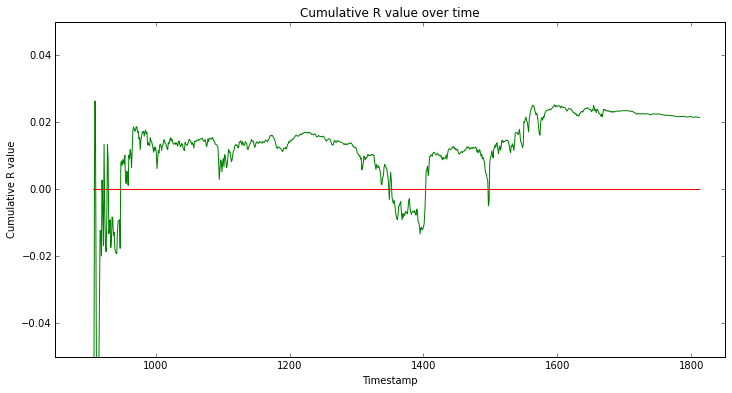

In [29]:
plt.figure(figsize=(12,6))
plt.plot(timestamp_list, cum_reward, color = "green")
plt.plot(timestamp_list, [0]*len(timestamp_list), color = "red")
plt.title("Cumulative R value over time")
plt.xlabel("Timestamp")
plt.ylabel("Cumulative R value")
plt.xlim(850, 1850)
plt.ylim(-0.05, 0.05)
plt.show()

##Cross-validation

In [22]:
n_estimators_grid = [200, 300]
max_depth_grid = [5, 6]

score = []

t0 = time()

for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        
        print("Parameters: \n     n_estimators:{0} \n     max_depth: {1}"\
              .format(n_estimators, max_depth))
        
        # The "environment" is our interface.
        env = kagglegym.make()

        # We get our initial observation by calling "reset".
        o = env.reset()

        excl = ["id", "timestamp", "y"]
        col = [c for c in o.train.columns if c not in excl]
        train = o.train.loc[:, col]

        # Total number of NA values per observation.
        train.loc[:, "is_null"] = train.isnull().sum(axis=1)

        # Record NA values and then fill them with the median.
        d_mean = train.median(axis=0)

        for c in col:
            train.loc[:, c + "_nan"] = pd.isnull(train[c])
            d_mean[c + "_nan"] = 0

        train = train.fillna(d_mean)
        
        # Model 1
        low_y_cut = -0.075
        high_y_cut = 0.075
        y_is_above_cut = (o.train.y > high_y_cut)
        y_is_below_cut = (o.train.y < low_y_cut)
        y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
        model_1 = LinearRegression(n_jobs=-1)
        model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
                    o.train.loc[y_is_within_cut, "y"])
        
        # Model 2
        extra_trees = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                          n_jobs=-1, random_state=17, verbose=0)
        model_2 = extra_trees.fit(train, o.train["y"])

        ymean_dict = dict(o.train.groupby(["id"])["y"].median())

        while True:
            test = o.features.loc[:, col]
            # Total number of NA values per observation.
            test.loc[:, "is_null"] = test.isnull().sum(axis=1)

            # Fill NA values.
            for c in col:
                test.loc[:, c + "_nan"] = pd.isnull(test[c])

            test = test.fillna(d_mean)

            pred = o.target
            test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)

            # Ponderation of the two models.
            pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                         + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
            # Add the median of the target value by ID.
            pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis=1)

            # The target values have 6 decimals in the training set.
            pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]

            o, reward, done, info = env.step(pred)
            if done:
                print("Finished", info["public_score"])
                break
            if o.features.timestamp[0] % 100 == 0:
                print(reward)
        
        score.append(info["public_score"])

        print("Running time: {0}s.".format(time() - t0))

Parameters: 
     n_estimators:200 
     max_depth: 5
-0.317612904033
-0.182022570997
-0.169765407348
0.0155721899717
-0.120887529213
-0.161751403784
-0.207983802147
-0.304530203505
-0.0193565919651
('Finished', 0.022544354775984359)
Running time: 1942.98224711s.
Parameters: 
     n_estimators:200 
     max_depth: 6
-0.317964370131
-0.181636354313
-0.170090172396
0.0210891114915
-0.122100133863
-0.15869220995
-0.208973403429
-0.304452852273
-0.0227012427798
('Finished', 0.023818689235850024)
Running time: 4134.09156013s.
Parameters: 
     n_estimators:300 
     max_depth: 5
-0.317710106052
-0.18212292887
-0.169783469952
0.0200483728335
-0.121449198546
-0.16200032081
-0.208525665085
-0.304498983443
-0.0229799518439
('Finished', 0.022265339569625051)
Running time: 6898.75451612s.
Parameters: 
     n_estimators:300 
     max_depth: 6
-0.318000512358
-0.18192592894
-0.170338108637
0.0224381742101
-0.123044219716
-0.158405005328
-0.210106180808
-0.304121947237
-0.0268123027067
('Finished', 

In [ ]:
#0.0148877463784 for model_1 only (8 mins)
#0.021473779155142633  for model_1 and model_2 (7 mins)

# First cross-validation
#Parameters: 
     #n_estimators:200 
     #max_depth: 5
#
#('Finished', 0.022544354775984359)

#Running time: 1942.98224711s.
#Parameters: 
     #n_estimators:200 
     #max_depth: 6
#('Finished', 0.023818689235850024)
#Running time: 4134.09156013s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 5
#('Finished', 0.022265339569625051)

#Running time: 6898.75451612s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 6
#('Finished', 0.023778939527378237)
#Running time: 10013.6646042s.